# Experiment 1
- Pre-trained model: BERT-based TAPE model => 12개의 encoder layers

- Fine-tuning rounds:
    - Round 1
        - 말단 10개의 encoder와 classifier를 Dash, VDJdb, McPAS 데이터를 사용하여 fine-tuning
        - 150 epochs with early stopping until 15 epochs
        - Noam optimizer with lr: 1e-3 and warmup: 4000
    - Round 2
        - 말단 6개 encoder와 classifier를 IEDB SARS-2 데이터를 사용하여 fine-tuning
        - 100 epochs with early stopping until 10 epochs
        - Noam optimizer with lr: 1e-3 and warmup: 4000
        
- Model evaluation
    - COVID-19 S-protein269-277(YLQPRTFLL) with the epitope-specific TCRβs from recent two studies
    - 352 TCRbeta from Shomuradova et al, 415 TCRbeta from ImmuneCODE
    - Attention 분석을 통해 TCR CDR3beta와 에피토프 펩타이드 서열의 모티프를 식별한다.
   

## Global configurations

In [1]:
import logging
import logging.config
import os
import sys
import warnings
from enum import auto
import pandas as pd
import numpy as np
from IPython.core.display import display

rootdir = '/home/hym/trunk/TCRBert'
workdir = '%s/notebook' % rootdir
datadir = '%s/data' % rootdir
srcdir = '%s/tcrbert' % rootdir
outdir = '%s/output' % rootdir

os.chdir(workdir)

sys.path.append(rootdir)
sys.path.append(srcdir)

display(sys.path)

from tcrbert.exp import Experiment
from tcrbert.predlistener import PredResultRecoder


# Display
pd.set_option('display.max.rows', 999)
pd.set_option('display.max.columns', 999)

# Logger
warnings.filterwarnings('ignore')
logging.config.fileConfig('../config/logging.conf')
logger = logging.getLogger('tcrbert')
logger.setLevel(logging.INFO)

# Target experiment
exp_key = 'exp1'
experiment = Experiment.from_key(exp_key)

exp_conf = experiment.exp_conf

display(exp_conf)

['/home/hym/trunk/TCRBert/notebook',
 '/home/hym/trunk/TCRBert/notebook',
 '/home/hym/trunk/epidab',
 '/home/hym/trunk/epidab/epidab',
 '/home/hym/trunk/kvacc',
 '/home/hym/trunk/kvacc/kvacc',
 '/home/hym/trunk/lib',
 '/home/hym/trunk',
 '/home/hym/trunk/TCRBert',
 '/home/hym/trunk/TCRBert/tcrbert',
 '/home/hym/anaconda3/envs/py37-torch/lib/python37.zip',
 '/home/hym/anaconda3/envs/py37-torch/lib/python3.7',
 '/home/hym/anaconda3/envs/py37-torch/lib/python3.7/lib-dynload',
 '',
 '/home/hym/anaconda3/envs/py37-torch/lib/python3.7/site-packages',
 '/home/hym/anaconda3/envs/py37-torch/lib/python3.7/site-packages/IPython/extensions',
 '/home/hym/.ipython',
 '/home/hym/trunk/TCRBert',
 '/home/hym/trunk/TCRBert/tcrbert']

2021-09-29 20:21:33 [INFO]: Loaded exp_conf: {'title': 'exp1', 'description': 'Dash, VDJdb, McPAS 데이터로 말단 10개의 encoder와 classifier 학습=>IEDB SARS-2 데이터로 말단 6개 encoder와 classifier 학습', 'paper': 'exp1', 'model_config': '../config/bert-base/', 'train': {'pretrained_model': {'type': 'tape', 'location': '../config/bert-base/'}, 'data_parallel': False, 'rounds': [{'data': 'dash_vdjdb_mcpas', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 150, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'name': 'noam', 'lr': 0.001, 'warmup_steps': 4000}, 'train_bert_encoders': [-10, None], 'early_stopper': {'monitor': 'accuracy', 'patience': 15}, 'model_checkpoint': {'chk': '../output/exp1/train.0.model_{epoch}.chk', 'monitor': 'accuracy', 'save_best_only': True, 'period': 1}, 'result': '../output/exp1/train.0.result.json'}, {'data': 'iedb_sars2', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 100, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'name': 'noam', 'lr': 0.001, 'warmup_step

{'title': 'exp1',
 'description': 'Dash, VDJdb, McPAS 데이터로 말단 10개의 encoder와 classifier 학습=>IEDB SARS-2 데이터로 말단 6개 encoder와 classifier 학습',
 'paper': 'exp1',
 'model_config': '../config/bert-base/',
 'train': {'pretrained_model': {'type': 'tape',
   'location': '../config/bert-base/'},
  'data_parallel': False,
  'rounds': [{'data': 'dash_vdjdb_mcpas',
    'test_size': 0.2,
    'batch_size': 128,
    'n_epochs': 150,
    'n_workers': 12,
    'metrics': ['accuracy'],
    'optimizer': {'name': 'noam', 'lr': 0.001, 'warmup_steps': 4000},
    'train_bert_encoders': [-10, None],
    'early_stopper': {'monitor': 'accuracy', 'patience': 15},
    'model_checkpoint': {'chk': '../output/exp1/train.0.model_{epoch}.chk',
     'monitor': 'accuracy',
     'save_best_only': True,
     'period': 1},
    'result': '../output/exp1/train.0.result.json'},
   {'data': 'iedb_sars2',
    'test_size': 0.2,
    'batch_size': 128,
    'n_epochs': 100,
    'n_workers': 12,
    'metrics': ['accuracy'],
    'optimi

## Exploring fine-tuning datasets

### Dash + VDJdb + McPAS

In [2]:
from tcrbert.dataset import TCREpitopeSentenceDataset, CN

train_ds = TCREpitopeSentenceDataset.from_key('dash_vdjdb_mcpas')
train_df = train_ds.df_enc

display(train_df.head(), train_df.shape)
tmp = train_df.epitope.value_counts()
display(tmp.shape, tmp)
display(train_df.label.value_counts())
display(''.join(train_ds.encoder.to_tokens(train_df['sentence'].iloc[0])))

np.count_nonzero(train_df[CN.epitope] == 'YLQPRTFLL')

,epitope,epitope_gene,epitope_species,species,cdr3b,mhc,source,label,sentence
GLCTLVAML_CASSLWTGSHEQYF,GLCTLVAML,BMLF,EBV,human,CASSLWTGSHEQYF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CASSQSPGGEQYF,GLCTLVAML,BMLF,EBV,human,CASSQSPGGEQYF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CASSLTTEQQFF,GLCTLVAML,BMLF,EBV,human,CASSLTTEQQFF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 5, 22..."
GLCTLVAML_CSARDATGNGYTF,GLCTLVAML,BMLF,EBV,human,CSARDATGNGYTF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 22, 5..."
GLCTLVAML_CSARDSTGNGYTF,GLCTLVAML,BMLF,EBV,human,CSARDSTGNGYTF,HLA-A*02:01,Dash,1,"[2, 11, 15, 7, 23, 15, 25, 5, 16, 15, 7, 22, 5..."


(25138, 9)

(78,)

LPRRSGAAGA      4284
GILGFVFTL       2560
GLCTLVAML       1858
NLVPMVATV       1370
CRVLCCYVL        870
SSLENFRAYV       840
TPRVTGGGAM       696
SSYRRPVGI        686
ELAGIGILTV       576
ASNENMETM        570
EAAGIGILTV       566
VTEHDTLLY        546
FRCPRRFCF        532
LLWNGPMAV        478
KRWIILGLNK       464
RAKFKQLL         440
RPHERNGFTVL      412
HGIRNASFI        402
LSLRNPILV        372
KAFSPEVIPMF      344
ATDALMTGY        306
CTPYDINQM        304
SFHSLHLLF        276
FLCMKALLL        272
TTPESANL         228
FPRPWLHGL        190
EIYKRWII         188
KLVALGINAV       188
YVLDHLIVV        184
FLKEKGGL         180
TPQDLNTML        150
IPSINVHHY        150
SSPPMFRV         148
TVYGFCLL         146
NLNCCSVPV        140
STPESANL         138
LPPIVAKEI        128
HPKVSSEVHI       126
YSEHPTFTSQY      126
TPGPGVRYPL       124
GTSGSPIVNR       124
NEGVKAAW         124
GPGHKARVL        112
IMNDMPIYM        110
GTSGSPIINR        96
KMVAVFYTT         94
MLNIPSINV         92
HSKKKCDEL    

0    12569
1    12569
Name: label, dtype: int64

'<cls>GLCTLVAMLCASSLWTGSHEQYF<sep><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

0

### IEDB SARS-Cov-2

In [3]:
train_ds = TCREpitopeSentenceDataset.from_key('iedb_sars2')
train_df = train_ds.df_enc

display(train_df.head(), train_df.shape)
tmp = train_df.epitope.value_counts()
display(tmp.shape, tmp)
display(train_df.label.value_counts())
display(''.join(train_ds.encoder.to_tokens(train_df['sentence'].iloc[0])))

np.count_nonzero(train_df[CN.epitope] == 'YLQPRTFLL')

,epitope,epitope_gene,epitope_species,species,cdr3b,mhc,source,label,sentence
FLPFFSNVTWFHAI_CASSIRSSYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIRSSYEQYF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSIGVYGYTF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIGVYGYTF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSIRSAYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSIRSAYEQYF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSSRSSYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSSRSSYEQYF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."
FLPFFSNVTWFHAI_CASSTRSAYEQYF,FLPFFSNVTWFHAI,surface glycoprotein [Severe acute respiratory...,SARS-CoV2,human,CASSTRSAYEQYF,HLA class I,IEDB,1,"[2, 10, 15, 19, 10, 10, 22, 17, 25, 23, 26, 10..."


(98563, 9)

(145,)

HTTDPSFLGRY        11586
SEHDYQIGGYTEKW      6848
FLNGSCGSV           5136
KLSYGIATV           4920
AELAKNVSLDNVL       3588
APKEIIFLEGETL       3572
LSPRWYFYYL          3502
KLPDDFTGCV          2638
VLPFNDGVYFASTEK     2594
VQELYSPIFLIV        2126
GMEVTPSGTWLTY       1990
LLLDDFVEII          1936
SELVIGAVIL          1800
RQLLFVVEV           1784
YEDFLEYHDVRVVL      1752
FLPRVFSAV           1734
KAYNVTQAF           1614
VLPPLLTDEMIAQYT     1347
TVLSFCAFAV          1226
WICLLQFAY           1180
TLIGDCATV           1138
NPLLYDANYFLCW       1096
YEQYIKWPWYI         1074
VLHSYFTSDYYQLY       970
RSVASQSIIAYTMSL      940
SNEKQEILGTVSWNL      902
YLNTLTLAV            864
FGEVFNATRFASVY       836
LEPLVDLPI            834
YFPLQSYGF            796
YYVGYLQPRTFLL        730
KPLEFGATSAAL         724
ALRKVPTDNYITTY       692
AYKTFPPTEPK          676
KLWAQCVQL            624
RNPANNAAIVL          622
FLPFFSNVTWFHAI       602
VYSTGSNVFQTR         572
NRDVDTDFVNEFYAY      570
SEVGPEHSLAEY         542


1    49282
0    49281
Name: label, dtype: int64

'<cls>FLPFFSNVTWFHAICASSIRSSYEQYF<sep><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

0

## Fine-tuning

In [4]:
experiment.train()

2021-09-29 20:34:46 [INFO]: ======================
2021-09-29 20:34:46 [INFO]: Begin train at 2021-09-29 20:34:46.848332
2021-09-29 20:34:46 [INFO]: Loading the TAPE pretrained model from ../config/bert-base/
2021-09-29 20:34:51 [INFO]: Start 2 train rounds of exp1 at 2021-09-29 20:34:46.848332
2021-09-29 20:34:51 [INFO]: train_conf: {'pretrained_model': {'type': 'tape', 'location': '../config/bert-base/'}, 'data_parallel': False, 'rounds': [{'data': 'dash_vdjdb_mcpas', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 150, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'name': 'noam', 'lr': 0.001, 'warmup_steps': 4000}, 'train_bert_encoders': [-10, None], 'early_stopper': {'monitor': 'accuracy', 'patience': 15}, 'model_checkpoint': {'chk': '../output/exp1/train.0.model_{epoch}.chk', 'monitor': 'accuracy', 'save_best_only': True, 'period': 1}, 'result': '../output/exp1/train.0.result.json'}, {'data': 'iedb_sars2', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 100, 'n_workers

2021-09-29 20:34:54 [INFO]: train.n_data: 20110, test.n_data: 5028
2021-09-29 20:34:54 [INFO]: optimizer: NoamOptimizer (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-09
    lr: 0.001
    weight_decay: 0
)
2021-09-29 20:34:54 [INFO]: evaluator: <tcrbert.model.BertTCREpitopeModel.PredictionEvaluator object at 0x7f0b5f852590>
2021-09-29 20:34:54 [INFO]: n_epochs: 150
2021-09-29 20:34:54 [INFO]: train.batch_size: 128
2021-09-29 20:34:54 [INFO]: test.batch_size: 128
2021-09-29 20:34:54 [INFO]: --------------------
2021-09-29 20:34:54 [INFO]: Begin epoch 0/150 at 2021-09-29 20:34:54.653396
2021-09-29 20:34:54 [INFO]: Begin training phase at epoch 0/150
2021-09-29 20:34:55 [INFO]: Begin 0/157 batch in train phase of 0/150 epoch
2021-09-29 20:34:56 [INFO]: End 0/157 batch in train phase of 0/150 epoch
2021-09-29 20:34:56 [INFO]: Begin 1/157 batch in train phase of 0/150 epoch
2021-09-29 20:34:57 [INFO]: End 1/157 batch in train phase of 0/150 epoch
2021-09-29 20:34

2021-09-29 20:35:58 [INFO]: Begin 50/157 batch in train phase of 0/150 epoch
2021-09-29 20:36:00 [INFO]: End 50/157 batch in train phase of 0/150 epoch
2021-09-29 20:36:00 [INFO]: Begin 51/157 batch in train phase of 0/150 epoch
2021-09-29 20:36:01 [INFO]: End 51/157 batch in train phase of 0/150 epoch
2021-09-29 20:36:01 [INFO]: Begin 52/157 batch in train phase of 0/150 epoch
2021-09-29 20:36:02 [INFO]: End 52/157 batch in train phase of 0/150 epoch
2021-09-29 20:36:02 [INFO]: Begin 53/157 batch in train phase of 0/150 epoch
2021-09-29 20:36:03 [INFO]: End 53/157 batch in train phase of 0/150 epoch
2021-09-29 20:36:03 [INFO]: Begin 54/157 batch in train phase of 0/150 epoch
2021-09-29 20:36:05 [INFO]: End 54/157 batch in train phase of 0/150 epoch
2021-09-29 20:36:05 [INFO]: Begin 55/157 batch in train phase of 0/150 epoch
2021-09-29 20:36:06 [INFO]: End 55/157 batch in train phase of 0/150 epoch
2021-09-29 20:36:06 [INFO]: Begin 56/157 batch in train phase of 0/150 epoch
2021-09-29 

2021-09-29 20:37:06 [INFO]: Begin 104/157 batch in train phase of 0/150 epoch
2021-09-29 20:37:07 [INFO]: End 104/157 batch in train phase of 0/150 epoch
2021-09-29 20:37:07 [INFO]: Begin 105/157 batch in train phase of 0/150 epoch
2021-09-29 20:37:08 [INFO]: End 105/157 batch in train phase of 0/150 epoch
2021-09-29 20:37:08 [INFO]: Begin 106/157 batch in train phase of 0/150 epoch
2021-09-29 20:37:10 [INFO]: End 106/157 batch in train phase of 0/150 epoch
2021-09-29 20:37:10 [INFO]: Begin 107/157 batch in train phase of 0/150 epoch
2021-09-29 20:37:11 [INFO]: End 107/157 batch in train phase of 0/150 epoch
2021-09-29 20:37:11 [INFO]: Begin 108/157 batch in train phase of 0/150 epoch
2021-09-29 20:37:12 [INFO]: End 108/157 batch in train phase of 0/150 epoch
2021-09-29 20:37:12 [INFO]: Begin 109/157 batch in train phase of 0/150 epoch
2021-09-29 20:37:13 [INFO]: End 109/157 batch in train phase of 0/150 epoch
2021-09-29 20:37:13 [INFO]: Begin 110/157 batch in train phase of 0/150 epoc

2021-09-29 20:38:13 [INFO]: End 157/157 batch in train phase of 0/150 epoch
2021-09-29 20:38:13 [INFO]: End training phase at epoch 0/150
2021-09-29 20:38:13 [INFO]: Begin validation phase at epoch 0/150
2021-09-29 20:38:13 [INFO]: Begin 0/39 batch in val phase of 0/150 epoch
2021-09-29 20:38:14 [INFO]: End 0/39 batch in val phase of 0/150 epoch
2021-09-29 20:38:14 [INFO]: Begin 1/39 batch in val phase of 0/150 epoch
2021-09-29 20:38:15 [INFO]: End 1/39 batch in val phase of 0/150 epoch
2021-09-29 20:38:15 [INFO]: Begin 2/39 batch in val phase of 0/150 epoch
2021-09-29 20:38:16 [INFO]: End 2/39 batch in val phase of 0/150 epoch
2021-09-29 20:38:16 [INFO]: Begin 3/39 batch in val phase of 0/150 epoch
2021-09-29 20:38:17 [INFO]: End 3/39 batch in val phase of 0/150 epoch
2021-09-29 20:38:17 [INFO]: Begin 4/39 batch in val phase of 0/150 epoch
2021-09-29 20:38:18 [INFO]: End 4/39 batch in val phase of 0/150 epoch
2021-09-29 20:38:18 [INFO]: Begin 5/39 batch in val phase of 0/150 epoch
202

2021-09-29 20:39:02 [INFO]: Begin 8/157 batch in train phase of 1/150 epoch
2021-09-29 20:39:04 [INFO]: End 8/157 batch in train phase of 1/150 epoch
2021-09-29 20:39:04 [INFO]: Begin 9/157 batch in train phase of 1/150 epoch
2021-09-29 20:39:05 [INFO]: End 9/157 batch in train phase of 1/150 epoch
2021-09-29 20:39:05 [INFO]: Begin 10/157 batch in train phase of 1/150 epoch
2021-09-29 20:39:06 [INFO]: End 10/157 batch in train phase of 1/150 epoch
2021-09-29 20:39:06 [INFO]: Begin 11/157 batch in train phase of 1/150 epoch
2021-09-29 20:39:07 [INFO]: End 11/157 batch in train phase of 1/150 epoch
2021-09-29 20:39:07 [INFO]: Begin 12/157 batch in train phase of 1/150 epoch
2021-09-29 20:39:09 [INFO]: End 12/157 batch in train phase of 1/150 epoch
2021-09-29 20:39:09 [INFO]: Begin 13/157 batch in train phase of 1/150 epoch
2021-09-29 20:39:10 [INFO]: End 13/157 batch in train phase of 1/150 epoch
2021-09-29 20:39:10 [INFO]: Begin 14/157 batch in train phase of 1/150 epoch
2021-09-29 20:3

2021-09-29 20:40:10 [INFO]: Begin 62/157 batch in train phase of 1/150 epoch
2021-09-29 20:40:11 [INFO]: End 62/157 batch in train phase of 1/150 epoch
2021-09-29 20:40:11 [INFO]: Begin 63/157 batch in train phase of 1/150 epoch
2021-09-29 20:40:13 [INFO]: End 63/157 batch in train phase of 1/150 epoch
2021-09-29 20:40:13 [INFO]: Begin 64/157 batch in train phase of 1/150 epoch
2021-09-29 20:40:14 [INFO]: End 64/157 batch in train phase of 1/150 epoch
2021-09-29 20:40:14 [INFO]: Begin 65/157 batch in train phase of 1/150 epoch
2021-09-29 20:40:15 [INFO]: End 65/157 batch in train phase of 1/150 epoch
2021-09-29 20:40:15 [INFO]: Begin 66/157 batch in train phase of 1/150 epoch
2021-09-29 20:40:17 [INFO]: End 66/157 batch in train phase of 1/150 epoch
2021-09-29 20:40:17 [INFO]: Begin 67/157 batch in train phase of 1/150 epoch
2021-09-29 20:40:18 [INFO]: End 67/157 batch in train phase of 1/150 epoch
2021-09-29 20:40:18 [INFO]: Begin 68/157 batch in train phase of 1/150 epoch
2021-09-29 

2021-09-29 20:41:18 [INFO]: Begin 116/157 batch in train phase of 1/150 epoch
2021-09-29 20:41:20 [INFO]: End 116/157 batch in train phase of 1/150 epoch
2021-09-29 20:41:20 [INFO]: Begin 117/157 batch in train phase of 1/150 epoch
2021-09-29 20:41:21 [INFO]: End 117/157 batch in train phase of 1/150 epoch
2021-09-29 20:41:21 [INFO]: Begin 118/157 batch in train phase of 1/150 epoch
2021-09-29 20:41:22 [INFO]: End 118/157 batch in train phase of 1/150 epoch
2021-09-29 20:41:22 [INFO]: Begin 119/157 batch in train phase of 1/150 epoch
2021-09-29 20:41:23 [INFO]: End 119/157 batch in train phase of 1/150 epoch
2021-09-29 20:41:23 [INFO]: Begin 120/157 batch in train phase of 1/150 epoch
2021-09-29 20:41:25 [INFO]: End 120/157 batch in train phase of 1/150 epoch
2021-09-29 20:41:25 [INFO]: Begin 121/157 batch in train phase of 1/150 epoch
2021-09-29 20:41:26 [INFO]: End 121/157 batch in train phase of 1/150 epoch
2021-09-29 20:41:26 [INFO]: Begin 122/157 batch in train phase of 1/150 epoc

2021-09-29 20:42:23 [INFO]: End 11/39 batch in val phase of 1/150 epoch
2021-09-29 20:42:23 [INFO]: Begin 12/39 batch in val phase of 1/150 epoch
2021-09-29 20:42:24 [INFO]: End 12/39 batch in val phase of 1/150 epoch
2021-09-29 20:42:24 [INFO]: Begin 13/39 batch in val phase of 1/150 epoch
2021-09-29 20:42:25 [INFO]: End 13/39 batch in val phase of 1/150 epoch
2021-09-29 20:42:25 [INFO]: Begin 14/39 batch in val phase of 1/150 epoch
2021-09-29 20:42:26 [INFO]: End 14/39 batch in val phase of 1/150 epoch
2021-09-29 20:42:26 [INFO]: Begin 15/39 batch in val phase of 1/150 epoch
2021-09-29 20:42:26 [INFO]: End 15/39 batch in val phase of 1/150 epoch
2021-09-29 20:42:26 [INFO]: Begin 16/39 batch in val phase of 1/150 epoch
2021-09-29 20:42:27 [INFO]: End 16/39 batch in val phase of 1/150 epoch
2021-09-29 20:42:27 [INFO]: Begin 17/39 batch in val phase of 1/150 epoch
2021-09-29 20:42:28 [INFO]: End 17/39 batch in val phase of 1/150 epoch
2021-09-29 20:42:28 [INFO]: Begin 18/39 batch in val

2021-09-29 20:43:16 [INFO]: Begin 20/157 batch in train phase of 2/150 epoch
2021-09-29 20:43:17 [INFO]: End 20/157 batch in train phase of 2/150 epoch
2021-09-29 20:43:17 [INFO]: Begin 21/157 batch in train phase of 2/150 epoch
2021-09-29 20:43:18 [INFO]: End 21/157 batch in train phase of 2/150 epoch
2021-09-29 20:43:18 [INFO]: Begin 22/157 batch in train phase of 2/150 epoch
2021-09-29 20:43:20 [INFO]: End 22/157 batch in train phase of 2/150 epoch
2021-09-29 20:43:20 [INFO]: Begin 23/157 batch in train phase of 2/150 epoch
2021-09-29 20:43:21 [INFO]: End 23/157 batch in train phase of 2/150 epoch
2021-09-29 20:43:21 [INFO]: Begin 24/157 batch in train phase of 2/150 epoch
2021-09-29 20:43:22 [INFO]: End 24/157 batch in train phase of 2/150 epoch
2021-09-29 20:43:22 [INFO]: Begin 25/157 batch in train phase of 2/150 epoch
2021-09-29 20:43:24 [INFO]: End 25/157 batch in train phase of 2/150 epoch
2021-09-29 20:43:24 [INFO]: Begin 26/157 batch in train phase of 2/150 epoch
2021-09-29 

2021-09-29 20:44:24 [INFO]: Begin 74/157 batch in train phase of 2/150 epoch
2021-09-29 20:44:26 [INFO]: End 74/157 batch in train phase of 2/150 epoch
2021-09-29 20:44:26 [INFO]: Begin 75/157 batch in train phase of 2/150 epoch
2021-09-29 20:44:27 [INFO]: End 75/157 batch in train phase of 2/150 epoch
2021-09-29 20:44:27 [INFO]: Begin 76/157 batch in train phase of 2/150 epoch
2021-09-29 20:44:28 [INFO]: End 76/157 batch in train phase of 2/150 epoch
2021-09-29 20:44:28 [INFO]: Begin 77/157 batch in train phase of 2/150 epoch
2021-09-29 20:44:29 [INFO]: End 77/157 batch in train phase of 2/150 epoch
2021-09-29 20:44:29 [INFO]: Begin 78/157 batch in train phase of 2/150 epoch
2021-09-29 20:44:31 [INFO]: End 78/157 batch in train phase of 2/150 epoch
2021-09-29 20:44:31 [INFO]: Begin 79/157 batch in train phase of 2/150 epoch
2021-09-29 20:44:32 [INFO]: End 79/157 batch in train phase of 2/150 epoch
2021-09-29 20:44:32 [INFO]: Begin 80/157 batch in train phase of 2/150 epoch
2021-09-29 

2021-09-29 20:45:32 [INFO]: Begin 128/157 batch in train phase of 2/150 epoch
2021-09-29 20:45:34 [INFO]: End 128/157 batch in train phase of 2/150 epoch
2021-09-29 20:45:34 [INFO]: Begin 129/157 batch in train phase of 2/150 epoch
2021-09-29 20:45:35 [INFO]: End 129/157 batch in train phase of 2/150 epoch
2021-09-29 20:45:35 [INFO]: Begin 130/157 batch in train phase of 2/150 epoch
2021-09-29 20:45:36 [INFO]: End 130/157 batch in train phase of 2/150 epoch
2021-09-29 20:45:36 [INFO]: Begin 131/157 batch in train phase of 2/150 epoch
2021-09-29 20:45:37 [INFO]: End 131/157 batch in train phase of 2/150 epoch
2021-09-29 20:45:37 [INFO]: Begin 132/157 batch in train phase of 2/150 epoch
2021-09-29 20:45:39 [INFO]: End 132/157 batch in train phase of 2/150 epoch
2021-09-29 20:45:39 [INFO]: Begin 133/157 batch in train phase of 2/150 epoch
2021-09-29 20:45:40 [INFO]: End 133/157 batch in train phase of 2/150 epoch
2021-09-29 20:45:40 [INFO]: Begin 134/157 batch in train phase of 2/150 epoc

2021-09-29 20:46:32 [INFO]: Begin 24/39 batch in val phase of 2/150 epoch
2021-09-29 20:46:33 [INFO]: End 24/39 batch in val phase of 2/150 epoch
2021-09-29 20:46:33 [INFO]: Begin 25/39 batch in val phase of 2/150 epoch
2021-09-29 20:46:34 [INFO]: End 25/39 batch in val phase of 2/150 epoch
2021-09-29 20:46:34 [INFO]: Begin 26/39 batch in val phase of 2/150 epoch
2021-09-29 20:46:35 [INFO]: End 26/39 batch in val phase of 2/150 epoch
2021-09-29 20:46:35 [INFO]: Begin 27/39 batch in val phase of 2/150 epoch
2021-09-29 20:46:36 [INFO]: End 27/39 batch in val phase of 2/150 epoch
2021-09-29 20:46:36 [INFO]: Begin 28/39 batch in val phase of 2/150 epoch
2021-09-29 20:46:37 [INFO]: End 28/39 batch in val phase of 2/150 epoch
2021-09-29 20:46:37 [INFO]: Begin 29/39 batch in val phase of 2/150 epoch
2021-09-29 20:46:38 [INFO]: End 29/39 batch in val phase of 2/150 epoch
2021-09-29 20:46:38 [INFO]: Begin 30/39 batch in val phase of 2/150 epoch
2021-09-29 20:46:39 [INFO]: End 30/39 batch in val

2021-09-29 20:47:29 [INFO]: Begin 32/157 batch in train phase of 3/150 epoch
2021-09-29 20:47:31 [INFO]: End 32/157 batch in train phase of 3/150 epoch
2021-09-29 20:47:31 [INFO]: Begin 33/157 batch in train phase of 3/150 epoch
2021-09-29 20:47:32 [INFO]: End 33/157 batch in train phase of 3/150 epoch
2021-09-29 20:47:32 [INFO]: Begin 34/157 batch in train phase of 3/150 epoch
2021-09-29 20:47:33 [INFO]: End 34/157 batch in train phase of 3/150 epoch
2021-09-29 20:47:33 [INFO]: Begin 35/157 batch in train phase of 3/150 epoch
2021-09-29 20:47:35 [INFO]: End 35/157 batch in train phase of 3/150 epoch
2021-09-29 20:47:35 [INFO]: Begin 36/157 batch in train phase of 3/150 epoch
2021-09-29 20:47:36 [INFO]: End 36/157 batch in train phase of 3/150 epoch
2021-09-29 20:47:36 [INFO]: Begin 37/157 batch in train phase of 3/150 epoch
2021-09-29 20:47:37 [INFO]: End 37/157 batch in train phase of 3/150 epoch
2021-09-29 20:47:37 [INFO]: Begin 38/157 batch in train phase of 3/150 epoch
2021-09-29 

2021-09-29 20:48:38 [INFO]: Begin 86/157 batch in train phase of 3/150 epoch
2021-09-29 20:48:39 [INFO]: End 86/157 batch in train phase of 3/150 epoch
2021-09-29 20:48:39 [INFO]: Begin 87/157 batch in train phase of 3/150 epoch
2021-09-29 20:48:40 [INFO]: End 87/157 batch in train phase of 3/150 epoch
2021-09-29 20:48:40 [INFO]: Begin 88/157 batch in train phase of 3/150 epoch
2021-09-29 20:48:42 [INFO]: End 88/157 batch in train phase of 3/150 epoch
2021-09-29 20:48:42 [INFO]: Begin 89/157 batch in train phase of 3/150 epoch
2021-09-29 20:48:43 [INFO]: End 89/157 batch in train phase of 3/150 epoch
2021-09-29 20:48:43 [INFO]: Begin 90/157 batch in train phase of 3/150 epoch
2021-09-29 20:48:44 [INFO]: End 90/157 batch in train phase of 3/150 epoch
2021-09-29 20:48:44 [INFO]: Begin 91/157 batch in train phase of 3/150 epoch
2021-09-29 20:48:45 [INFO]: End 91/157 batch in train phase of 3/150 epoch
2021-09-29 20:48:45 [INFO]: Begin 92/157 batch in train phase of 3/150 epoch
2021-09-29 

2021-09-29 20:49:45 [INFO]: End 139/157 batch in train phase of 3/150 epoch
2021-09-29 20:49:45 [INFO]: Begin 140/157 batch in train phase of 3/150 epoch
2021-09-29 20:49:46 [INFO]: End 140/157 batch in train phase of 3/150 epoch
2021-09-29 20:49:46 [INFO]: Begin 141/157 batch in train phase of 3/150 epoch
2021-09-29 20:49:48 [INFO]: End 141/157 batch in train phase of 3/150 epoch
2021-09-29 20:49:48 [INFO]: Begin 142/157 batch in train phase of 3/150 epoch
2021-09-29 20:49:49 [INFO]: End 142/157 batch in train phase of 3/150 epoch
2021-09-29 20:49:49 [INFO]: Begin 143/157 batch in train phase of 3/150 epoch
2021-09-29 20:49:50 [INFO]: End 143/157 batch in train phase of 3/150 epoch
2021-09-29 20:49:50 [INFO]: Begin 144/157 batch in train phase of 3/150 epoch
2021-09-29 20:49:51 [INFO]: End 144/157 batch in train phase of 3/150 epoch
2021-09-29 20:49:51 [INFO]: Begin 145/157 batch in train phase of 3/150 epoch
2021-09-29 20:49:53 [INFO]: End 145/157 batch in train phase of 3/150 epoch


2021-09-29 20:50:42 [INFO]: Begin 36/39 batch in val phase of 3/150 epoch
2021-09-29 20:50:42 [INFO]: End 36/39 batch in val phase of 3/150 epoch
2021-09-29 20:50:42 [INFO]: Begin 37/39 batch in val phase of 3/150 epoch
2021-09-29 20:50:43 [INFO]: End 37/39 batch in val phase of 3/150 epoch
2021-09-29 20:50:43 [INFO]: Begin 38/39 batch in val phase of 3/150 epoch
2021-09-29 20:50:44 [INFO]: End 38/39 batch in val phase of 3/150 epoch
2021-09-29 20:50:44 [INFO]: Begin 39/39 batch in val phase of 3/150 epoch
2021-09-29 20:50:45 [INFO]: End 39/39 batch in val phase of 3/150 epoch
2021-09-29 20:50:45 [INFO]: End validation phase at epoch 3/150
2021-09-29 20:50:45 [INFO]: [EvalScoreRecoder]: In epoch 3/150, loss train score: 0.49581118437308297, val score: 0.5791225619614124
2021-09-29 20:50:45 [INFO]: [EvalScoreRecoder]: In epoch 3/150, accuracy train score: 0.7438121609403255, val score: 0.6947048611111111
2021-09-29 20:50:45 [INFO]: [EarlyStopper]: In epoch 3/150, accuracy score: 0.69470

2021-09-29 20:51:42 [INFO]: End 43/157 batch in train phase of 4/150 epoch
2021-09-29 20:51:42 [INFO]: Begin 44/157 batch in train phase of 4/150 epoch
2021-09-29 20:51:44 [INFO]: End 44/157 batch in train phase of 4/150 epoch
2021-09-29 20:51:44 [INFO]: Begin 45/157 batch in train phase of 4/150 epoch
2021-09-29 20:51:45 [INFO]: End 45/157 batch in train phase of 4/150 epoch
2021-09-29 20:51:45 [INFO]: Begin 46/157 batch in train phase of 4/150 epoch
2021-09-29 20:51:46 [INFO]: End 46/157 batch in train phase of 4/150 epoch
2021-09-29 20:51:46 [INFO]: Begin 47/157 batch in train phase of 4/150 epoch
2021-09-29 20:51:47 [INFO]: End 47/157 batch in train phase of 4/150 epoch
2021-09-29 20:51:47 [INFO]: Begin 48/157 batch in train phase of 4/150 epoch
2021-09-29 20:51:49 [INFO]: End 48/157 batch in train phase of 4/150 epoch
2021-09-29 20:51:49 [INFO]: Begin 49/157 batch in train phase of 4/150 epoch
2021-09-29 20:51:50 [INFO]: End 49/157 batch in train phase of 4/150 epoch
2021-09-29 20

2021-09-29 20:52:50 [INFO]: End 97/157 batch in train phase of 4/150 epoch
2021-09-29 20:52:50 [INFO]: Begin 98/157 batch in train phase of 4/150 epoch
2021-09-29 20:52:51 [INFO]: End 98/157 batch in train phase of 4/150 epoch
2021-09-29 20:52:51 [INFO]: Begin 99/157 batch in train phase of 4/150 epoch
2021-09-29 20:52:53 [INFO]: End 99/157 batch in train phase of 4/150 epoch
2021-09-29 20:52:53 [INFO]: Begin 100/157 batch in train phase of 4/150 epoch
2021-09-29 20:52:54 [INFO]: End 100/157 batch in train phase of 4/150 epoch
2021-09-29 20:52:54 [INFO]: Begin 101/157 batch in train phase of 4/150 epoch
2021-09-29 20:52:55 [INFO]: End 101/157 batch in train phase of 4/150 epoch
2021-09-29 20:52:55 [INFO]: Begin 102/157 batch in train phase of 4/150 epoch
2021-09-29 20:52:56 [INFO]: End 102/157 batch in train phase of 4/150 epoch
2021-09-29 20:52:56 [INFO]: Begin 103/157 batch in train phase of 4/150 epoch
2021-09-29 20:52:58 [INFO]: End 103/157 batch in train phase of 4/150 epoch
2021-

2021-09-29 20:53:57 [INFO]: Begin 151/157 batch in train phase of 4/150 epoch
2021-09-29 20:53:58 [INFO]: End 151/157 batch in train phase of 4/150 epoch
2021-09-29 20:53:58 [INFO]: Begin 152/157 batch in train phase of 4/150 epoch
2021-09-29 20:53:59 [INFO]: End 152/157 batch in train phase of 4/150 epoch
2021-09-29 20:53:59 [INFO]: Begin 153/157 batch in train phase of 4/150 epoch
2021-09-29 20:54:00 [INFO]: End 153/157 batch in train phase of 4/150 epoch
2021-09-29 20:54:00 [INFO]: Begin 154/157 batch in train phase of 4/150 epoch
2021-09-29 20:54:02 [INFO]: End 154/157 batch in train phase of 4/150 epoch
2021-09-29 20:54:02 [INFO]: Begin 155/157 batch in train phase of 4/150 epoch
2021-09-29 20:54:03 [INFO]: End 155/157 batch in train phase of 4/150 epoch
2021-09-29 20:54:03 [INFO]: Begin 156/157 batch in train phase of 4/150 epoch
2021-09-29 20:54:04 [INFO]: End 156/157 batch in train phase of 4/150 epoch
2021-09-29 20:54:04 [INFO]: Begin 157/157 batch in train phase of 4/150 epoc

2021-09-29 20:54:50 [INFO]: Begin 1/157 batch in train phase of 5/150 epoch
2021-09-29 20:54:51 [INFO]: End 1/157 batch in train phase of 5/150 epoch
2021-09-29 20:54:51 [INFO]: Begin 2/157 batch in train phase of 5/150 epoch
2021-09-29 20:54:52 [INFO]: End 2/157 batch in train phase of 5/150 epoch
2021-09-29 20:54:52 [INFO]: Begin 3/157 batch in train phase of 5/150 epoch
2021-09-29 20:54:54 [INFO]: End 3/157 batch in train phase of 5/150 epoch
2021-09-29 20:54:54 [INFO]: Begin 4/157 batch in train phase of 5/150 epoch
2021-09-29 20:54:55 [INFO]: End 4/157 batch in train phase of 5/150 epoch
2021-09-29 20:54:55 [INFO]: Begin 5/157 batch in train phase of 5/150 epoch
2021-09-29 20:54:56 [INFO]: End 5/157 batch in train phase of 5/150 epoch
2021-09-29 20:54:56 [INFO]: Begin 6/157 batch in train phase of 5/150 epoch
2021-09-29 20:54:57 [INFO]: End 6/157 batch in train phase of 5/150 epoch
2021-09-29 20:54:57 [INFO]: Begin 7/157 batch in train phase of 5/150 epoch
2021-09-29 20:54:59 [INF

2021-09-29 20:56:07 [INFO]: End 55/157 batch in train phase of 5/150 epoch
2021-09-29 20:56:07 [INFO]: Begin 56/157 batch in train phase of 5/150 epoch
2021-09-29 20:56:09 [INFO]: End 56/157 batch in train phase of 5/150 epoch
2021-09-29 20:56:09 [INFO]: Begin 57/157 batch in train phase of 5/150 epoch
2021-09-29 20:56:10 [INFO]: End 57/157 batch in train phase of 5/150 epoch
2021-09-29 20:56:10 [INFO]: Begin 58/157 batch in train phase of 5/150 epoch
2021-09-29 20:56:11 [INFO]: End 58/157 batch in train phase of 5/150 epoch
2021-09-29 20:56:11 [INFO]: Begin 59/157 batch in train phase of 5/150 epoch
2021-09-29 20:56:12 [INFO]: End 59/157 batch in train phase of 5/150 epoch
2021-09-29 20:56:12 [INFO]: Begin 60/157 batch in train phase of 5/150 epoch
2021-09-29 20:56:14 [INFO]: End 60/157 batch in train phase of 5/150 epoch
2021-09-29 20:56:14 [INFO]: Begin 61/157 batch in train phase of 5/150 epoch
2021-09-29 20:56:15 [INFO]: End 61/157 batch in train phase of 5/150 epoch
2021-09-29 20

2021-09-29 20:57:15 [INFO]: End 109/157 batch in train phase of 5/150 epoch
2021-09-29 20:57:15 [INFO]: Begin 110/157 batch in train phase of 5/150 epoch
2021-09-29 20:57:16 [INFO]: End 110/157 batch in train phase of 5/150 epoch
2021-09-29 20:57:16 [INFO]: Begin 111/157 batch in train phase of 5/150 epoch
2021-09-29 20:57:17 [INFO]: End 111/157 batch in train phase of 5/150 epoch
2021-09-29 20:57:17 [INFO]: Begin 112/157 batch in train phase of 5/150 epoch
2021-09-29 20:57:18 [INFO]: End 112/157 batch in train phase of 5/150 epoch
2021-09-29 20:57:18 [INFO]: Begin 113/157 batch in train phase of 5/150 epoch
2021-09-29 20:57:20 [INFO]: End 113/157 batch in train phase of 5/150 epoch
2021-09-29 20:57:20 [INFO]: Begin 114/157 batch in train phase of 5/150 epoch
2021-09-29 20:57:21 [INFO]: End 114/157 batch in train phase of 5/150 epoch
2021-09-29 20:57:21 [INFO]: Begin 115/157 batch in train phase of 5/150 epoch
2021-09-29 20:57:22 [INFO]: End 115/157 batch in train phase of 5/150 epoch


2021-09-29 20:58:20 [INFO]: End 4/39 batch in val phase of 5/150 epoch
2021-09-29 20:58:20 [INFO]: Begin 5/39 batch in val phase of 5/150 epoch
2021-09-29 20:58:21 [INFO]: End 5/39 batch in val phase of 5/150 epoch
2021-09-29 20:58:21 [INFO]: Begin 6/39 batch in val phase of 5/150 epoch
2021-09-29 20:58:22 [INFO]: End 6/39 batch in val phase of 5/150 epoch
2021-09-29 20:58:22 [INFO]: Begin 7/39 batch in val phase of 5/150 epoch
2021-09-29 20:58:23 [INFO]: End 7/39 batch in val phase of 5/150 epoch
2021-09-29 20:58:23 [INFO]: Begin 8/39 batch in val phase of 5/150 epoch
2021-09-29 20:58:24 [INFO]: End 8/39 batch in val phase of 5/150 epoch
2021-09-29 20:58:24 [INFO]: Begin 9/39 batch in val phase of 5/150 epoch
2021-09-29 20:58:25 [INFO]: End 9/39 batch in val phase of 5/150 epoch
2021-09-29 20:58:25 [INFO]: Begin 10/39 batch in val phase of 5/150 epoch
2021-09-29 20:58:25 [INFO]: End 10/39 batch in val phase of 5/150 epoch
2021-09-29 20:58:25 [INFO]: Begin 11/39 batch in val phase of 5

2021-09-29 20:59:12 [INFO]: End 13/157 batch in train phase of 6/150 epoch
2021-09-29 20:59:12 [INFO]: Begin 14/157 batch in train phase of 6/150 epoch
2021-09-29 20:59:13 [INFO]: End 14/157 batch in train phase of 6/150 epoch
2021-09-29 20:59:13 [INFO]: Begin 15/157 batch in train phase of 6/150 epoch
2021-09-29 20:59:14 [INFO]: End 15/157 batch in train phase of 6/150 epoch
2021-09-29 20:59:14 [INFO]: Begin 16/157 batch in train phase of 6/150 epoch
2021-09-29 20:59:15 [INFO]: End 16/157 batch in train phase of 6/150 epoch
2021-09-29 20:59:15 [INFO]: Begin 17/157 batch in train phase of 6/150 epoch
2021-09-29 20:59:17 [INFO]: End 17/157 batch in train phase of 6/150 epoch
2021-09-29 20:59:17 [INFO]: Begin 18/157 batch in train phase of 6/150 epoch
2021-09-29 20:59:18 [INFO]: End 18/157 batch in train phase of 6/150 epoch
2021-09-29 20:59:18 [INFO]: Begin 19/157 batch in train phase of 6/150 epoch
2021-09-29 20:59:19 [INFO]: End 19/157 batch in train phase of 6/150 epoch
2021-09-29 20

2021-09-29 21:00:20 [INFO]: End 67/157 batch in train phase of 6/150 epoch
2021-09-29 21:00:20 [INFO]: Begin 68/157 batch in train phase of 6/150 epoch
2021-09-29 21:00:21 [INFO]: End 68/157 batch in train phase of 6/150 epoch
2021-09-29 21:00:21 [INFO]: Begin 69/157 batch in train phase of 6/150 epoch
2021-09-29 21:00:22 [INFO]: End 69/157 batch in train phase of 6/150 epoch
2021-09-29 21:00:22 [INFO]: Begin 70/157 batch in train phase of 6/150 epoch
2021-09-29 21:00:23 [INFO]: End 70/157 batch in train phase of 6/150 epoch
2021-09-29 21:00:23 [INFO]: Begin 71/157 batch in train phase of 6/150 epoch
2021-09-29 21:00:25 [INFO]: End 71/157 batch in train phase of 6/150 epoch
2021-09-29 21:00:25 [INFO]: Begin 72/157 batch in train phase of 6/150 epoch
2021-09-29 21:00:26 [INFO]: End 72/157 batch in train phase of 6/150 epoch
2021-09-29 21:00:26 [INFO]: Begin 73/157 batch in train phase of 6/150 epoch
2021-09-29 21:00:27 [INFO]: End 73/157 batch in train phase of 6/150 epoch
2021-09-29 21

2021-09-29 21:01:28 [INFO]: End 121/157 batch in train phase of 6/150 epoch
2021-09-29 21:01:28 [INFO]: Begin 122/157 batch in train phase of 6/150 epoch
2021-09-29 21:01:29 [INFO]: End 122/157 batch in train phase of 6/150 epoch
2021-09-29 21:01:29 [INFO]: Begin 123/157 batch in train phase of 6/150 epoch
2021-09-29 21:01:30 [INFO]: End 123/157 batch in train phase of 6/150 epoch
2021-09-29 21:01:30 [INFO]: Begin 124/157 batch in train phase of 6/150 epoch
2021-09-29 21:01:32 [INFO]: End 124/157 batch in train phase of 6/150 epoch
2021-09-29 21:01:32 [INFO]: Begin 125/157 batch in train phase of 6/150 epoch
2021-09-29 21:01:33 [INFO]: End 125/157 batch in train phase of 6/150 epoch
2021-09-29 21:01:33 [INFO]: Begin 126/157 batch in train phase of 6/150 epoch
2021-09-29 21:01:34 [INFO]: End 126/157 batch in train phase of 6/150 epoch
2021-09-29 21:01:34 [INFO]: Begin 127/157 batch in train phase of 6/150 epoch
2021-09-29 21:01:35 [INFO]: End 127/157 batch in train phase of 6/150 epoch


2021-09-29 21:02:29 [INFO]: Begin 17/39 batch in val phase of 6/150 epoch
2021-09-29 21:02:30 [INFO]: End 17/39 batch in val phase of 6/150 epoch
2021-09-29 21:02:30 [INFO]: Begin 18/39 batch in val phase of 6/150 epoch
2021-09-29 21:02:31 [INFO]: End 18/39 batch in val phase of 6/150 epoch
2021-09-29 21:02:31 [INFO]: Begin 19/39 batch in val phase of 6/150 epoch
2021-09-29 21:02:32 [INFO]: End 19/39 batch in val phase of 6/150 epoch
2021-09-29 21:02:32 [INFO]: Begin 20/39 batch in val phase of 6/150 epoch
2021-09-29 21:02:32 [INFO]: End 20/39 batch in val phase of 6/150 epoch
2021-09-29 21:02:32 [INFO]: Begin 21/39 batch in val phase of 6/150 epoch
2021-09-29 21:02:33 [INFO]: End 21/39 batch in val phase of 6/150 epoch
2021-09-29 21:02:33 [INFO]: Begin 22/39 batch in val phase of 6/150 epoch
2021-09-29 21:02:34 [INFO]: End 22/39 batch in val phase of 6/150 epoch
2021-09-29 21:02:34 [INFO]: Begin 23/39 batch in val phase of 6/150 epoch
2021-09-29 21:02:35 [INFO]: End 23/39 batch in val

2021-09-29 21:03:26 [INFO]: End 25/157 batch in train phase of 7/150 epoch
2021-09-29 21:03:26 [INFO]: Begin 26/157 batch in train phase of 7/150 epoch
2021-09-29 21:03:27 [INFO]: End 26/157 batch in train phase of 7/150 epoch
2021-09-29 21:03:27 [INFO]: Begin 27/157 batch in train phase of 7/150 epoch
2021-09-29 21:03:28 [INFO]: End 27/157 batch in train phase of 7/150 epoch
2021-09-29 21:03:28 [INFO]: Begin 28/157 batch in train phase of 7/150 epoch
2021-09-29 21:03:29 [INFO]: End 28/157 batch in train phase of 7/150 epoch
2021-09-29 21:03:29 [INFO]: Begin 29/157 batch in train phase of 7/150 epoch
2021-09-29 21:03:31 [INFO]: End 29/157 batch in train phase of 7/150 epoch
2021-09-29 21:03:31 [INFO]: Begin 30/157 batch in train phase of 7/150 epoch
2021-09-29 21:03:32 [INFO]: End 30/157 batch in train phase of 7/150 epoch
2021-09-29 21:03:32 [INFO]: Begin 31/157 batch in train phase of 7/150 epoch
2021-09-29 21:03:33 [INFO]: End 31/157 batch in train phase of 7/150 epoch
2021-09-29 21

2021-09-29 21:04:33 [INFO]: End 79/157 batch in train phase of 7/150 epoch
2021-09-29 21:04:33 [INFO]: Begin 80/157 batch in train phase of 7/150 epoch
2021-09-29 21:04:35 [INFO]: End 80/157 batch in train phase of 7/150 epoch
2021-09-29 21:04:35 [INFO]: Begin 81/157 batch in train phase of 7/150 epoch
2021-09-29 21:04:36 [INFO]: End 81/157 batch in train phase of 7/150 epoch
2021-09-29 21:04:36 [INFO]: Begin 82/157 batch in train phase of 7/150 epoch
2021-09-29 21:04:37 [INFO]: End 82/157 batch in train phase of 7/150 epoch
2021-09-29 21:04:37 [INFO]: Begin 83/157 batch in train phase of 7/150 epoch
2021-09-29 21:04:39 [INFO]: End 83/157 batch in train phase of 7/150 epoch
2021-09-29 21:04:39 [INFO]: Begin 84/157 batch in train phase of 7/150 epoch
2021-09-29 21:04:40 [INFO]: End 84/157 batch in train phase of 7/150 epoch
2021-09-29 21:04:40 [INFO]: Begin 85/157 batch in train phase of 7/150 epoch
2021-09-29 21:04:41 [INFO]: End 85/157 batch in train phase of 7/150 epoch
2021-09-29 21

2021-09-29 21:05:40 [INFO]: Begin 133/157 batch in train phase of 7/150 epoch
2021-09-29 21:05:41 [INFO]: End 133/157 batch in train phase of 7/150 epoch
2021-09-29 21:05:41 [INFO]: Begin 134/157 batch in train phase of 7/150 epoch
2021-09-29 21:05:43 [INFO]: End 134/157 batch in train phase of 7/150 epoch
2021-09-29 21:05:43 [INFO]: Begin 135/157 batch in train phase of 7/150 epoch
2021-09-29 21:05:44 [INFO]: End 135/157 batch in train phase of 7/150 epoch
2021-09-29 21:05:44 [INFO]: Begin 136/157 batch in train phase of 7/150 epoch
2021-09-29 21:05:45 [INFO]: End 136/157 batch in train phase of 7/150 epoch
2021-09-29 21:05:45 [INFO]: Begin 137/157 batch in train phase of 7/150 epoch
2021-09-29 21:05:46 [INFO]: End 137/157 batch in train phase of 7/150 epoch
2021-09-29 21:05:46 [INFO]: Begin 138/157 batch in train phase of 7/150 epoch
2021-09-29 21:05:48 [INFO]: End 138/157 batch in train phase of 7/150 epoch
2021-09-29 21:05:48 [INFO]: Begin 139/157 batch in train phase of 7/150 epoc

2021-09-29 21:06:40 [INFO]: End 29/39 batch in val phase of 7/150 epoch
2021-09-29 21:06:40 [INFO]: Begin 30/39 batch in val phase of 7/150 epoch
2021-09-29 21:06:41 [INFO]: End 30/39 batch in val phase of 7/150 epoch
2021-09-29 21:06:41 [INFO]: Begin 31/39 batch in val phase of 7/150 epoch
2021-09-29 21:06:42 [INFO]: End 31/39 batch in val phase of 7/150 epoch
2021-09-29 21:06:42 [INFO]: Begin 32/39 batch in val phase of 7/150 epoch
2021-09-29 21:06:43 [INFO]: End 32/39 batch in val phase of 7/150 epoch
2021-09-29 21:06:43 [INFO]: Begin 33/39 batch in val phase of 7/150 epoch
2021-09-29 21:06:44 [INFO]: End 33/39 batch in val phase of 7/150 epoch
2021-09-29 21:06:44 [INFO]: Begin 34/39 batch in val phase of 7/150 epoch
2021-09-29 21:06:44 [INFO]: End 34/39 batch in val phase of 7/150 epoch
2021-09-29 21:06:44 [INFO]: Begin 35/39 batch in val phase of 7/150 epoch
2021-09-29 21:06:45 [INFO]: End 35/39 batch in val phase of 7/150 epoch
2021-09-29 21:06:45 [INFO]: Begin 36/39 batch in val

2021-09-29 21:07:38 [INFO]: End 37/157 batch in train phase of 8/150 epoch
2021-09-29 21:07:38 [INFO]: Begin 38/157 batch in train phase of 8/150 epoch
2021-09-29 21:07:39 [INFO]: End 38/157 batch in train phase of 8/150 epoch
2021-09-29 21:07:39 [INFO]: Begin 39/157 batch in train phase of 8/150 epoch
2021-09-29 21:07:40 [INFO]: End 39/157 batch in train phase of 8/150 epoch
2021-09-29 21:07:40 [INFO]: Begin 40/157 batch in train phase of 8/150 epoch
2021-09-29 21:07:41 [INFO]: End 40/157 batch in train phase of 8/150 epoch
2021-09-29 21:07:41 [INFO]: Begin 41/157 batch in train phase of 8/150 epoch
2021-09-29 21:07:43 [INFO]: End 41/157 batch in train phase of 8/150 epoch
2021-09-29 21:07:43 [INFO]: Begin 42/157 batch in train phase of 8/150 epoch
2021-09-29 21:07:44 [INFO]: End 42/157 batch in train phase of 8/150 epoch
2021-09-29 21:07:44 [INFO]: Begin 43/157 batch in train phase of 8/150 epoch
2021-09-29 21:07:45 [INFO]: End 43/157 batch in train phase of 8/150 epoch
2021-09-29 21

2021-09-29 21:08:46 [INFO]: End 91/157 batch in train phase of 8/150 epoch
2021-09-29 21:08:46 [INFO]: Begin 92/157 batch in train phase of 8/150 epoch
2021-09-29 21:08:47 [INFO]: End 92/157 batch in train phase of 8/150 epoch
2021-09-29 21:08:47 [INFO]: Begin 93/157 batch in train phase of 8/150 epoch
2021-09-29 21:08:48 [INFO]: End 93/157 batch in train phase of 8/150 epoch
2021-09-29 21:08:48 [INFO]: Begin 94/157 batch in train phase of 8/150 epoch
2021-09-29 21:08:49 [INFO]: End 94/157 batch in train phase of 8/150 epoch
2021-09-29 21:08:49 [INFO]: Begin 95/157 batch in train phase of 8/150 epoch
2021-09-29 21:08:51 [INFO]: End 95/157 batch in train phase of 8/150 epoch
2021-09-29 21:08:51 [INFO]: Begin 96/157 batch in train phase of 8/150 epoch
2021-09-29 21:08:52 [INFO]: End 96/157 batch in train phase of 8/150 epoch
2021-09-29 21:08:52 [INFO]: Begin 97/157 batch in train phase of 8/150 epoch
2021-09-29 21:08:53 [INFO]: End 97/157 batch in train phase of 8/150 epoch
2021-09-29 21

2021-09-29 21:09:53 [INFO]: Begin 145/157 batch in train phase of 8/150 epoch
2021-09-29 21:09:54 [INFO]: End 145/157 batch in train phase of 8/150 epoch
2021-09-29 21:09:54 [INFO]: Begin 146/157 batch in train phase of 8/150 epoch
2021-09-29 21:09:55 [INFO]: End 146/157 batch in train phase of 8/150 epoch
2021-09-29 21:09:55 [INFO]: Begin 147/157 batch in train phase of 8/150 epoch
2021-09-29 21:09:56 [INFO]: End 147/157 batch in train phase of 8/150 epoch
2021-09-29 21:09:56 [INFO]: Begin 148/157 batch in train phase of 8/150 epoch
2021-09-29 21:09:58 [INFO]: End 148/157 batch in train phase of 8/150 epoch
2021-09-29 21:09:58 [INFO]: Begin 149/157 batch in train phase of 8/150 epoch
2021-09-29 21:09:59 [INFO]: End 149/157 batch in train phase of 8/150 epoch
2021-09-29 21:09:59 [INFO]: Begin 150/157 batch in train phase of 8/150 epoch
2021-09-29 21:10:00 [INFO]: End 150/157 batch in train phase of 8/150 epoch
2021-09-29 21:10:00 [INFO]: Begin 151/157 batch in train phase of 8/150 epoc

2021-09-29 21:10:46 [INFO]: [EarlyStopper]: In epoch 8/150, accuracy score: 0.6977430555555555, best accuracy score: 0.7192057291666666;accuracy score was not improved
2021-09-29 21:10:46 [INFO]: [EarlyStopper]: Current wait count: 2, patience: 15
2021-09-29 21:10:46 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 8: accuracy did not improve
2021-09-29 21:10:46 [INFO]: End epoch 8/150 at 2021-09-29 21:10:46.631141, elapsed: 0:03:57.172212
2021-09-29 21:10:46 [INFO]: --------------------
2021-09-29 21:10:46 [INFO]: --------------------
2021-09-29 21:10:46 [INFO]: Begin epoch 9/150 at 2021-09-29 21:10:46.632045
2021-09-29 21:10:46 [INFO]: Begin training phase at epoch 9/150
2021-09-29 21:10:47 [INFO]: Begin 0/157 batch in train phase of 9/150 epoch
2021-09-29 21:12:06 [INFO]: End 62/157 batch in train phase of 9/150 epoch
2021-09-29 21:12:06 [INFO]: Begin 63/157 batch in train phase of 9/150 epoch
2021-09-29 21:12:08 [INFO]: End 63/157 batch in train phase of 9/150 epoch
2021-09-29 21:12:

2021-09-29 21:13:08 [INFO]: End 111/157 batch in train phase of 9/150 epoch
2021-09-29 21:13:08 [INFO]: Begin 112/157 batch in train phase of 9/150 epoch
2021-09-29 21:13:09 [INFO]: End 112/157 batch in train phase of 9/150 epoch
2021-09-29 21:13:09 [INFO]: Begin 113/157 batch in train phase of 9/150 epoch
2021-09-29 21:13:10 [INFO]: End 113/157 batch in train phase of 9/150 epoch
2021-09-29 21:13:10 [INFO]: Begin 114/157 batch in train phase of 9/150 epoch
2021-09-29 21:13:12 [INFO]: End 114/157 batch in train phase of 9/150 epoch
2021-09-29 21:13:12 [INFO]: Begin 115/157 batch in train phase of 9/150 epoch
2021-09-29 21:13:13 [INFO]: End 115/157 batch in train phase of 9/150 epoch
2021-09-29 21:13:13 [INFO]: Begin 116/157 batch in train phase of 9/150 epoch
2021-09-29 21:13:14 [INFO]: End 116/157 batch in train phase of 9/150 epoch
2021-09-29 21:13:14 [INFO]: Begin 117/157 batch in train phase of 9/150 epoch
2021-09-29 21:13:15 [INFO]: End 117/157 batch in train phase of 9/150 epoch


2021-09-29 21:14:12 [INFO]: End 6/39 batch in val phase of 9/150 epoch
2021-09-29 21:14:12 [INFO]: Begin 7/39 batch in val phase of 9/150 epoch
2021-09-29 21:14:13 [INFO]: End 7/39 batch in val phase of 9/150 epoch
2021-09-29 21:14:13 [INFO]: Begin 8/39 batch in val phase of 9/150 epoch
2021-09-29 21:14:14 [INFO]: End 8/39 batch in val phase of 9/150 epoch
2021-09-29 21:14:14 [INFO]: Begin 9/39 batch in val phase of 9/150 epoch
2021-09-29 21:14:15 [INFO]: End 9/39 batch in val phase of 9/150 epoch
2021-09-29 21:14:15 [INFO]: Begin 10/39 batch in val phase of 9/150 epoch
2021-09-29 21:14:16 [INFO]: End 10/39 batch in val phase of 9/150 epoch
2021-09-29 21:14:16 [INFO]: Begin 11/39 batch in val phase of 9/150 epoch
2021-09-29 21:14:17 [INFO]: End 11/39 batch in val phase of 9/150 epoch
2021-09-29 21:14:17 [INFO]: Begin 12/39 batch in val phase of 9/150 epoch
2021-09-29 21:14:18 [INFO]: End 12/39 batch in val phase of 9/150 epoch
2021-09-29 21:14:18 [INFO]: Begin 13/39 batch in val phase 

2021-09-29 21:15:03 [INFO]: End 15/157 batch in train phase of 10/150 epoch
2021-09-29 21:15:03 [INFO]: Begin 16/157 batch in train phase of 10/150 epoch
2021-09-29 21:15:04 [INFO]: End 16/157 batch in train phase of 10/150 epoch
2021-09-29 21:15:04 [INFO]: Begin 17/157 batch in train phase of 10/150 epoch
2021-09-29 21:15:06 [INFO]: End 17/157 batch in train phase of 10/150 epoch
2021-09-29 21:15:06 [INFO]: Begin 18/157 batch in train phase of 10/150 epoch
2021-09-29 21:15:07 [INFO]: End 18/157 batch in train phase of 10/150 epoch
2021-09-29 21:15:07 [INFO]: Begin 19/157 batch in train phase of 10/150 epoch
2021-09-29 21:15:08 [INFO]: End 19/157 batch in train phase of 10/150 epoch
2021-09-29 21:15:08 [INFO]: Begin 20/157 batch in train phase of 10/150 epoch
2021-09-29 21:15:09 [INFO]: End 20/157 batch in train phase of 10/150 epoch
2021-09-29 21:15:09 [INFO]: Begin 21/157 batch in train phase of 10/150 epoch
2021-09-29 21:15:11 [INFO]: End 21/157 batch in train phase of 10/150 epoch


2021-09-29 21:16:09 [INFO]: Begin 69/157 batch in train phase of 10/150 epoch
2021-09-29 21:16:10 [INFO]: End 69/157 batch in train phase of 10/150 epoch
2021-09-29 21:16:10 [INFO]: Begin 70/157 batch in train phase of 10/150 epoch
2021-09-29 21:16:12 [INFO]: End 70/157 batch in train phase of 10/150 epoch
2021-09-29 21:16:12 [INFO]: Begin 71/157 batch in train phase of 10/150 epoch
2021-09-29 21:16:13 [INFO]: End 71/157 batch in train phase of 10/150 epoch
2021-09-29 21:16:13 [INFO]: Begin 72/157 batch in train phase of 10/150 epoch
2021-09-29 21:16:14 [INFO]: End 72/157 batch in train phase of 10/150 epoch
2021-09-29 21:16:14 [INFO]: Begin 73/157 batch in train phase of 10/150 epoch
2021-09-29 21:16:15 [INFO]: End 73/157 batch in train phase of 10/150 epoch
2021-09-29 21:16:15 [INFO]: Begin 74/157 batch in train phase of 10/150 epoch
2021-09-29 21:16:17 [INFO]: End 74/157 batch in train phase of 10/150 epoch
2021-09-29 21:16:17 [INFO]: Begin 75/157 batch in train phase of 10/150 epoc

2021-09-29 21:17:16 [INFO]: Begin 122/157 batch in train phase of 10/150 epoch
2021-09-29 21:17:17 [INFO]: End 122/157 batch in train phase of 10/150 epoch
2021-09-29 21:17:17 [INFO]: Begin 123/157 batch in train phase of 10/150 epoch
2021-09-29 21:17:19 [INFO]: End 123/157 batch in train phase of 10/150 epoch
2021-09-29 21:17:19 [INFO]: Begin 124/157 batch in train phase of 10/150 epoch
2021-09-29 21:17:20 [INFO]: End 124/157 batch in train phase of 10/150 epoch
2021-09-29 21:17:20 [INFO]: Begin 125/157 batch in train phase of 10/150 epoch
2021-09-29 21:17:21 [INFO]: End 125/157 batch in train phase of 10/150 epoch
2021-09-29 21:17:21 [INFO]: Begin 126/157 batch in train phase of 10/150 epoch
2021-09-29 21:17:22 [INFO]: End 126/157 batch in train phase of 10/150 epoch
2021-09-29 21:17:22 [INFO]: Begin 127/157 batch in train phase of 10/150 epoch
2021-09-29 21:17:24 [INFO]: End 127/157 batch in train phase of 10/150 epoch
2021-09-29 21:17:24 [INFO]: Begin 128/157 batch in train phase o

2021-09-29 21:18:17 [INFO]: Begin 17/39 batch in val phase of 10/150 epoch
2021-09-29 21:18:18 [INFO]: End 17/39 batch in val phase of 10/150 epoch
2021-09-29 21:18:18 [INFO]: Begin 18/39 batch in val phase of 10/150 epoch
2021-09-29 21:18:19 [INFO]: End 18/39 batch in val phase of 10/150 epoch
2021-09-29 21:18:19 [INFO]: Begin 19/39 batch in val phase of 10/150 epoch
2021-09-29 21:18:20 [INFO]: End 19/39 batch in val phase of 10/150 epoch
2021-09-29 21:18:20 [INFO]: Begin 20/39 batch in val phase of 10/150 epoch
2021-09-29 21:18:21 [INFO]: End 20/39 batch in val phase of 10/150 epoch
2021-09-29 21:18:21 [INFO]: Begin 21/39 batch in val phase of 10/150 epoch
2021-09-29 21:18:22 [INFO]: End 21/39 batch in val phase of 10/150 epoch
2021-09-29 21:18:22 [INFO]: Begin 22/39 batch in val phase of 10/150 epoch
2021-09-29 21:18:23 [INFO]: End 22/39 batch in val phase of 10/150 epoch
2021-09-29 21:18:23 [INFO]: Begin 23/39 batch in val phase of 10/150 epoch
2021-09-29 21:18:24 [INFO]: End 23/39

2021-09-29 21:19:11 [INFO]: Begin 25/157 batch in train phase of 11/150 epoch
2021-09-29 21:19:12 [INFO]: End 25/157 batch in train phase of 11/150 epoch
2021-09-29 21:19:12 [INFO]: Begin 26/157 batch in train phase of 11/150 epoch
2021-09-29 21:19:13 [INFO]: End 26/157 batch in train phase of 11/150 epoch
2021-09-29 21:19:13 [INFO]: Begin 27/157 batch in train phase of 11/150 epoch
2021-09-29 21:19:15 [INFO]: End 27/157 batch in train phase of 11/150 epoch
2021-09-29 21:19:15 [INFO]: Begin 28/157 batch in train phase of 11/150 epoch
2021-09-29 21:19:16 [INFO]: End 28/157 batch in train phase of 11/150 epoch
2021-09-29 21:19:16 [INFO]: Begin 29/157 batch in train phase of 11/150 epoch
2021-09-29 21:19:17 [INFO]: End 29/157 batch in train phase of 11/150 epoch
2021-09-29 21:19:17 [INFO]: Begin 30/157 batch in train phase of 11/150 epoch
2021-09-29 21:19:18 [INFO]: End 30/157 batch in train phase of 11/150 epoch
2021-09-29 21:19:18 [INFO]: Begin 31/157 batch in train phase of 11/150 epoc

2021-09-29 21:20:19 [INFO]: End 78/157 batch in train phase of 11/150 epoch
2021-09-29 21:20:19 [INFO]: Begin 79/157 batch in train phase of 11/150 epoch
2021-09-29 21:20:21 [INFO]: End 79/157 batch in train phase of 11/150 epoch
2021-09-29 21:20:21 [INFO]: Begin 80/157 batch in train phase of 11/150 epoch
2021-09-29 21:20:22 [INFO]: End 80/157 batch in train phase of 11/150 epoch
2021-09-29 21:20:22 [INFO]: Begin 81/157 batch in train phase of 11/150 epoch
2021-09-29 21:20:23 [INFO]: End 81/157 batch in train phase of 11/150 epoch
2021-09-29 21:20:23 [INFO]: Begin 82/157 batch in train phase of 11/150 epoch
2021-09-29 21:20:24 [INFO]: End 82/157 batch in train phase of 11/150 epoch
2021-09-29 21:20:24 [INFO]: Begin 83/157 batch in train phase of 11/150 epoch
2021-09-29 21:20:26 [INFO]: End 83/157 batch in train phase of 11/150 epoch
2021-09-29 21:20:26 [INFO]: Begin 84/157 batch in train phase of 11/150 epoch
2021-09-29 21:20:27 [INFO]: End 84/157 batch in train phase of 11/150 epoch


2021-09-29 21:21:26 [INFO]: End 131/157 batch in train phase of 11/150 epoch
2021-09-29 21:21:26 [INFO]: Begin 132/157 batch in train phase of 11/150 epoch
2021-09-29 21:21:27 [INFO]: End 132/157 batch in train phase of 11/150 epoch
2021-09-29 21:21:27 [INFO]: Begin 133/157 batch in train phase of 11/150 epoch
2021-09-29 21:21:29 [INFO]: End 133/157 batch in train phase of 11/150 epoch
2021-09-29 21:21:29 [INFO]: Begin 134/157 batch in train phase of 11/150 epoch
2021-09-29 21:21:30 [INFO]: End 134/157 batch in train phase of 11/150 epoch
2021-09-29 21:21:30 [INFO]: Begin 135/157 batch in train phase of 11/150 epoch
2021-09-29 21:21:31 [INFO]: End 135/157 batch in train phase of 11/150 epoch
2021-09-29 21:21:31 [INFO]: Begin 136/157 batch in train phase of 11/150 epoch
2021-09-29 21:21:32 [INFO]: End 136/157 batch in train phase of 11/150 epoch
2021-09-29 21:21:32 [INFO]: Begin 137/157 batch in train phase of 11/150 epoch
2021-09-29 21:21:34 [INFO]: End 137/157 batch in train phase of 

2021-09-29 21:22:25 [INFO]: Begin 27/39 batch in val phase of 11/150 epoch
2021-09-29 21:22:26 [INFO]: End 27/39 batch in val phase of 11/150 epoch
2021-09-29 21:22:26 [INFO]: Begin 28/39 batch in val phase of 11/150 epoch
2021-09-29 21:22:26 [INFO]: End 28/39 batch in val phase of 11/150 epoch
2021-09-29 21:22:26 [INFO]: Begin 29/39 batch in val phase of 11/150 epoch
2021-09-29 21:22:27 [INFO]: End 29/39 batch in val phase of 11/150 epoch
2021-09-29 21:22:27 [INFO]: Begin 30/39 batch in val phase of 11/150 epoch
2021-09-29 21:22:28 [INFO]: End 30/39 batch in val phase of 11/150 epoch
2021-09-29 21:22:28 [INFO]: Begin 31/39 batch in val phase of 11/150 epoch
2021-09-29 21:22:29 [INFO]: End 31/39 batch in val phase of 11/150 epoch
2021-09-29 21:22:29 [INFO]: Begin 32/39 batch in val phase of 11/150 epoch
2021-09-29 21:22:30 [INFO]: End 32/39 batch in val phase of 11/150 epoch
2021-09-29 21:22:30 [INFO]: Begin 33/39 batch in val phase of 11/150 epoch
2021-09-29 21:22:31 [INFO]: End 33/39

2021-09-29 21:23:23 [INFO]: End 34/157 batch in train phase of 12/150 epoch
2021-09-29 21:23:23 [INFO]: Begin 35/157 batch in train phase of 12/150 epoch
2021-09-29 21:23:24 [INFO]: End 35/157 batch in train phase of 12/150 epoch
2021-09-29 21:23:24 [INFO]: Begin 36/157 batch in train phase of 12/150 epoch
2021-09-29 21:23:25 [INFO]: End 36/157 batch in train phase of 12/150 epoch
2021-09-29 21:23:25 [INFO]: Begin 37/157 batch in train phase of 12/150 epoch
2021-09-29 21:23:26 [INFO]: End 37/157 batch in train phase of 12/150 epoch
2021-09-29 21:23:26 [INFO]: Begin 38/157 batch in train phase of 12/150 epoch
2021-09-29 21:23:28 [INFO]: End 38/157 batch in train phase of 12/150 epoch
2021-09-29 21:23:28 [INFO]: Begin 39/157 batch in train phase of 12/150 epoch
2021-09-29 21:23:29 [INFO]: End 39/157 batch in train phase of 12/150 epoch
2021-09-29 21:23:29 [INFO]: Begin 40/157 batch in train phase of 12/150 epoch
2021-09-29 21:23:30 [INFO]: End 40/157 batch in train phase of 12/150 epoch


2021-09-29 21:24:29 [INFO]: Begin 88/157 batch in train phase of 12/150 epoch
2021-09-29 21:24:31 [INFO]: End 88/157 batch in train phase of 12/150 epoch
2021-09-29 21:24:31 [INFO]: Begin 89/157 batch in train phase of 12/150 epoch
2021-09-29 21:24:32 [INFO]: End 89/157 batch in train phase of 12/150 epoch
2021-09-29 21:24:32 [INFO]: Begin 90/157 batch in train phase of 12/150 epoch
2021-09-29 21:24:33 [INFO]: End 90/157 batch in train phase of 12/150 epoch
2021-09-29 21:24:33 [INFO]: Begin 91/157 batch in train phase of 12/150 epoch
2021-09-29 21:24:34 [INFO]: End 91/157 batch in train phase of 12/150 epoch
2021-09-29 21:24:34 [INFO]: Begin 92/157 batch in train phase of 12/150 epoch
2021-09-29 21:24:36 [INFO]: End 92/157 batch in train phase of 12/150 epoch
2021-09-29 21:24:36 [INFO]: Begin 93/157 batch in train phase of 12/150 epoch
2021-09-29 21:24:37 [INFO]: End 93/157 batch in train phase of 12/150 epoch
2021-09-29 21:24:37 [INFO]: Begin 94/157 batch in train phase of 12/150 epoc

2021-09-29 21:25:36 [INFO]: Begin 141/157 batch in train phase of 12/150 epoch
2021-09-29 21:25:37 [INFO]: End 141/157 batch in train phase of 12/150 epoch
2021-09-29 21:25:38 [INFO]: Begin 142/157 batch in train phase of 12/150 epoch
2021-09-29 21:25:39 [INFO]: End 142/157 batch in train phase of 12/150 epoch
2021-09-29 21:25:39 [INFO]: Begin 143/157 batch in train phase of 12/150 epoch
2021-09-29 21:25:40 [INFO]: End 143/157 batch in train phase of 12/150 epoch
2021-09-29 21:25:40 [INFO]: Begin 144/157 batch in train phase of 12/150 epoch
2021-09-29 21:25:41 [INFO]: End 144/157 batch in train phase of 12/150 epoch
2021-09-29 21:25:41 [INFO]: Begin 145/157 batch in train phase of 12/150 epoch
2021-09-29 21:25:43 [INFO]: End 145/157 batch in train phase of 12/150 epoch
2021-09-29 21:25:43 [INFO]: Begin 146/157 batch in train phase of 12/150 epoch
2021-09-29 21:25:44 [INFO]: End 146/157 batch in train phase of 12/150 epoch
2021-09-29 21:25:44 [INFO]: Begin 147/157 batch in train phase o

2021-09-29 21:26:32 [INFO]: Begin 37/39 batch in val phase of 12/150 epoch
2021-09-29 21:26:33 [INFO]: End 37/39 batch in val phase of 12/150 epoch
2021-09-29 21:26:33 [INFO]: Begin 38/39 batch in val phase of 12/150 epoch
2021-09-29 21:26:34 [INFO]: End 38/39 batch in val phase of 12/150 epoch
2021-09-29 21:26:34 [INFO]: Begin 39/39 batch in val phase of 12/150 epoch
2021-09-29 21:26:35 [INFO]: End 39/39 batch in val phase of 12/150 epoch
2021-09-29 21:26:35 [INFO]: End validation phase at epoch 12/150
2021-09-29 21:26:35 [INFO]: [EvalScoreRecoder]: In epoch 12/150, loss train score: 0.34218781818694705, val score: 0.7436872251331806
2021-09-29 21:26:35 [INFO]: [EvalScoreRecoder]: In epoch 12/150, accuracy train score: 0.8488429588607594, val score: 0.7272352430555555
2021-09-29 21:26:35 [INFO]: [EarlyStopper]: In epoch 12/150, accuracy score: 0.7272352430555555, best accuracy score: 0.7207682291666666;update best score to 0.7272352430555555
2021-09-29 21:26:35 [INFO]: [ModelCheckpoin

2021-09-29 21:27:31 [INFO]: Begin 44/157 batch in train phase of 13/150 epoch
2021-09-29 21:27:32 [INFO]: End 44/157 batch in train phase of 13/150 epoch
2021-09-29 21:27:32 [INFO]: Begin 45/157 batch in train phase of 13/150 epoch
2021-09-29 21:27:33 [INFO]: End 45/157 batch in train phase of 13/150 epoch
2021-09-29 21:27:33 [INFO]: Begin 46/157 batch in train phase of 13/150 epoch
2021-09-29 21:27:35 [INFO]: End 46/157 batch in train phase of 13/150 epoch
2021-09-29 21:27:35 [INFO]: Begin 47/157 batch in train phase of 13/150 epoch
2021-09-29 21:27:36 [INFO]: End 47/157 batch in train phase of 13/150 epoch
2021-09-29 21:27:36 [INFO]: Begin 48/157 batch in train phase of 13/150 epoch
2021-09-29 21:27:37 [INFO]: End 48/157 batch in train phase of 13/150 epoch
2021-09-29 21:27:37 [INFO]: Begin 49/157 batch in train phase of 13/150 epoch
2021-09-29 21:27:38 [INFO]: End 49/157 batch in train phase of 13/150 epoch
2021-09-29 21:27:38 [INFO]: Begin 50/157 batch in train phase of 13/150 epoc

2021-09-29 21:28:39 [INFO]: End 97/157 batch in train phase of 13/150 epoch
2021-09-29 21:28:39 [INFO]: Begin 98/157 batch in train phase of 13/150 epoch
2021-09-29 21:28:40 [INFO]: End 98/157 batch in train phase of 13/150 epoch
2021-09-29 21:28:40 [INFO]: Begin 99/157 batch in train phase of 13/150 epoch
2021-09-29 21:28:41 [INFO]: End 99/157 batch in train phase of 13/150 epoch
2021-09-29 21:28:41 [INFO]: Begin 100/157 batch in train phase of 13/150 epoch
2021-09-29 21:28:42 [INFO]: End 100/157 batch in train phase of 13/150 epoch
2021-09-29 21:28:42 [INFO]: Begin 101/157 batch in train phase of 13/150 epoch
2021-09-29 21:28:44 [INFO]: End 101/157 batch in train phase of 13/150 epoch
2021-09-29 21:28:44 [INFO]: Begin 102/157 batch in train phase of 13/150 epoch
2021-09-29 21:28:45 [INFO]: End 102/157 batch in train phase of 13/150 epoch
2021-09-29 21:28:45 [INFO]: Begin 103/157 batch in train phase of 13/150 epoch
2021-09-29 21:28:46 [INFO]: End 103/157 batch in train phase of 13/15

2021-09-29 21:29:45 [INFO]: End 150/157 batch in train phase of 13/150 epoch
2021-09-29 21:29:45 [INFO]: Begin 151/157 batch in train phase of 13/150 epoch
2021-09-29 21:29:46 [INFO]: End 151/157 batch in train phase of 13/150 epoch
2021-09-29 21:29:46 [INFO]: Begin 152/157 batch in train phase of 13/150 epoch
2021-09-29 21:29:47 [INFO]: End 152/157 batch in train phase of 13/150 epoch
2021-09-29 21:29:47 [INFO]: Begin 153/157 batch in train phase of 13/150 epoch
2021-09-29 21:29:49 [INFO]: End 153/157 batch in train phase of 13/150 epoch
2021-09-29 21:29:49 [INFO]: Begin 154/157 batch in train phase of 13/150 epoch
2021-09-29 21:29:50 [INFO]: End 154/157 batch in train phase of 13/150 epoch
2021-09-29 21:29:50 [INFO]: Begin 155/157 batch in train phase of 13/150 epoch
2021-09-29 21:29:51 [INFO]: End 155/157 batch in train phase of 13/150 epoch
2021-09-29 21:29:51 [INFO]: Begin 156/157 batch in train phase of 13/150 epoch
2021-09-29 21:29:52 [INFO]: End 156/157 batch in train phase of 

2021-09-29 21:30:31 [INFO]: Begin 0/157 batch in train phase of 14/150 epoch
2021-09-29 21:30:32 [INFO]: End 0/157 batch in train phase of 14/150 epoch
2021-09-29 21:30:32 [INFO]: Begin 1/157 batch in train phase of 14/150 epoch
2021-09-29 21:30:33 [INFO]: End 1/157 batch in train phase of 14/150 epoch
2021-09-29 21:30:33 [INFO]: Begin 2/157 batch in train phase of 14/150 epoch
2021-09-29 21:30:35 [INFO]: End 2/157 batch in train phase of 14/150 epoch
2021-09-29 21:30:35 [INFO]: Begin 3/157 batch in train phase of 14/150 epoch
2021-09-29 21:30:36 [INFO]: End 3/157 batch in train phase of 14/150 epoch
2021-09-29 21:30:36 [INFO]: Begin 4/157 batch in train phase of 14/150 epoch
2021-09-29 21:30:37 [INFO]: End 4/157 batch in train phase of 14/150 epoch
2021-09-29 21:30:37 [INFO]: Begin 5/157 batch in train phase of 14/150 epoch
2021-09-29 21:30:38 [INFO]: End 5/157 batch in train phase of 14/150 epoch
2021-09-29 21:30:38 [INFO]: Begin 6/157 batch in train phase of 14/150 epoch
2021-09-29 

2021-09-29 21:31:39 [INFO]: End 53/157 batch in train phase of 14/150 epoch
2021-09-29 21:31:39 [INFO]: Begin 54/157 batch in train phase of 14/150 epoch
2021-09-29 21:31:40 [INFO]: End 54/157 batch in train phase of 14/150 epoch
2021-09-29 21:31:40 [INFO]: Begin 55/157 batch in train phase of 14/150 epoch
2021-09-29 21:31:41 [INFO]: End 55/157 batch in train phase of 14/150 epoch
2021-09-29 21:31:41 [INFO]: Begin 56/157 batch in train phase of 14/150 epoch
2021-09-29 21:31:42 [INFO]: End 56/157 batch in train phase of 14/150 epoch
2021-09-29 21:31:42 [INFO]: Begin 57/157 batch in train phase of 14/150 epoch
2021-09-29 21:31:44 [INFO]: End 57/157 batch in train phase of 14/150 epoch
2021-09-29 21:31:44 [INFO]: Begin 58/157 batch in train phase of 14/150 epoch
2021-09-29 21:31:45 [INFO]: End 58/157 batch in train phase of 14/150 epoch
2021-09-29 21:31:45 [INFO]: Begin 59/157 batch in train phase of 14/150 epoch
2021-09-29 21:31:46 [INFO]: End 59/157 batch in train phase of 14/150 epoch


2021-09-29 21:32:45 [INFO]: Begin 107/157 batch in train phase of 14/150 epoch
2021-09-29 21:32:46 [INFO]: End 107/157 batch in train phase of 14/150 epoch
2021-09-29 21:32:46 [INFO]: Begin 108/157 batch in train phase of 14/150 epoch
2021-09-29 21:32:47 [INFO]: End 108/157 batch in train phase of 14/150 epoch
2021-09-29 21:32:47 [INFO]: Begin 109/157 batch in train phase of 14/150 epoch
2021-09-29 21:32:49 [INFO]: End 109/157 batch in train phase of 14/150 epoch
2021-09-29 21:32:49 [INFO]: Begin 110/157 batch in train phase of 14/150 epoch
2021-09-29 21:32:50 [INFO]: End 110/157 batch in train phase of 14/150 epoch
2021-09-29 21:32:50 [INFO]: Begin 111/157 batch in train phase of 14/150 epoch
2021-09-29 21:32:51 [INFO]: End 111/157 batch in train phase of 14/150 epoch
2021-09-29 21:32:51 [INFO]: Begin 112/157 batch in train phase of 14/150 epoch
2021-09-29 21:32:52 [INFO]: End 112/157 batch in train phase of 14/150 epoch
2021-09-29 21:32:52 [INFO]: Begin 113/157 batch in train phase o

2021-09-29 21:33:50 [INFO]: Begin 1/39 batch in val phase of 14/150 epoch
2021-09-29 21:33:51 [INFO]: End 1/39 batch in val phase of 14/150 epoch
2021-09-29 21:33:51 [INFO]: Begin 2/39 batch in val phase of 14/150 epoch
2021-09-29 21:33:52 [INFO]: End 2/39 batch in val phase of 14/150 epoch
2021-09-29 21:33:52 [INFO]: Begin 3/39 batch in val phase of 14/150 epoch
2021-09-29 21:33:53 [INFO]: End 3/39 batch in val phase of 14/150 epoch
2021-09-29 21:33:53 [INFO]: Begin 4/39 batch in val phase of 14/150 epoch
2021-09-29 21:33:54 [INFO]: End 4/39 batch in val phase of 14/150 epoch
2021-09-29 21:33:54 [INFO]: Begin 5/39 batch in val phase of 14/150 epoch
2021-09-29 21:33:55 [INFO]: End 5/39 batch in val phase of 14/150 epoch
2021-09-29 21:33:55 [INFO]: Begin 6/39 batch in val phase of 14/150 epoch
2021-09-29 21:33:55 [INFO]: End 6/39 batch in val phase of 14/150 epoch
2021-09-29 21:33:55 [INFO]: Begin 7/39 batch in val phase of 14/150 epoch
2021-09-29 21:33:56 [INFO]: End 7/39 batch in val 

2021-09-29 21:34:40 [INFO]: End 9/157 batch in train phase of 15/150 epoch
2021-09-29 21:34:40 [INFO]: Begin 10/157 batch in train phase of 15/150 epoch
2021-09-29 21:34:41 [INFO]: End 10/157 batch in train phase of 15/150 epoch
2021-09-29 21:34:41 [INFO]: Begin 11/157 batch in train phase of 15/150 epoch
2021-09-29 21:34:42 [INFO]: End 11/157 batch in train phase of 15/150 epoch
2021-09-29 21:34:42 [INFO]: Begin 12/157 batch in train phase of 15/150 epoch
2021-09-29 21:34:44 [INFO]: End 12/157 batch in train phase of 15/150 epoch
2021-09-29 21:34:44 [INFO]: Begin 13/157 batch in train phase of 15/150 epoch
2021-09-29 21:34:45 [INFO]: End 13/157 batch in train phase of 15/150 epoch
2021-09-29 21:34:45 [INFO]: Begin 14/157 batch in train phase of 15/150 epoch
2021-09-29 21:34:46 [INFO]: End 14/157 batch in train phase of 15/150 epoch
2021-09-29 21:34:46 [INFO]: Begin 15/157 batch in train phase of 15/150 epoch
2021-09-29 21:34:47 [INFO]: End 15/157 batch in train phase of 15/150 epoch
2

2021-09-29 21:35:46 [INFO]: Begin 63/157 batch in train phase of 15/150 epoch
2021-09-29 21:35:48 [INFO]: End 63/157 batch in train phase of 15/150 epoch
2021-09-29 21:35:48 [INFO]: Begin 64/157 batch in train phase of 15/150 epoch
2021-09-29 21:35:49 [INFO]: End 64/157 batch in train phase of 15/150 epoch
2021-09-29 21:35:49 [INFO]: Begin 65/157 batch in train phase of 15/150 epoch
2021-09-29 21:35:50 [INFO]: End 65/157 batch in train phase of 15/150 epoch
2021-09-29 21:35:50 [INFO]: Begin 66/157 batch in train phase of 15/150 epoch
2021-09-29 21:35:51 [INFO]: End 66/157 batch in train phase of 15/150 epoch
2021-09-29 21:35:51 [INFO]: Begin 67/157 batch in train phase of 15/150 epoch
2021-09-29 21:35:53 [INFO]: End 67/157 batch in train phase of 15/150 epoch
2021-09-29 21:35:53 [INFO]: Begin 68/157 batch in train phase of 15/150 epoch
2021-09-29 21:35:54 [INFO]: End 68/157 batch in train phase of 15/150 epoch
2021-09-29 21:35:54 [INFO]: Begin 69/157 batch in train phase of 15/150 epoc

2021-09-29 21:36:52 [INFO]: Begin 116/157 batch in train phase of 15/150 epoch
2021-09-29 21:36:54 [INFO]: End 116/157 batch in train phase of 15/150 epoch
2021-09-29 21:36:54 [INFO]: Begin 117/157 batch in train phase of 15/150 epoch
2021-09-29 21:36:55 [INFO]: End 117/157 batch in train phase of 15/150 epoch
2021-09-29 21:36:55 [INFO]: Begin 118/157 batch in train phase of 15/150 epoch
2021-09-29 21:36:56 [INFO]: End 118/157 batch in train phase of 15/150 epoch
2021-09-29 21:36:56 [INFO]: Begin 119/157 batch in train phase of 15/150 epoch
2021-09-29 21:36:57 [INFO]: End 119/157 batch in train phase of 15/150 epoch
2021-09-29 21:36:57 [INFO]: Begin 120/157 batch in train phase of 15/150 epoch
2021-09-29 21:36:58 [INFO]: End 120/157 batch in train phase of 15/150 epoch
2021-09-29 21:36:58 [INFO]: Begin 121/157 batch in train phase of 15/150 epoch
2021-09-29 21:37:00 [INFO]: End 121/157 batch in train phase of 15/150 epoch
2021-09-29 21:37:00 [INFO]: Begin 122/157 batch in train phase o

2021-09-29 21:37:55 [INFO]: End 10/39 batch in val phase of 15/150 epoch
2021-09-29 21:37:55 [INFO]: Begin 11/39 batch in val phase of 15/150 epoch
2021-09-29 21:37:56 [INFO]: End 11/39 batch in val phase of 15/150 epoch
2021-09-29 21:37:56 [INFO]: Begin 12/39 batch in val phase of 15/150 epoch
2021-09-29 21:37:56 [INFO]: End 12/39 batch in val phase of 15/150 epoch
2021-09-29 21:37:56 [INFO]: Begin 13/39 batch in val phase of 15/150 epoch
2021-09-29 21:37:57 [INFO]: End 13/39 batch in val phase of 15/150 epoch
2021-09-29 21:37:57 [INFO]: Begin 14/39 batch in val phase of 15/150 epoch
2021-09-29 21:37:58 [INFO]: End 14/39 batch in val phase of 15/150 epoch
2021-09-29 21:37:58 [INFO]: Begin 15/39 batch in val phase of 15/150 epoch
2021-09-29 21:37:59 [INFO]: End 15/39 batch in val phase of 15/150 epoch
2021-09-29 21:37:59 [INFO]: Begin 16/39 batch in val phase of 15/150 epoch
2021-09-29 21:38:00 [INFO]: End 16/39 batch in val phase of 15/150 epoch
2021-09-29 21:38:00 [INFO]: Begin 17/39

2021-09-29 21:38:45 [INFO]: End 18/157 batch in train phase of 16/150 epoch
2021-09-29 21:38:45 [INFO]: Begin 19/157 batch in train phase of 16/150 epoch
2021-09-29 21:38:46 [INFO]: End 19/157 batch in train phase of 16/150 epoch
2021-09-29 21:38:46 [INFO]: Begin 20/157 batch in train phase of 16/150 epoch
2021-09-29 21:38:48 [INFO]: End 20/157 batch in train phase of 16/150 epoch
2021-09-29 21:38:48 [INFO]: Begin 21/157 batch in train phase of 16/150 epoch
2021-09-29 21:38:49 [INFO]: End 21/157 batch in train phase of 16/150 epoch
2021-09-29 21:38:49 [INFO]: Begin 22/157 batch in train phase of 16/150 epoch
2021-09-29 21:38:50 [INFO]: End 22/157 batch in train phase of 16/150 epoch
2021-09-29 21:38:50 [INFO]: Begin 23/157 batch in train phase of 16/150 epoch
2021-09-29 21:38:51 [INFO]: End 23/157 batch in train phase of 16/150 epoch
2021-09-29 21:38:51 [INFO]: Begin 24/157 batch in train phase of 16/150 epoch
2021-09-29 21:38:53 [INFO]: End 24/157 batch in train phase of 16/150 epoch


2021-09-29 21:39:51 [INFO]: Begin 72/157 batch in train phase of 16/150 epoch
2021-09-29 21:39:52 [INFO]: End 72/157 batch in train phase of 16/150 epoch
2021-09-29 21:39:52 [INFO]: Begin 73/157 batch in train phase of 16/150 epoch
2021-09-29 21:39:54 [INFO]: End 73/157 batch in train phase of 16/150 epoch
2021-09-29 21:39:54 [INFO]: Begin 74/157 batch in train phase of 16/150 epoch
2021-09-29 21:39:55 [INFO]: End 74/157 batch in train phase of 16/150 epoch
2021-09-29 21:39:55 [INFO]: Begin 75/157 batch in train phase of 16/150 epoch
2021-09-29 21:39:56 [INFO]: End 75/157 batch in train phase of 16/150 epoch
2021-09-29 21:39:56 [INFO]: Begin 76/157 batch in train phase of 16/150 epoch
2021-09-29 21:39:57 [INFO]: End 76/157 batch in train phase of 16/150 epoch
2021-09-29 21:39:57 [INFO]: Begin 77/157 batch in train phase of 16/150 epoch
2021-09-29 21:39:59 [INFO]: End 77/157 batch in train phase of 16/150 epoch
2021-09-29 21:39:59 [INFO]: Begin 78/157 batch in train phase of 16/150 epoc

2021-09-29 21:40:57 [INFO]: Begin 125/157 batch in train phase of 16/150 epoch
2021-09-29 21:40:58 [INFO]: End 125/157 batch in train phase of 16/150 epoch
2021-09-29 21:40:58 [INFO]: Begin 126/157 batch in train phase of 16/150 epoch
2021-09-29 21:41:00 [INFO]: End 126/157 batch in train phase of 16/150 epoch
2021-09-29 21:41:00 [INFO]: Begin 127/157 batch in train phase of 16/150 epoch
2021-09-29 21:41:01 [INFO]: End 127/157 batch in train phase of 16/150 epoch
2021-09-29 21:41:01 [INFO]: Begin 128/157 batch in train phase of 16/150 epoch
2021-09-29 21:41:02 [INFO]: End 128/157 batch in train phase of 16/150 epoch
2021-09-29 21:41:02 [INFO]: Begin 129/157 batch in train phase of 16/150 epoch
2021-09-29 21:41:03 [INFO]: End 129/157 batch in train phase of 16/150 epoch
2021-09-29 21:41:03 [INFO]: Begin 130/157 batch in train phase of 16/150 epoch
2021-09-29 21:41:05 [INFO]: End 130/157 batch in train phase of 16/150 epoch
2021-09-29 21:41:05 [INFO]: Begin 131/157 batch in train phase o

2021-09-29 21:41:57 [INFO]: Begin 20/39 batch in val phase of 16/150 epoch
2021-09-29 21:41:58 [INFO]: End 20/39 batch in val phase of 16/150 epoch
2021-09-29 21:41:58 [INFO]: Begin 21/39 batch in val phase of 16/150 epoch
2021-09-29 21:41:59 [INFO]: End 21/39 batch in val phase of 16/150 epoch
2021-09-29 21:41:59 [INFO]: Begin 22/39 batch in val phase of 16/150 epoch
2021-09-29 21:42:00 [INFO]: End 22/39 batch in val phase of 16/150 epoch
2021-09-29 21:42:00 [INFO]: Begin 23/39 batch in val phase of 16/150 epoch
2021-09-29 21:42:00 [INFO]: End 23/39 batch in val phase of 16/150 epoch
2021-09-29 21:42:00 [INFO]: Begin 24/39 batch in val phase of 16/150 epoch
2021-09-29 21:42:01 [INFO]: End 24/39 batch in val phase of 16/150 epoch
2021-09-29 21:42:01 [INFO]: Begin 25/39 batch in val phase of 16/150 epoch
2021-09-29 21:42:02 [INFO]: End 25/39 batch in val phase of 16/150 epoch
2021-09-29 21:42:02 [INFO]: Begin 26/39 batch in val phase of 16/150 epoch
2021-09-29 21:42:03 [INFO]: End 26/39

2021-09-29 21:42:50 [INFO]: End 27/157 batch in train phase of 17/150 epoch
2021-09-29 21:42:50 [INFO]: Begin 28/157 batch in train phase of 17/150 epoch
2021-09-29 21:42:52 [INFO]: End 28/157 batch in train phase of 17/150 epoch
2021-09-29 21:42:52 [INFO]: Begin 29/157 batch in train phase of 17/150 epoch
2021-09-29 21:42:53 [INFO]: End 29/157 batch in train phase of 17/150 epoch
2021-09-29 21:42:53 [INFO]: Begin 30/157 batch in train phase of 17/150 epoch
2021-09-29 21:42:54 [INFO]: End 30/157 batch in train phase of 17/150 epoch
2021-09-29 21:42:54 [INFO]: Begin 31/157 batch in train phase of 17/150 epoch
2021-09-29 21:42:55 [INFO]: End 31/157 batch in train phase of 17/150 epoch
2021-09-29 21:42:55 [INFO]: Begin 32/157 batch in train phase of 17/150 epoch
2021-09-29 21:42:57 [INFO]: End 32/157 batch in train phase of 17/150 epoch
2021-09-29 21:42:57 [INFO]: Begin 33/157 batch in train phase of 17/150 epoch
2021-09-29 21:42:58 [INFO]: End 33/157 batch in train phase of 17/150 epoch


2021-09-29 21:43:57 [INFO]: Begin 81/157 batch in train phase of 17/150 epoch
2021-09-29 21:43:58 [INFO]: End 81/157 batch in train phase of 17/150 epoch
2021-09-29 21:43:58 [INFO]: Begin 82/157 batch in train phase of 17/150 epoch
2021-09-29 21:43:59 [INFO]: End 82/157 batch in train phase of 17/150 epoch
2021-09-29 21:43:59 [INFO]: Begin 83/157 batch in train phase of 17/150 epoch
2021-09-29 21:44:00 [INFO]: End 83/157 batch in train phase of 17/150 epoch
2021-09-29 21:44:00 [INFO]: Begin 84/157 batch in train phase of 17/150 epoch
2021-09-29 21:44:02 [INFO]: End 84/157 batch in train phase of 17/150 epoch
2021-09-29 21:44:02 [INFO]: Begin 85/157 batch in train phase of 17/150 epoch
2021-09-29 21:44:03 [INFO]: End 85/157 batch in train phase of 17/150 epoch
2021-09-29 21:44:03 [INFO]: Begin 86/157 batch in train phase of 17/150 epoch
2021-09-29 21:44:04 [INFO]: End 86/157 batch in train phase of 17/150 epoch
2021-09-29 21:44:04 [INFO]: Begin 87/157 batch in train phase of 17/150 epoc

2021-09-29 21:45:04 [INFO]: Begin 134/157 batch in train phase of 17/150 epoch
2021-09-29 21:45:05 [INFO]: End 134/157 batch in train phase of 17/150 epoch
2021-09-29 21:45:05 [INFO]: Begin 135/157 batch in train phase of 17/150 epoch
2021-09-29 21:45:06 [INFO]: End 135/157 batch in train phase of 17/150 epoch
2021-09-29 21:45:06 [INFO]: Begin 136/157 batch in train phase of 17/150 epoch
2021-09-29 21:45:07 [INFO]: End 136/157 batch in train phase of 17/150 epoch
2021-09-29 21:45:07 [INFO]: Begin 137/157 batch in train phase of 17/150 epoch
2021-09-29 21:45:09 [INFO]: End 137/157 batch in train phase of 17/150 epoch
2021-09-29 21:45:09 [INFO]: Begin 138/157 batch in train phase of 17/150 epoch
2021-09-29 21:45:10 [INFO]: End 138/157 batch in train phase of 17/150 epoch
2021-09-29 21:45:10 [INFO]: Begin 139/157 batch in train phase of 17/150 epoch
2021-09-29 21:45:11 [INFO]: End 139/157 batch in train phase of 17/150 epoch
2021-09-29 21:45:11 [INFO]: Begin 140/157 batch in train phase o

2021-09-29 21:46:05 [INFO]: End 29/39 batch in val phase of 17/150 epoch
2021-09-29 21:46:05 [INFO]: Begin 30/39 batch in val phase of 17/150 epoch
2021-09-29 21:46:05 [INFO]: End 30/39 batch in val phase of 17/150 epoch
2021-09-29 21:46:05 [INFO]: Begin 31/39 batch in val phase of 17/150 epoch
2021-09-29 21:46:06 [INFO]: End 31/39 batch in val phase of 17/150 epoch
2021-09-29 21:46:06 [INFO]: Begin 32/39 batch in val phase of 17/150 epoch
2021-09-29 21:46:07 [INFO]: End 32/39 batch in val phase of 17/150 epoch
2021-09-29 21:46:07 [INFO]: Begin 33/39 batch in val phase of 17/150 epoch
2021-09-29 21:46:08 [INFO]: End 33/39 batch in val phase of 17/150 epoch
2021-09-29 21:46:08 [INFO]: Begin 34/39 batch in val phase of 17/150 epoch
2021-09-29 21:46:09 [INFO]: End 34/39 batch in val phase of 17/150 epoch
2021-09-29 21:46:09 [INFO]: Begin 35/39 batch in val phase of 17/150 epoch
2021-09-29 21:46:10 [INFO]: End 35/39 batch in val phase of 17/150 epoch
2021-09-29 21:46:10 [INFO]: Begin 36/39

2021-09-29 21:47:01 [INFO]: Begin 37/157 batch in train phase of 18/150 epoch
2021-09-29 21:47:02 [INFO]: End 37/157 batch in train phase of 18/150 epoch
2021-09-29 21:47:02 [INFO]: Begin 38/157 batch in train phase of 18/150 epoch
2021-09-29 21:47:03 [INFO]: End 38/157 batch in train phase of 18/150 epoch
2021-09-29 21:47:03 [INFO]: Begin 39/157 batch in train phase of 18/150 epoch
2021-09-29 21:47:04 [INFO]: End 39/157 batch in train phase of 18/150 epoch
2021-09-29 21:47:04 [INFO]: Begin 40/157 batch in train phase of 18/150 epoch
2021-09-29 21:47:06 [INFO]: End 40/157 batch in train phase of 18/150 epoch
2021-09-29 21:47:06 [INFO]: Begin 41/157 batch in train phase of 18/150 epoch
2021-09-29 21:47:07 [INFO]: End 41/157 batch in train phase of 18/150 epoch
2021-09-29 21:47:07 [INFO]: Begin 42/157 batch in train phase of 18/150 epoch
2021-09-29 21:47:08 [INFO]: End 42/157 batch in train phase of 18/150 epoch
2021-09-29 21:47:08 [INFO]: Begin 43/157 batch in train phase of 18/150 epoc

2021-09-29 21:48:08 [INFO]: End 90/157 batch in train phase of 18/150 epoch
2021-09-29 21:48:08 [INFO]: Begin 91/157 batch in train phase of 18/150 epoch
2021-09-29 21:48:09 [INFO]: End 91/157 batch in train phase of 18/150 epoch
2021-09-29 21:48:09 [INFO]: Begin 92/157 batch in train phase of 18/150 epoch
2021-09-29 21:48:10 [INFO]: End 92/157 batch in train phase of 18/150 epoch
2021-09-29 21:48:10 [INFO]: Begin 93/157 batch in train phase of 18/150 epoch
2021-09-29 21:48:12 [INFO]: End 93/157 batch in train phase of 18/150 epoch
2021-09-29 21:48:12 [INFO]: Begin 94/157 batch in train phase of 18/150 epoch
2021-09-29 21:48:13 [INFO]: End 94/157 batch in train phase of 18/150 epoch
2021-09-29 21:48:13 [INFO]: Begin 95/157 batch in train phase of 18/150 epoch
2021-09-29 21:48:14 [INFO]: End 95/157 batch in train phase of 18/150 epoch
2021-09-29 21:48:14 [INFO]: Begin 96/157 batch in train phase of 18/150 epoch
2021-09-29 21:48:15 [INFO]: End 96/157 batch in train phase of 18/150 epoch


2021-09-29 21:49:14 [INFO]: End 143/157 batch in train phase of 18/150 epoch
2021-09-29 21:49:14 [INFO]: Begin 144/157 batch in train phase of 18/150 epoch
2021-09-29 21:49:15 [INFO]: End 144/157 batch in train phase of 18/150 epoch
2021-09-29 21:49:15 [INFO]: Begin 145/157 batch in train phase of 18/150 epoch
2021-09-29 21:49:16 [INFO]: End 145/157 batch in train phase of 18/150 epoch
2021-09-29 21:49:16 [INFO]: Begin 146/157 batch in train phase of 18/150 epoch
2021-09-29 21:49:18 [INFO]: End 146/157 batch in train phase of 18/150 epoch
2021-09-29 21:49:18 [INFO]: Begin 147/157 batch in train phase of 18/150 epoch
2021-09-29 21:49:19 [INFO]: End 147/157 batch in train phase of 18/150 epoch
2021-09-29 21:49:19 [INFO]: Begin 148/157 batch in train phase of 18/150 epoch
2021-09-29 21:49:20 [INFO]: End 148/157 batch in train phase of 18/150 epoch
2021-09-29 21:49:20 [INFO]: Begin 149/157 batch in train phase of 18/150 epoch
2021-09-29 21:49:21 [INFO]: End 149/157 batch in train phase of 

2021-09-29 21:50:08 [INFO]: End 39/39 batch in val phase of 18/150 epoch
2021-09-29 21:50:08 [INFO]: End validation phase at epoch 18/150
2021-09-29 21:50:08 [INFO]: [EvalScoreRecoder]: In epoch 18/150, loss train score: 0.6931703332104261, val score: 0.6931542083621025
2021-09-29 21:50:08 [INFO]: [EvalScoreRecoder]: In epoch 18/150, accuracy train score: 0.4967365506329114, val score: 0.4985026041666666
2021-09-29 21:50:08 [INFO]: [EarlyStopper]: In epoch 18/150, accuracy score: 0.4985026041666666, best accuracy score: 0.7272352430555555;accuracy score was not improved
2021-09-29 21:50:08 [INFO]: [EarlyStopper]: Current wait count: 6, patience: 15
2021-09-29 21:50:08 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 18: accuracy did not improve
2021-09-29 21:50:08 [INFO]: End epoch 18/150 at 2021-09-29 21:50:08.610826, elapsed: 0:03:54.504396
2021-09-29 21:50:08 [INFO]: --------------------
2021-09-29 21:50:08 [INFO]: --------------------
2021-09-29 21:50:08 [INFO]: Begin epoch 19/150 at

2021-09-29 21:51:07 [INFO]: End 46/157 batch in train phase of 19/150 epoch
2021-09-29 21:51:07 [INFO]: Begin 47/157 batch in train phase of 19/150 epoch
2021-09-29 21:51:09 [INFO]: End 47/157 batch in train phase of 19/150 epoch
2021-09-29 21:51:09 [INFO]: Begin 48/157 batch in train phase of 19/150 epoch
2021-09-29 21:51:10 [INFO]: End 48/157 batch in train phase of 19/150 epoch
2021-09-29 21:51:10 [INFO]: Begin 49/157 batch in train phase of 19/150 epoch
2021-09-29 21:51:11 [INFO]: End 49/157 batch in train phase of 19/150 epoch
2021-09-29 21:51:11 [INFO]: Begin 50/157 batch in train phase of 19/150 epoch
2021-09-29 21:51:12 [INFO]: End 50/157 batch in train phase of 19/150 epoch
2021-09-29 21:51:12 [INFO]: Begin 51/157 batch in train phase of 19/150 epoch
2021-09-29 21:51:14 [INFO]: End 51/157 batch in train phase of 19/150 epoch
2021-09-29 21:51:14 [INFO]: Begin 52/157 batch in train phase of 19/150 epoch
2021-09-29 21:51:15 [INFO]: End 52/157 batch in train phase of 19/150 epoch


2021-09-29 21:52:13 [INFO]: Begin 100/157 batch in train phase of 19/150 epoch
2021-09-29 21:52:15 [INFO]: End 100/157 batch in train phase of 19/150 epoch
2021-09-29 21:52:15 [INFO]: Begin 101/157 batch in train phase of 19/150 epoch
2021-09-29 21:52:16 [INFO]: End 101/157 batch in train phase of 19/150 epoch
2021-09-29 21:52:16 [INFO]: Begin 102/157 batch in train phase of 19/150 epoch
2021-09-29 21:52:17 [INFO]: End 102/157 batch in train phase of 19/150 epoch
2021-09-29 21:52:17 [INFO]: Begin 103/157 batch in train phase of 19/150 epoch
2021-09-29 21:52:18 [INFO]: End 103/157 batch in train phase of 19/150 epoch
2021-09-29 21:52:18 [INFO]: Begin 104/157 batch in train phase of 19/150 epoch
2021-09-29 21:52:20 [INFO]: End 104/157 batch in train phase of 19/150 epoch
2021-09-29 21:52:20 [INFO]: Begin 105/157 batch in train phase of 19/150 epoch
2021-09-29 21:52:21 [INFO]: End 105/157 batch in train phase of 19/150 epoch
2021-09-29 21:52:21 [INFO]: Begin 106/157 batch in train phase o

2021-09-29 21:53:20 [INFO]: Begin 153/157 batch in train phase of 19/150 epoch
2021-09-29 21:53:21 [INFO]: End 153/157 batch in train phase of 19/150 epoch
2021-09-29 21:53:21 [INFO]: Begin 154/157 batch in train phase of 19/150 epoch
2021-09-29 21:53:22 [INFO]: End 154/157 batch in train phase of 19/150 epoch
2021-09-29 21:53:22 [INFO]: Begin 155/157 batch in train phase of 19/150 epoch
2021-09-29 21:53:23 [INFO]: End 155/157 batch in train phase of 19/150 epoch
2021-09-29 21:53:23 [INFO]: Begin 156/157 batch in train phase of 19/150 epoch
2021-09-29 21:53:25 [INFO]: End 156/157 batch in train phase of 19/150 epoch
2021-09-29 21:53:25 [INFO]: Begin 157/157 batch in train phase of 19/150 epoch
2021-09-29 21:53:25 [INFO]: End 157/157 batch in train phase of 19/150 epoch
2021-09-29 21:53:25 [INFO]: End training phase at epoch 19/150
2021-09-29 21:53:25 [INFO]: Begin validation phase at epoch 19/150
2021-09-29 21:53:26 [INFO]: Begin 0/39 batch in val phase of 19/150 epoch
2021-09-29 21:53

2021-09-29 21:54:07 [INFO]: End 2/157 batch in train phase of 20/150 epoch
2021-09-29 21:54:07 [INFO]: Begin 3/157 batch in train phase of 20/150 epoch
2021-09-29 21:54:08 [INFO]: End 3/157 batch in train phase of 20/150 epoch
2021-09-29 21:54:08 [INFO]: Begin 4/157 batch in train phase of 20/150 epoch
2021-09-29 21:54:09 [INFO]: End 4/157 batch in train phase of 20/150 epoch
2021-09-29 21:54:09 [INFO]: Begin 5/157 batch in train phase of 20/150 epoch
2021-09-29 21:54:11 [INFO]: End 5/157 batch in train phase of 20/150 epoch
2021-09-29 21:54:11 [INFO]: Begin 6/157 batch in train phase of 20/150 epoch
2021-09-29 21:54:12 [INFO]: End 6/157 batch in train phase of 20/150 epoch
2021-09-29 21:54:12 [INFO]: Begin 7/157 batch in train phase of 20/150 epoch
2021-09-29 21:54:13 [INFO]: End 7/157 batch in train phase of 20/150 epoch
2021-09-29 21:54:13 [INFO]: Begin 8/157 batch in train phase of 20/150 epoch
2021-09-29 21:54:14 [INFO]: End 8/157 batch in train phase of 20/150 epoch
2021-09-29 21

2021-09-29 21:55:13 [INFO]: Begin 56/157 batch in train phase of 20/150 epoch
2021-09-29 21:55:14 [INFO]: End 56/157 batch in train phase of 20/150 epoch
2021-09-29 21:55:14 [INFO]: Begin 57/157 batch in train phase of 20/150 epoch
2021-09-29 21:55:16 [INFO]: End 57/157 batch in train phase of 20/150 epoch
2021-09-29 21:55:16 [INFO]: Begin 58/157 batch in train phase of 20/150 epoch
2021-09-29 21:55:17 [INFO]: End 58/157 batch in train phase of 20/150 epoch
2021-09-29 21:55:17 [INFO]: Begin 59/157 batch in train phase of 20/150 epoch
2021-09-29 21:55:18 [INFO]: End 59/157 batch in train phase of 20/150 epoch
2021-09-29 21:55:18 [INFO]: Begin 60/157 batch in train phase of 20/150 epoch
2021-09-29 21:55:19 [INFO]: End 60/157 batch in train phase of 20/150 epoch
2021-09-29 21:55:19 [INFO]: Begin 61/157 batch in train phase of 20/150 epoch
2021-09-29 21:55:21 [INFO]: End 61/157 batch in train phase of 20/150 epoch
2021-09-29 21:55:21 [INFO]: Begin 62/157 batch in train phase of 20/150 epoc

2021-09-29 21:56:21 [INFO]: End 109/157 batch in train phase of 20/150 epoch
2021-09-29 21:56:21 [INFO]: Begin 110/157 batch in train phase of 20/150 epoch
2021-09-29 21:56:22 [INFO]: End 110/157 batch in train phase of 20/150 epoch
2021-09-29 21:56:22 [INFO]: Begin 111/157 batch in train phase of 20/150 epoch
2021-09-29 21:56:23 [INFO]: End 111/157 batch in train phase of 20/150 epoch
2021-09-29 21:56:23 [INFO]: Begin 112/157 batch in train phase of 20/150 epoch
2021-09-29 21:56:24 [INFO]: End 112/157 batch in train phase of 20/150 epoch
2021-09-29 21:56:24 [INFO]: Begin 113/157 batch in train phase of 20/150 epoch
2021-09-29 21:56:26 [INFO]: End 113/157 batch in train phase of 20/150 epoch
2021-09-29 21:56:26 [INFO]: Begin 114/157 batch in train phase of 20/150 epoch
2021-09-29 21:56:27 [INFO]: End 114/157 batch in train phase of 20/150 epoch
2021-09-29 21:56:27 [INFO]: Begin 115/157 batch in train phase of 20/150 epoch
2021-09-29 21:56:28 [INFO]: End 115/157 batch in train phase of 

2021-09-29 21:57:25 [INFO]: End 3/39 batch in val phase of 20/150 epoch
2021-09-29 21:57:25 [INFO]: Begin 4/39 batch in val phase of 20/150 epoch
2021-09-29 21:57:26 [INFO]: End 4/39 batch in val phase of 20/150 epoch
2021-09-29 21:57:26 [INFO]: Begin 5/39 batch in val phase of 20/150 epoch
2021-09-29 21:57:27 [INFO]: End 5/39 batch in val phase of 20/150 epoch
2021-09-29 21:57:27 [INFO]: Begin 6/39 batch in val phase of 20/150 epoch
2021-09-29 21:57:28 [INFO]: End 6/39 batch in val phase of 20/150 epoch
2021-09-29 21:57:28 [INFO]: Begin 7/39 batch in val phase of 20/150 epoch
2021-09-29 21:57:29 [INFO]: End 7/39 batch in val phase of 20/150 epoch
2021-09-29 21:57:29 [INFO]: Begin 8/39 batch in val phase of 20/150 epoch
2021-09-29 21:57:30 [INFO]: End 8/39 batch in val phase of 20/150 epoch
2021-09-29 21:57:30 [INFO]: Begin 9/39 batch in val phase of 20/150 epoch
2021-09-29 21:57:31 [INFO]: End 9/39 batch in val phase of 20/150 epoch
2021-09-29 21:57:31 [INFO]: Begin 10/39 batch in val

2021-09-29 21:58:14 [INFO]: Begin 12/157 batch in train phase of 21/150 epoch
2021-09-29 21:58:15 [INFO]: End 12/157 batch in train phase of 21/150 epoch
2021-09-29 21:58:15 [INFO]: Begin 13/157 batch in train phase of 21/150 epoch
2021-09-29 21:58:16 [INFO]: End 13/157 batch in train phase of 21/150 epoch
2021-09-29 21:58:16 [INFO]: Begin 14/157 batch in train phase of 21/150 epoch
2021-09-29 21:58:18 [INFO]: End 14/157 batch in train phase of 21/150 epoch
2021-09-29 21:58:18 [INFO]: Begin 15/157 batch in train phase of 21/150 epoch
2021-09-29 21:58:19 [INFO]: End 15/157 batch in train phase of 21/150 epoch
2021-09-29 21:58:19 [INFO]: Begin 16/157 batch in train phase of 21/150 epoch
2021-09-29 21:58:20 [INFO]: End 16/157 batch in train phase of 21/150 epoch
2021-09-29 21:58:20 [INFO]: Begin 17/157 batch in train phase of 21/150 epoch
2021-09-29 21:58:21 [INFO]: End 17/157 batch in train phase of 21/150 epoch
2021-09-29 21:58:21 [INFO]: Begin 18/157 batch in train phase of 21/150 epoc

2021-09-29 21:59:21 [INFO]: End 65/157 batch in train phase of 21/150 epoch
2021-09-29 21:59:21 [INFO]: Begin 66/157 batch in train phase of 21/150 epoch
2021-09-29 21:59:23 [INFO]: End 66/157 batch in train phase of 21/150 epoch
2021-09-29 21:59:23 [INFO]: Begin 67/157 batch in train phase of 21/150 epoch
2021-09-29 21:59:24 [INFO]: End 67/157 batch in train phase of 21/150 epoch
2021-09-29 21:59:24 [INFO]: Begin 68/157 batch in train phase of 21/150 epoch
2021-09-29 21:59:25 [INFO]: End 68/157 batch in train phase of 21/150 epoch
2021-09-29 21:59:25 [INFO]: Begin 69/157 batch in train phase of 21/150 epoch
2021-09-29 21:59:26 [INFO]: End 69/157 batch in train phase of 21/150 epoch
2021-09-29 21:59:26 [INFO]: Begin 70/157 batch in train phase of 21/150 epoch
2021-09-29 21:59:28 [INFO]: End 70/157 batch in train phase of 21/150 epoch
2021-09-29 21:59:28 [INFO]: Begin 71/157 batch in train phase of 21/150 epoch
2021-09-29 21:59:29 [INFO]: End 71/157 batch in train phase of 21/150 epoch


2021-09-29 22:00:28 [INFO]: End 118/157 batch in train phase of 21/150 epoch
2021-09-29 22:00:28 [INFO]: Begin 119/157 batch in train phase of 21/150 epoch
2021-09-29 22:00:29 [INFO]: End 119/157 batch in train phase of 21/150 epoch
2021-09-29 22:00:29 [INFO]: Begin 120/157 batch in train phase of 21/150 epoch
2021-09-29 22:00:30 [INFO]: End 120/157 batch in train phase of 21/150 epoch
2021-09-29 22:00:30 [INFO]: Begin 121/157 batch in train phase of 21/150 epoch
2021-09-29 22:00:31 [INFO]: End 121/157 batch in train phase of 21/150 epoch
2021-09-29 22:00:31 [INFO]: Begin 122/157 batch in train phase of 21/150 epoch
2021-09-29 22:00:32 [INFO]: End 122/157 batch in train phase of 21/150 epoch
2021-09-29 22:00:32 [INFO]: Begin 123/157 batch in train phase of 21/150 epoch
2021-09-29 22:00:34 [INFO]: End 123/157 batch in train phase of 21/150 epoch
2021-09-29 22:00:34 [INFO]: Begin 124/157 batch in train phase of 21/150 epoch
2021-09-29 22:00:35 [INFO]: End 124/157 batch in train phase of 

2021-09-29 22:01:28 [INFO]: Begin 13/39 batch in val phase of 21/150 epoch
2021-09-29 22:01:29 [INFO]: End 13/39 batch in val phase of 21/150 epoch
2021-09-29 22:01:29 [INFO]: Begin 14/39 batch in val phase of 21/150 epoch
2021-09-29 22:01:30 [INFO]: End 14/39 batch in val phase of 21/150 epoch
2021-09-29 22:01:30 [INFO]: Begin 15/39 batch in val phase of 21/150 epoch
2021-09-29 22:01:31 [INFO]: End 15/39 batch in val phase of 21/150 epoch
2021-09-29 22:01:31 [INFO]: Begin 16/39 batch in val phase of 21/150 epoch
2021-09-29 22:01:32 [INFO]: End 16/39 batch in val phase of 21/150 epoch
2021-09-29 22:01:32 [INFO]: Begin 17/39 batch in val phase of 21/150 epoch
2021-09-29 22:01:33 [INFO]: End 17/39 batch in val phase of 21/150 epoch
2021-09-29 22:01:33 [INFO]: Begin 18/39 batch in val phase of 21/150 epoch
2021-09-29 22:01:34 [INFO]: End 18/39 batch in val phase of 21/150 epoch
2021-09-29 22:01:34 [INFO]: Begin 19/39 batch in val phase of 21/150 epoch
2021-09-29 22:01:35 [INFO]: End 19/39

2021-09-29 22:02:19 [INFO]: Begin 21/157 batch in train phase of 22/150 epoch
2021-09-29 22:02:21 [INFO]: End 21/157 batch in train phase of 22/150 epoch
2021-09-29 22:02:21 [INFO]: Begin 22/157 batch in train phase of 22/150 epoch
2021-09-29 22:02:22 [INFO]: End 22/157 batch in train phase of 22/150 epoch
2021-09-29 22:02:22 [INFO]: Begin 23/157 batch in train phase of 22/150 epoch
2021-09-29 22:02:23 [INFO]: End 23/157 batch in train phase of 22/150 epoch
2021-09-29 22:02:23 [INFO]: Begin 24/157 batch in train phase of 22/150 epoch
2021-09-29 22:02:24 [INFO]: End 24/157 batch in train phase of 22/150 epoch
2021-09-29 22:02:24 [INFO]: Begin 25/157 batch in train phase of 22/150 epoch
2021-09-29 22:02:26 [INFO]: End 25/157 batch in train phase of 22/150 epoch
2021-09-29 22:02:26 [INFO]: Begin 26/157 batch in train phase of 22/150 epoch
2021-09-29 22:02:27 [INFO]: End 26/157 batch in train phase of 22/150 epoch
2021-09-29 22:02:27 [INFO]: Begin 27/157 batch in train phase of 22/150 epoc

2021-09-29 22:03:27 [INFO]: End 74/157 batch in train phase of 22/150 epoch
2021-09-29 22:03:27 [INFO]: Begin 75/157 batch in train phase of 22/150 epoch
2021-09-29 22:03:28 [INFO]: End 75/157 batch in train phase of 22/150 epoch
2021-09-29 22:03:28 [INFO]: Begin 76/157 batch in train phase of 22/150 epoch
2021-09-29 22:03:29 [INFO]: End 76/157 batch in train phase of 22/150 epoch
2021-09-29 22:03:29 [INFO]: Begin 77/157 batch in train phase of 22/150 epoch
2021-09-29 22:03:30 [INFO]: End 77/157 batch in train phase of 22/150 epoch
2021-09-29 22:03:30 [INFO]: Begin 78/157 batch in train phase of 22/150 epoch
2021-09-29 22:03:32 [INFO]: End 78/157 batch in train phase of 22/150 epoch
2021-09-29 22:03:32 [INFO]: Begin 79/157 batch in train phase of 22/150 epoch
2021-09-29 22:03:33 [INFO]: End 79/157 batch in train phase of 22/150 epoch
2021-09-29 22:03:33 [INFO]: Begin 80/157 batch in train phase of 22/150 epoch
2021-09-29 22:03:34 [INFO]: End 80/157 batch in train phase of 22/150 epoch


2021-09-29 22:04:33 [INFO]: End 127/157 batch in train phase of 22/150 epoch
2021-09-29 22:04:33 [INFO]: Begin 128/157 batch in train phase of 22/150 epoch
2021-09-29 22:04:34 [INFO]: End 128/157 batch in train phase of 22/150 epoch
2021-09-29 22:04:34 [INFO]: Begin 129/157 batch in train phase of 22/150 epoch
2021-09-29 22:04:36 [INFO]: End 129/157 batch in train phase of 22/150 epoch
2021-09-29 22:04:36 [INFO]: Begin 130/157 batch in train phase of 22/150 epoch
2021-09-29 22:04:37 [INFO]: End 130/157 batch in train phase of 22/150 epoch
2021-09-29 22:04:37 [INFO]: Begin 131/157 batch in train phase of 22/150 epoch
2021-09-29 22:04:38 [INFO]: End 131/157 batch in train phase of 22/150 epoch
2021-09-29 22:04:38 [INFO]: Begin 132/157 batch in train phase of 22/150 epoch
2021-09-29 22:04:39 [INFO]: End 132/157 batch in train phase of 22/150 epoch
2021-09-29 22:04:39 [INFO]: Begin 133/157 batch in train phase of 22/150 epoch
2021-09-29 22:04:41 [INFO]: End 133/157 batch in train phase of 

2021-09-29 22:05:32 [INFO]: End 22/39 batch in val phase of 22/150 epoch
2021-09-29 22:05:32 [INFO]: Begin 23/39 batch in val phase of 22/150 epoch
2021-09-29 22:05:33 [INFO]: End 23/39 batch in val phase of 22/150 epoch
2021-09-29 22:05:33 [INFO]: Begin 24/39 batch in val phase of 22/150 epoch
2021-09-29 22:05:34 [INFO]: End 24/39 batch in val phase of 22/150 epoch
2021-09-29 22:05:34 [INFO]: Begin 25/39 batch in val phase of 22/150 epoch
2021-09-29 22:05:34 [INFO]: End 25/39 batch in val phase of 22/150 epoch
2021-09-29 22:05:34 [INFO]: Begin 26/39 batch in val phase of 22/150 epoch
2021-09-29 22:05:35 [INFO]: End 26/39 batch in val phase of 22/150 epoch
2021-09-29 22:05:35 [INFO]: Begin 27/39 batch in val phase of 22/150 epoch
2021-09-29 22:05:36 [INFO]: End 27/39 batch in val phase of 22/150 epoch
2021-09-29 22:05:36 [INFO]: Begin 28/39 batch in val phase of 22/150 epoch
2021-09-29 22:05:37 [INFO]: End 28/39 batch in val phase of 22/150 epoch
2021-09-29 22:05:37 [INFO]: Begin 29/39

2021-09-29 22:06:25 [INFO]: Begin 30/157 batch in train phase of 23/150 epoch
2021-09-29 22:06:27 [INFO]: End 30/157 batch in train phase of 23/150 epoch
2021-09-29 22:06:27 [INFO]: Begin 31/157 batch in train phase of 23/150 epoch
2021-09-29 22:06:28 [INFO]: End 31/157 batch in train phase of 23/150 epoch
2021-09-29 22:06:28 [INFO]: Begin 32/157 batch in train phase of 23/150 epoch
2021-09-29 22:06:29 [INFO]: End 32/157 batch in train phase of 23/150 epoch
2021-09-29 22:06:29 [INFO]: Begin 33/157 batch in train phase of 23/150 epoch
2021-09-29 22:06:30 [INFO]: End 33/157 batch in train phase of 23/150 epoch
2021-09-29 22:06:30 [INFO]: Begin 34/157 batch in train phase of 23/150 epoch
2021-09-29 22:06:32 [INFO]: End 34/157 batch in train phase of 23/150 epoch
2021-09-29 22:06:32 [INFO]: Begin 35/157 batch in train phase of 23/150 epoch
2021-09-29 22:06:33 [INFO]: End 35/157 batch in train phase of 23/150 epoch
2021-09-29 22:06:33 [INFO]: Begin 36/157 batch in train phase of 23/150 epoc

2021-09-29 22:07:33 [INFO]: End 83/157 batch in train phase of 23/150 epoch
2021-09-29 22:07:33 [INFO]: Begin 84/157 batch in train phase of 23/150 epoch
2021-09-29 22:07:34 [INFO]: End 84/157 batch in train phase of 23/150 epoch
2021-09-29 22:07:34 [INFO]: Begin 85/157 batch in train phase of 23/150 epoch
2021-09-29 22:07:35 [INFO]: End 85/157 batch in train phase of 23/150 epoch
2021-09-29 22:07:35 [INFO]: Begin 86/157 batch in train phase of 23/150 epoch
2021-09-29 22:07:36 [INFO]: End 86/157 batch in train phase of 23/150 epoch
2021-09-29 22:07:36 [INFO]: Begin 87/157 batch in train phase of 23/150 epoch
2021-09-29 22:07:38 [INFO]: End 87/157 batch in train phase of 23/150 epoch
2021-09-29 22:07:38 [INFO]: Begin 88/157 batch in train phase of 23/150 epoch
2021-09-29 22:07:39 [INFO]: End 88/157 batch in train phase of 23/150 epoch
2021-09-29 22:07:39 [INFO]: Begin 89/157 batch in train phase of 23/150 epoch
2021-09-29 22:07:40 [INFO]: End 89/157 batch in train phase of 23/150 epoch


2021-09-29 22:08:39 [INFO]: End 136/157 batch in train phase of 23/150 epoch
2021-09-29 22:08:39 [INFO]: Begin 137/157 batch in train phase of 23/150 epoch
2021-09-29 22:08:40 [INFO]: End 137/157 batch in train phase of 23/150 epoch
2021-09-29 22:08:40 [INFO]: Begin 138/157 batch in train phase of 23/150 epoch
2021-09-29 22:08:41 [INFO]: End 138/157 batch in train phase of 23/150 epoch
2021-09-29 22:08:41 [INFO]: Begin 139/157 batch in train phase of 23/150 epoch
2021-09-29 22:08:42 [INFO]: End 139/157 batch in train phase of 23/150 epoch
2021-09-29 22:08:42 [INFO]: Begin 140/157 batch in train phase of 23/150 epoch
2021-09-29 22:08:44 [INFO]: End 140/157 batch in train phase of 23/150 epoch
2021-09-29 22:08:44 [INFO]: Begin 141/157 batch in train phase of 23/150 epoch
2021-09-29 22:08:45 [INFO]: End 141/157 batch in train phase of 23/150 epoch
2021-09-29 22:08:45 [INFO]: Begin 142/157 batch in train phase of 23/150 epoch
2021-09-29 22:08:46 [INFO]: End 142/157 batch in train phase of 

2021-09-29 22:09:35 [INFO]: Begin 32/39 batch in val phase of 23/150 epoch
2021-09-29 22:09:36 [INFO]: End 32/39 batch in val phase of 23/150 epoch
2021-09-29 22:09:36 [INFO]: Begin 33/39 batch in val phase of 23/150 epoch
2021-09-29 22:09:37 [INFO]: End 33/39 batch in val phase of 23/150 epoch
2021-09-29 22:09:37 [INFO]: Begin 34/39 batch in val phase of 23/150 epoch
2021-09-29 22:09:38 [INFO]: End 34/39 batch in val phase of 23/150 epoch
2021-09-29 22:09:38 [INFO]: Begin 35/39 batch in val phase of 23/150 epoch
2021-09-29 22:09:39 [INFO]: End 35/39 batch in val phase of 23/150 epoch
2021-09-29 22:09:39 [INFO]: Begin 36/39 batch in val phase of 23/150 epoch
2021-09-29 22:09:40 [INFO]: End 36/39 batch in val phase of 23/150 epoch
2021-09-29 22:09:40 [INFO]: Begin 37/39 batch in val phase of 23/150 epoch
2021-09-29 22:09:41 [INFO]: End 37/39 batch in val phase of 23/150 epoch
2021-09-29 22:09:41 [INFO]: Begin 38/39 batch in val phase of 23/150 epoch
2021-09-29 22:09:41 [INFO]: End 38/39

2021-09-29 22:10:32 [INFO]: End 39/157 batch in train phase of 24/150 epoch
2021-09-29 22:10:32 [INFO]: Begin 40/157 batch in train phase of 24/150 epoch
2021-09-29 22:10:34 [INFO]: End 40/157 batch in train phase of 24/150 epoch
2021-09-29 22:10:34 [INFO]: Begin 41/157 batch in train phase of 24/150 epoch
2021-09-29 22:10:35 [INFO]: End 41/157 batch in train phase of 24/150 epoch
2021-09-29 22:10:35 [INFO]: Begin 42/157 batch in train phase of 24/150 epoch
2021-09-29 22:10:36 [INFO]: End 42/157 batch in train phase of 24/150 epoch
2021-09-29 22:10:36 [INFO]: Begin 43/157 batch in train phase of 24/150 epoch
2021-09-29 22:10:37 [INFO]: End 43/157 batch in train phase of 24/150 epoch
2021-09-29 22:10:37 [INFO]: Begin 44/157 batch in train phase of 24/150 epoch
2021-09-29 22:10:38 [INFO]: End 44/157 batch in train phase of 24/150 epoch
2021-09-29 22:10:38 [INFO]: Begin 45/157 batch in train phase of 24/150 epoch
2021-09-29 22:10:40 [INFO]: End 45/157 batch in train phase of 24/150 epoch


2021-09-29 22:11:38 [INFO]: Begin 93/157 batch in train phase of 24/150 epoch
2021-09-29 22:11:39 [INFO]: End 93/157 batch in train phase of 24/150 epoch
2021-09-29 22:11:39 [INFO]: Begin 94/157 batch in train phase of 24/150 epoch
2021-09-29 22:11:40 [INFO]: End 94/157 batch in train phase of 24/150 epoch
2021-09-29 22:11:40 [INFO]: Begin 95/157 batch in train phase of 24/150 epoch
2021-09-29 22:11:42 [INFO]: End 95/157 batch in train phase of 24/150 epoch
2021-09-29 22:11:42 [INFO]: Begin 96/157 batch in train phase of 24/150 epoch
2021-09-29 22:11:43 [INFO]: End 96/157 batch in train phase of 24/150 epoch
2021-09-29 22:11:43 [INFO]: Begin 97/157 batch in train phase of 24/150 epoch
2021-09-29 22:11:44 [INFO]: End 97/157 batch in train phase of 24/150 epoch
2021-09-29 22:11:44 [INFO]: Begin 98/157 batch in train phase of 24/150 epoch
2021-09-29 22:11:45 [INFO]: End 98/157 batch in train phase of 24/150 epoch
2021-09-29 22:11:45 [INFO]: Begin 99/157 batch in train phase of 24/150 epoc

2021-09-29 22:12:44 [INFO]: Begin 146/157 batch in train phase of 24/150 epoch
2021-09-29 22:12:45 [INFO]: End 146/157 batch in train phase of 24/150 epoch
2021-09-29 22:12:45 [INFO]: Begin 147/157 batch in train phase of 24/150 epoch
2021-09-29 22:12:46 [INFO]: End 147/157 batch in train phase of 24/150 epoch
2021-09-29 22:12:46 [INFO]: Begin 148/157 batch in train phase of 24/150 epoch
2021-09-29 22:12:48 [INFO]: End 148/157 batch in train phase of 24/150 epoch
2021-09-29 22:12:48 [INFO]: Begin 149/157 batch in train phase of 24/150 epoch
2021-09-29 22:12:49 [INFO]: End 149/157 batch in train phase of 24/150 epoch
2021-09-29 22:12:49 [INFO]: Begin 150/157 batch in train phase of 24/150 epoch
2021-09-29 22:12:50 [INFO]: End 150/157 batch in train phase of 24/150 epoch
2021-09-29 22:12:50 [INFO]: Begin 151/157 batch in train phase of 24/150 epoch
2021-09-29 22:12:51 [INFO]: End 151/157 batch in train phase of 24/150 epoch
2021-09-29 22:12:51 [INFO]: Begin 152/157 batch in train phase o

2021-09-29 22:13:35 [INFO]: [EarlyStopper]: In epoch 24/150, accuracy score: 0.4985026041666666, best accuracy score: 0.7272352430555555;accuracy score was not improved
2021-09-29 22:13:35 [INFO]: [EarlyStopper]: Current wait count: 12, patience: 15
2021-09-29 22:13:35 [INFO]: [ModelCheckpoint]: Checkpoint at epoch 24: accuracy did not improve
2021-09-29 22:13:35 [INFO]: End epoch 24/150 at 2021-09-29 22:13:35.805372, elapsed: 0:03:53.006409
2021-09-29 22:13:35 [INFO]: --------------------
2021-09-29 22:13:35 [INFO]: --------------------
2021-09-29 22:13:35 [INFO]: Begin epoch 25/150 at 2021-09-29 22:13:35.806561
2021-09-29 22:13:35 [INFO]: Begin training phase at epoch 25/150
2021-09-29 22:13:36 [INFO]: Begin 0/157 batch in train phase of 25/150 epoch
2021-09-29 22:13:37 [INFO]: End 0/157 batch in train phase of 25/150 epoch
2021-09-29 22:13:37 [INFO]: Begin 1/157 batch in train phase of 25/150 epoch
2021-09-29 22:13:38 [INFO]: End 1/157 batch in train phase of 25/150 epoch
2021-09-29

2021-09-29 22:15:56 [INFO]: Begin 112/157 batch in train phase of 25/150 epoch
2021-09-29 22:15:57 [INFO]: End 112/157 batch in train phase of 25/150 epoch
2021-09-29 22:15:57 [INFO]: Begin 113/157 batch in train phase of 25/150 epoch
2021-09-29 22:15:58 [INFO]: End 113/157 batch in train phase of 25/150 epoch
2021-09-29 22:15:58 [INFO]: Begin 114/157 batch in train phase of 25/150 epoch
2021-09-29 22:16:00 [INFO]: End 114/157 batch in train phase of 25/150 epoch
2021-09-29 22:16:00 [INFO]: Begin 115/157 batch in train phase of 25/150 epoch
2021-09-29 22:16:01 [INFO]: End 115/157 batch in train phase of 25/150 epoch
2021-09-29 22:16:01 [INFO]: Begin 116/157 batch in train phase of 25/150 epoch
2021-09-29 22:16:02 [INFO]: End 116/157 batch in train phase of 25/150 epoch
2021-09-29 22:16:02 [INFO]: Begin 117/157 batch in train phase of 25/150 epoch
2021-09-29 22:16:03 [INFO]: End 117/157 batch in train phase of 25/150 epoch
2021-09-29 22:16:03 [INFO]: Begin 118/157 batch in train phase o

2021-09-29 22:17:00 [INFO]: End 6/39 batch in val phase of 25/150 epoch
2021-09-29 22:17:00 [INFO]: Begin 7/39 batch in val phase of 25/150 epoch
2021-09-29 22:17:01 [INFO]: End 7/39 batch in val phase of 25/150 epoch
2021-09-29 22:17:01 [INFO]: Begin 8/39 batch in val phase of 25/150 epoch
2021-09-29 22:17:02 [INFO]: End 8/39 batch in val phase of 25/150 epoch
2021-09-29 22:17:02 [INFO]: Begin 9/39 batch in val phase of 25/150 epoch
2021-09-29 22:17:03 [INFO]: End 9/39 batch in val phase of 25/150 epoch
2021-09-29 22:17:03 [INFO]: Begin 10/39 batch in val phase of 25/150 epoch
2021-09-29 22:17:04 [INFO]: End 10/39 batch in val phase of 25/150 epoch
2021-09-29 22:17:04 [INFO]: Begin 11/39 batch in val phase of 25/150 epoch
2021-09-29 22:17:04 [INFO]: End 11/39 batch in val phase of 25/150 epoch
2021-09-29 22:17:04 [INFO]: Begin 12/39 batch in val phase of 25/150 epoch
2021-09-29 22:17:05 [INFO]: End 12/39 batch in val phase of 25/150 epoch
2021-09-29 22:17:05 [INFO]: Begin 13/39 batch 

2021-09-29 22:17:49 [INFO]: Begin 15/157 batch in train phase of 26/150 epoch
2021-09-29 22:17:50 [INFO]: End 15/157 batch in train phase of 26/150 epoch
2021-09-29 22:17:50 [INFO]: Begin 16/157 batch in train phase of 26/150 epoch
2021-09-29 22:17:51 [INFO]: End 16/157 batch in train phase of 26/150 epoch
2021-09-29 22:17:51 [INFO]: Begin 17/157 batch in train phase of 26/150 epoch
2021-09-29 22:17:53 [INFO]: End 17/157 batch in train phase of 26/150 epoch
2021-09-29 22:17:53 [INFO]: Begin 18/157 batch in train phase of 26/150 epoch
2021-09-29 22:17:54 [INFO]: End 18/157 batch in train phase of 26/150 epoch
2021-09-29 22:17:54 [INFO]: Begin 19/157 batch in train phase of 26/150 epoch
2021-09-29 22:17:55 [INFO]: End 19/157 batch in train phase of 26/150 epoch
2021-09-29 22:17:55 [INFO]: Begin 20/157 batch in train phase of 26/150 epoch
2021-09-29 22:17:56 [INFO]: End 20/157 batch in train phase of 26/150 epoch
2021-09-29 22:17:56 [INFO]: Begin 21/157 batch in train phase of 26/150 epoc

2021-09-29 22:18:56 [INFO]: End 68/157 batch in train phase of 26/150 epoch
2021-09-29 22:18:56 [INFO]: Begin 69/157 batch in train phase of 26/150 epoch
2021-09-29 22:18:58 [INFO]: End 69/157 batch in train phase of 26/150 epoch
2021-09-29 22:18:58 [INFO]: Begin 70/157 batch in train phase of 26/150 epoch
2021-09-29 22:18:59 [INFO]: End 70/157 batch in train phase of 26/150 epoch
2021-09-29 22:18:59 [INFO]: Begin 71/157 batch in train phase of 26/150 epoch
2021-09-29 22:19:00 [INFO]: End 71/157 batch in train phase of 26/150 epoch
2021-09-29 22:19:00 [INFO]: Begin 72/157 batch in train phase of 26/150 epoch
2021-09-29 22:19:02 [INFO]: End 72/157 batch in train phase of 26/150 epoch
2021-09-29 22:19:02 [INFO]: Begin 73/157 batch in train phase of 26/150 epoch
2021-09-29 22:19:03 [INFO]: End 73/157 batch in train phase of 26/150 epoch
2021-09-29 22:19:03 [INFO]: Begin 74/157 batch in train phase of 26/150 epoch
2021-09-29 22:19:04 [INFO]: End 74/157 batch in train phase of 26/150 epoch


2021-09-29 22:20:03 [INFO]: End 121/157 batch in train phase of 26/150 epoch
2021-09-29 22:20:03 [INFO]: Begin 122/157 batch in train phase of 26/150 epoch
2021-09-29 22:20:04 [INFO]: End 122/157 batch in train phase of 26/150 epoch
2021-09-29 22:20:04 [INFO]: Begin 123/157 batch in train phase of 26/150 epoch
2021-09-29 22:20:05 [INFO]: End 123/157 batch in train phase of 26/150 epoch
2021-09-29 22:20:05 [INFO]: Begin 124/157 batch in train phase of 26/150 epoch
2021-09-29 22:20:07 [INFO]: End 124/157 batch in train phase of 26/150 epoch
2021-09-29 22:20:07 [INFO]: Begin 125/157 batch in train phase of 26/150 epoch
2021-09-29 22:20:08 [INFO]: End 125/157 batch in train phase of 26/150 epoch
2021-09-29 22:20:08 [INFO]: Begin 126/157 batch in train phase of 26/150 epoch
2021-09-29 22:20:09 [INFO]: End 126/157 batch in train phase of 26/150 epoch
2021-09-29 22:20:09 [INFO]: Begin 127/157 batch in train phase of 26/150 epoch
2021-09-29 22:20:10 [INFO]: End 127/157 batch in train phase of 

2021-09-29 22:21:05 [INFO]: End 16/39 batch in val phase of 26/150 epoch
2021-09-29 22:21:05 [INFO]: Begin 17/39 batch in val phase of 26/150 epoch
2021-09-29 22:21:06 [INFO]: End 17/39 batch in val phase of 26/150 epoch
2021-09-29 22:21:06 [INFO]: Begin 18/39 batch in val phase of 26/150 epoch
2021-09-29 22:21:07 [INFO]: End 18/39 batch in val phase of 26/150 epoch
2021-09-29 22:21:07 [INFO]: Begin 19/39 batch in val phase of 26/150 epoch
2021-09-29 22:21:08 [INFO]: End 19/39 batch in val phase of 26/150 epoch
2021-09-29 22:21:08 [INFO]: Begin 20/39 batch in val phase of 26/150 epoch
2021-09-29 22:21:09 [INFO]: End 20/39 batch in val phase of 26/150 epoch
2021-09-29 22:21:09 [INFO]: Begin 21/39 batch in val phase of 26/150 epoch
2021-09-29 22:21:09 [INFO]: End 21/39 batch in val phase of 26/150 epoch
2021-09-29 22:21:09 [INFO]: Begin 22/39 batch in val phase of 26/150 epoch
2021-09-29 22:21:10 [INFO]: End 22/39 batch in val phase of 26/150 epoch
2021-09-29 22:21:10 [INFO]: Begin 23/39

2021-09-29 22:21:57 [INFO]: End 24/157 batch in train phase of 27/150 epoch
2021-09-29 22:21:57 [INFO]: Begin 25/157 batch in train phase of 27/150 epoch
2021-09-29 22:21:59 [INFO]: End 25/157 batch in train phase of 27/150 epoch
2021-09-29 22:21:59 [INFO]: Begin 26/157 batch in train phase of 27/150 epoch
2021-09-29 22:22:00 [INFO]: End 26/157 batch in train phase of 27/150 epoch
2021-09-29 22:22:00 [INFO]: Begin 27/157 batch in train phase of 27/150 epoch
2021-09-29 22:22:01 [INFO]: End 27/157 batch in train phase of 27/150 epoch
2021-09-29 22:22:01 [INFO]: Begin 28/157 batch in train phase of 27/150 epoch
2021-09-29 22:22:02 [INFO]: End 28/157 batch in train phase of 27/150 epoch
2021-09-29 22:22:02 [INFO]: Begin 29/157 batch in train phase of 27/150 epoch
2021-09-29 22:22:04 [INFO]: End 29/157 batch in train phase of 27/150 epoch
2021-09-29 22:22:04 [INFO]: Begin 30/157 batch in train phase of 27/150 epoch
2021-09-29 22:22:05 [INFO]: End 30/157 batch in train phase of 27/150 epoch


2021-09-29 22:23:07 [INFO]: Begin 78/157 batch in train phase of 27/150 epoch
2021-09-29 22:23:08 [INFO]: End 78/157 batch in train phase of 27/150 epoch
2021-09-29 22:23:08 [INFO]: Begin 79/157 batch in train phase of 27/150 epoch
2021-09-29 22:23:09 [INFO]: End 79/157 batch in train phase of 27/150 epoch
2021-09-29 22:23:09 [INFO]: Begin 80/157 batch in train phase of 27/150 epoch
2021-09-29 22:23:11 [INFO]: End 80/157 batch in train phase of 27/150 epoch
2021-09-29 22:23:11 [INFO]: Begin 81/157 batch in train phase of 27/150 epoch
2021-09-29 22:23:12 [INFO]: End 81/157 batch in train phase of 27/150 epoch
2021-09-29 22:23:12 [INFO]: Begin 82/157 batch in train phase of 27/150 epoch
2021-09-29 22:23:13 [INFO]: End 82/157 batch in train phase of 27/150 epoch
2021-09-29 22:23:13 [INFO]: Begin 83/157 batch in train phase of 27/150 epoch
2021-09-29 22:23:14 [INFO]: End 83/157 batch in train phase of 27/150 epoch
2021-09-29 22:23:14 [INFO]: Begin 84/157 batch in train phase of 27/150 epoc

2021-09-29 22:24:13 [INFO]: Begin 131/157 batch in train phase of 27/150 epoch
2021-09-29 22:24:14 [INFO]: End 131/157 batch in train phase of 27/150 epoch
2021-09-29 22:24:14 [INFO]: Begin 132/157 batch in train phase of 27/150 epoch
2021-09-29 22:24:15 [INFO]: End 132/157 batch in train phase of 27/150 epoch
2021-09-29 22:24:15 [INFO]: Begin 133/157 batch in train phase of 27/150 epoch
2021-09-29 22:24:17 [INFO]: End 133/157 batch in train phase of 27/150 epoch
2021-09-29 22:24:17 [INFO]: Begin 134/157 batch in train phase of 27/150 epoch
2021-09-29 22:24:18 [INFO]: End 134/157 batch in train phase of 27/150 epoch
2021-09-29 22:24:18 [INFO]: Begin 135/157 batch in train phase of 27/150 epoch
2021-09-29 22:24:19 [INFO]: End 135/157 batch in train phase of 27/150 epoch
2021-09-29 22:24:19 [INFO]: Begin 136/157 batch in train phase of 27/150 epoch
2021-09-29 22:24:20 [INFO]: End 136/157 batch in train phase of 27/150 epoch
2021-09-29 22:24:20 [INFO]: Begin 137/157 batch in train phase o

2021-09-29 22:25:11 [INFO]: End 26/39 batch in val phase of 27/150 epoch
2021-09-29 22:25:11 [INFO]: Begin 27/39 batch in val phase of 27/150 epoch
2021-09-29 22:25:12 [INFO]: End 27/39 batch in val phase of 27/150 epoch
2021-09-29 22:25:12 [INFO]: Begin 28/39 batch in val phase of 27/150 epoch
2021-09-29 22:25:13 [INFO]: End 28/39 batch in val phase of 27/150 epoch
2021-09-29 22:25:13 [INFO]: Begin 29/39 batch in val phase of 27/150 epoch
2021-09-29 22:25:14 [INFO]: End 29/39 batch in val phase of 27/150 epoch
2021-09-29 22:25:14 [INFO]: Begin 30/39 batch in val phase of 27/150 epoch
2021-09-29 22:25:15 [INFO]: End 30/39 batch in val phase of 27/150 epoch
2021-09-29 22:25:15 [INFO]: Begin 31/39 batch in val phase of 27/150 epoch
2021-09-29 22:25:16 [INFO]: End 31/39 batch in val phase of 27/150 epoch
2021-09-29 22:25:16 [INFO]: Begin 32/39 batch in val phase of 27/150 epoch
2021-09-29 22:25:17 [INFO]: End 32/39 batch in val phase of 27/150 epoch
2021-09-29 22:25:17 [INFO]: Begin 33/39

2021-09-29 22:25:23 [INFO]: Setting model states with the best checkpoint ../output/exp1/train.0.model_12.chk
2021-09-29 22:25:23 [INFO]: Loaded best model states from ../output/exp1/train.0.model_12.chk
2021-09-29 22:25:23 [INFO]: Start 1 train round using data: iedb_sars2, round_conf: {'data': 'iedb_sars2', 'test_size': 0.2, 'batch_size': 128, 'n_epochs': 100, 'n_workers': 12, 'metrics': ['accuracy'], 'optimizer': {'name': 'noam', 'lr': 0.001, 'warmup_steps': 4000}, 'train_bert_encoders': [-6, None], 'early_stopper': {'monitor': 'accuracy', 'patience': 10}, 'model_checkpoint': {'chk': '../output/exp1/train.1.model_{epoch}.chk', 'monitor': 'accuracy', 'save_best_only': True, 'period': 1}, 'result': '../output/exp1/train.1.result.json'}
2021-09-29 22:25:27 [INFO]: The bert encoders to be trained: [-6, None]
2021-09-29 22:25:27 [INFO]: ======================
2021-09-29 22:25:27 [INFO]: Begin training...
2021-09-29 22:25:27 [INFO]: use_cuda, device: True, cuda:0
2021-09-29 22:25:27 [INFO

2021-09-29 22:25:27 [INFO]: train.n_data: 78850, test.n_data: 19713
2021-09-29 22:25:27 [INFO]: optimizer: NoamOptimizer (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-09
    lr: 0.001
    weight_decay: 0
)
2021-09-29 22:25:27 [INFO]: evaluator: <tcrbert.model.BertTCREpitopeModel.PredictionEvaluator object at 0x7f0b5f8583d0>
2021-09-29 22:25:27 [INFO]: n_epochs: 100
2021-09-29 22:25:27 [INFO]: train.batch_size: 128
2021-09-29 22:25:27 [INFO]: test.batch_size: 128
2021-09-29 22:25:27 [INFO]: --------------------
2021-09-29 22:25:27 [INFO]: Begin epoch 0/100 at 2021-09-29 22:25:27.584538
2021-09-29 22:25:27 [INFO]: Begin training phase at epoch 0/100
2021-09-29 22:25:28 [INFO]: Begin 0/616 batch in train phase of 0/100 epoch
2021-09-29 22:25:29 [INFO]: End 0/616 batch in train phase of 0/100 epoch
2021-09-29 22:25:29 [INFO]: Begin 1/616 batch in train phase of 0/100 epoch
2021-09-29 22:25:30 [INFO]: End 1/616 batch in train phase of 0/100 epoch
2021-09-29 22:2

2021-09-29 22:26:24 [INFO]: Begin 50/616 batch in train phase of 0/100 epoch
2021-09-29 22:26:25 [INFO]: End 50/616 batch in train phase of 0/100 epoch
2021-09-29 22:26:25 [INFO]: Begin 51/616 batch in train phase of 0/100 epoch
2021-09-29 22:26:26 [INFO]: End 51/616 batch in train phase of 0/100 epoch
2021-09-29 22:26:26 [INFO]: Begin 52/616 batch in train phase of 0/100 epoch
2021-09-29 22:26:27 [INFO]: End 52/616 batch in train phase of 0/100 epoch
2021-09-29 22:26:27 [INFO]: Begin 53/616 batch in train phase of 0/100 epoch
2021-09-29 22:26:28 [INFO]: End 53/616 batch in train phase of 0/100 epoch
2021-09-29 22:26:28 [INFO]: Begin 54/616 batch in train phase of 0/100 epoch
2021-09-29 22:26:29 [INFO]: End 54/616 batch in train phase of 0/100 epoch
2021-09-29 22:26:29 [INFO]: Begin 55/616 batch in train phase of 0/100 epoch
2021-09-29 22:26:30 [INFO]: End 55/616 batch in train phase of 0/100 epoch
2021-09-29 22:26:30 [INFO]: Begin 56/616 batch in train phase of 0/100 epoch
2021-09-29 

2021-09-29 22:27:24 [INFO]: Begin 104/616 batch in train phase of 0/100 epoch
2021-09-29 22:27:25 [INFO]: End 104/616 batch in train phase of 0/100 epoch
2021-09-29 22:27:25 [INFO]: Begin 105/616 batch in train phase of 0/100 epoch
2021-09-29 22:27:26 [INFO]: End 105/616 batch in train phase of 0/100 epoch
2021-09-29 22:27:26 [INFO]: Begin 106/616 batch in train phase of 0/100 epoch
2021-09-29 22:27:27 [INFO]: End 106/616 batch in train phase of 0/100 epoch
2021-09-29 22:27:27 [INFO]: Begin 107/616 batch in train phase of 0/100 epoch
2021-09-29 22:27:28 [INFO]: End 107/616 batch in train phase of 0/100 epoch
2021-09-29 22:27:28 [INFO]: Begin 108/616 batch in train phase of 0/100 epoch
2021-09-29 22:27:29 [INFO]: End 108/616 batch in train phase of 0/100 epoch
2021-09-29 22:27:29 [INFO]: Begin 109/616 batch in train phase of 0/100 epoch
2021-09-29 22:27:30 [INFO]: End 109/616 batch in train phase of 0/100 epoch
2021-09-29 22:27:30 [INFO]: Begin 110/616 batch in train phase of 0/100 epoc

2021-09-29 22:28:24 [INFO]: End 157/616 batch in train phase of 0/100 epoch
2021-09-29 22:28:24 [INFO]: Begin 158/616 batch in train phase of 0/100 epoch
2021-09-29 22:28:25 [INFO]: End 158/616 batch in train phase of 0/100 epoch
2021-09-29 22:28:25 [INFO]: Begin 159/616 batch in train phase of 0/100 epoch
2021-09-29 22:28:26 [INFO]: End 159/616 batch in train phase of 0/100 epoch
2021-09-29 22:28:26 [INFO]: Begin 160/616 batch in train phase of 0/100 epoch
2021-09-29 22:28:27 [INFO]: End 160/616 batch in train phase of 0/100 epoch
2021-09-29 22:28:27 [INFO]: Begin 161/616 batch in train phase of 0/100 epoch
2021-09-29 22:28:28 [INFO]: End 161/616 batch in train phase of 0/100 epoch
2021-09-29 22:28:28 [INFO]: Begin 162/616 batch in train phase of 0/100 epoch
2021-09-29 22:28:29 [INFO]: End 162/616 batch in train phase of 0/100 epoch
2021-09-29 22:28:29 [INFO]: Begin 163/616 batch in train phase of 0/100 epoch
2021-09-29 22:28:30 [INFO]: End 163/616 batch in train phase of 0/100 epoch


2021-09-29 22:29:23 [INFO]: Begin 211/616 batch in train phase of 0/100 epoch
2021-09-29 22:29:24 [INFO]: End 211/616 batch in train phase of 0/100 epoch
2021-09-29 22:29:24 [INFO]: Begin 212/616 batch in train phase of 0/100 epoch
2021-09-29 22:29:25 [INFO]: End 212/616 batch in train phase of 0/100 epoch
2021-09-29 22:29:25 [INFO]: Begin 213/616 batch in train phase of 0/100 epoch
2021-09-29 22:29:26 [INFO]: End 213/616 batch in train phase of 0/100 epoch
2021-09-29 22:29:26 [INFO]: Begin 214/616 batch in train phase of 0/100 epoch
2021-09-29 22:29:28 [INFO]: End 214/616 batch in train phase of 0/100 epoch
2021-09-29 22:29:28 [INFO]: Begin 215/616 batch in train phase of 0/100 epoch
2021-09-29 22:29:29 [INFO]: End 215/616 batch in train phase of 0/100 epoch
2021-09-29 22:29:29 [INFO]: Begin 216/616 batch in train phase of 0/100 epoch
2021-09-29 22:29:30 [INFO]: End 216/616 batch in train phase of 0/100 epoch
2021-09-29 22:29:30 [INFO]: Begin 217/616 batch in train phase of 0/100 epoc

2021-09-29 22:30:24 [INFO]: End 264/616 batch in train phase of 0/100 epoch
2021-09-29 22:30:24 [INFO]: Begin 265/616 batch in train phase of 0/100 epoch
2021-09-29 22:30:25 [INFO]: End 265/616 batch in train phase of 0/100 epoch
2021-09-29 22:30:25 [INFO]: Begin 266/616 batch in train phase of 0/100 epoch
2021-09-29 22:30:26 [INFO]: End 266/616 batch in train phase of 0/100 epoch
2021-09-29 22:30:26 [INFO]: Begin 267/616 batch in train phase of 0/100 epoch
2021-09-29 22:30:27 [INFO]: End 267/616 batch in train phase of 0/100 epoch
2021-09-29 22:30:27 [INFO]: Begin 268/616 batch in train phase of 0/100 epoch
2021-09-29 22:30:28 [INFO]: End 268/616 batch in train phase of 0/100 epoch
2021-09-29 22:30:28 [INFO]: Begin 269/616 batch in train phase of 0/100 epoch
2021-09-29 22:30:29 [INFO]: End 269/616 batch in train phase of 0/100 epoch
2021-09-29 22:30:29 [INFO]: Begin 270/616 batch in train phase of 0/100 epoch
2021-09-29 22:30:30 [INFO]: End 270/616 batch in train phase of 0/100 epoch


2021-09-29 22:31:23 [INFO]: Begin 318/616 batch in train phase of 0/100 epoch
2021-09-29 22:31:24 [INFO]: End 318/616 batch in train phase of 0/100 epoch
2021-09-29 22:31:24 [INFO]: Begin 319/616 batch in train phase of 0/100 epoch
2021-09-29 22:31:26 [INFO]: End 319/616 batch in train phase of 0/100 epoch
2021-09-29 22:31:26 [INFO]: Begin 320/616 batch in train phase of 0/100 epoch
2021-09-29 22:31:27 [INFO]: End 320/616 batch in train phase of 0/100 epoch
2021-09-29 22:31:27 [INFO]: Begin 321/616 batch in train phase of 0/100 epoch
2021-09-29 22:31:28 [INFO]: End 321/616 batch in train phase of 0/100 epoch
2021-09-29 22:31:28 [INFO]: Begin 322/616 batch in train phase of 0/100 epoch
2021-09-29 22:31:29 [INFO]: End 322/616 batch in train phase of 0/100 epoch
2021-09-29 22:31:29 [INFO]: Begin 323/616 batch in train phase of 0/100 epoch
2021-09-29 22:31:30 [INFO]: End 323/616 batch in train phase of 0/100 epoch
2021-09-29 22:31:30 [INFO]: Begin 324/616 batch in train phase of 0/100 epoc

2021-09-29 22:32:24 [INFO]: End 371/616 batch in train phase of 0/100 epoch
2021-09-29 22:32:24 [INFO]: Begin 372/616 batch in train phase of 0/100 epoch
2021-09-29 22:32:25 [INFO]: End 372/616 batch in train phase of 0/100 epoch
2021-09-29 22:32:25 [INFO]: Begin 373/616 batch in train phase of 0/100 epoch
2021-09-29 22:32:26 [INFO]: End 373/616 batch in train phase of 0/100 epoch
2021-09-29 22:32:26 [INFO]: Begin 374/616 batch in train phase of 0/100 epoch
2021-09-29 22:32:28 [INFO]: End 374/616 batch in train phase of 0/100 epoch
2021-09-29 22:32:28 [INFO]: Begin 375/616 batch in train phase of 0/100 epoch
2021-09-29 22:32:29 [INFO]: End 375/616 batch in train phase of 0/100 epoch
2021-09-29 22:32:29 [INFO]: Begin 376/616 batch in train phase of 0/100 epoch
2021-09-29 22:32:30 [INFO]: End 376/616 batch in train phase of 0/100 epoch
2021-09-29 22:32:30 [INFO]: Begin 377/616 batch in train phase of 0/100 epoch
2021-09-29 22:32:31 [INFO]: End 377/616 batch in train phase of 0/100 epoch


2021-09-29 22:33:24 [INFO]: Begin 425/616 batch in train phase of 0/100 epoch
2021-09-29 22:33:25 [INFO]: End 425/616 batch in train phase of 0/100 epoch
2021-09-29 22:33:25 [INFO]: Begin 426/616 batch in train phase of 0/100 epoch
2021-09-29 22:33:26 [INFO]: End 426/616 batch in train phase of 0/100 epoch
2021-09-29 22:33:26 [INFO]: Begin 427/616 batch in train phase of 0/100 epoch
2021-09-29 22:33:27 [INFO]: End 427/616 batch in train phase of 0/100 epoch
2021-09-29 22:33:27 [INFO]: Begin 428/616 batch in train phase of 0/100 epoch
2021-09-29 22:33:28 [INFO]: End 428/616 batch in train phase of 0/100 epoch
2021-09-29 22:33:28 [INFO]: Begin 429/616 batch in train phase of 0/100 epoch
2021-09-29 22:33:29 [INFO]: End 429/616 batch in train phase of 0/100 epoch
2021-09-29 22:33:29 [INFO]: Begin 430/616 batch in train phase of 0/100 epoch
2021-09-29 22:33:31 [INFO]: End 430/616 batch in train phase of 0/100 epoch
2021-09-29 22:33:31 [INFO]: Begin 431/616 batch in train phase of 0/100 epoc

2021-09-29 22:34:25 [INFO]: End 478/616 batch in train phase of 0/100 epoch
2021-09-29 22:34:25 [INFO]: Begin 479/616 batch in train phase of 0/100 epoch
2021-09-29 22:34:26 [INFO]: End 479/616 batch in train phase of 0/100 epoch
2021-09-29 22:34:26 [INFO]: Begin 480/616 batch in train phase of 0/100 epoch
2021-09-29 22:34:27 [INFO]: End 480/616 batch in train phase of 0/100 epoch
2021-09-29 22:34:27 [INFO]: Begin 481/616 batch in train phase of 0/100 epoch
2021-09-29 22:34:28 [INFO]: End 481/616 batch in train phase of 0/100 epoch
2021-09-29 22:34:28 [INFO]: Begin 482/616 batch in train phase of 0/100 epoch
2021-09-29 22:34:29 [INFO]: End 482/616 batch in train phase of 0/100 epoch
2021-09-29 22:34:29 [INFO]: Begin 483/616 batch in train phase of 0/100 epoch
2021-09-29 22:34:30 [INFO]: End 483/616 batch in train phase of 0/100 epoch
2021-09-29 22:34:30 [INFO]: Begin 484/616 batch in train phase of 0/100 epoch
2021-09-29 22:34:31 [INFO]: End 484/616 batch in train phase of 0/100 epoch


2021-09-29 22:35:24 [INFO]: Begin 532/616 batch in train phase of 0/100 epoch
2021-09-29 22:35:25 [INFO]: End 532/616 batch in train phase of 0/100 epoch
2021-09-29 22:35:25 [INFO]: Begin 533/616 batch in train phase of 0/100 epoch
2021-09-29 22:35:27 [INFO]: End 533/616 batch in train phase of 0/100 epoch
2021-09-29 22:35:27 [INFO]: Begin 534/616 batch in train phase of 0/100 epoch
2021-09-29 22:35:28 [INFO]: End 534/616 batch in train phase of 0/100 epoch
2021-09-29 22:35:28 [INFO]: Begin 535/616 batch in train phase of 0/100 epoch
2021-09-29 22:35:29 [INFO]: End 535/616 batch in train phase of 0/100 epoch
2021-09-29 22:35:29 [INFO]: Begin 536/616 batch in train phase of 0/100 epoch
2021-09-29 22:35:30 [INFO]: End 536/616 batch in train phase of 0/100 epoch
2021-09-29 22:35:30 [INFO]: Begin 537/616 batch in train phase of 0/100 epoch
2021-09-29 22:35:31 [INFO]: End 537/616 batch in train phase of 0/100 epoch
2021-09-29 22:35:31 [INFO]: Begin 538/616 batch in train phase of 0/100 epoc

2021-09-29 22:36:25 [INFO]: End 585/616 batch in train phase of 0/100 epoch
2021-09-29 22:36:25 [INFO]: Begin 586/616 batch in train phase of 0/100 epoch
2021-09-29 22:36:26 [INFO]: End 586/616 batch in train phase of 0/100 epoch
2021-09-29 22:36:26 [INFO]: Begin 587/616 batch in train phase of 0/100 epoch
2021-09-29 22:36:27 [INFO]: End 587/616 batch in train phase of 0/100 epoch
2021-09-29 22:36:27 [INFO]: Begin 588/616 batch in train phase of 0/100 epoch
2021-09-29 22:36:28 [INFO]: End 588/616 batch in train phase of 0/100 epoch
2021-09-29 22:36:28 [INFO]: Begin 589/616 batch in train phase of 0/100 epoch
2021-09-29 22:36:29 [INFO]: End 589/616 batch in train phase of 0/100 epoch
2021-09-29 22:36:29 [INFO]: Begin 590/616 batch in train phase of 0/100 epoch
2021-09-29 22:36:30 [INFO]: End 590/616 batch in train phase of 0/100 epoch
2021-09-29 22:36:30 [INFO]: Begin 591/616 batch in train phase of 0/100 epoch
2021-09-29 22:36:32 [INFO]: End 591/616 batch in train phase of 0/100 epoch


2021-09-29 22:37:19 [INFO]: Begin 22/154 batch in val phase of 0/100 epoch
2021-09-29 22:37:20 [INFO]: End 22/154 batch in val phase of 0/100 epoch
2021-09-29 22:37:20 [INFO]: Begin 23/154 batch in val phase of 0/100 epoch
2021-09-29 22:37:21 [INFO]: End 23/154 batch in val phase of 0/100 epoch
2021-09-29 22:37:21 [INFO]: Begin 24/154 batch in val phase of 0/100 epoch
2021-09-29 22:37:22 [INFO]: End 24/154 batch in val phase of 0/100 epoch
2021-09-29 22:37:22 [INFO]: Begin 25/154 batch in val phase of 0/100 epoch
2021-09-29 22:37:23 [INFO]: End 25/154 batch in val phase of 0/100 epoch
2021-09-29 22:37:23 [INFO]: Begin 26/154 batch in val phase of 0/100 epoch
2021-09-29 22:37:24 [INFO]: End 26/154 batch in val phase of 0/100 epoch
2021-09-29 22:37:24 [INFO]: Begin 27/154 batch in val phase of 0/100 epoch
2021-09-29 22:37:25 [INFO]: End 27/154 batch in val phase of 0/100 epoch
2021-09-29 22:37:25 [INFO]: Begin 28/154 batch in val phase of 0/100 epoch
2021-09-29 22:37:26 [INFO]: End 28/15

2021-09-29 22:38:10 [INFO]: End 77/154 batch in val phase of 0/100 epoch
2021-09-29 22:38:10 [INFO]: Begin 78/154 batch in val phase of 0/100 epoch
2021-09-29 22:38:11 [INFO]: End 78/154 batch in val phase of 0/100 epoch
2021-09-29 22:38:11 [INFO]: Begin 79/154 batch in val phase of 0/100 epoch
2021-09-29 22:38:12 [INFO]: End 79/154 batch in val phase of 0/100 epoch
2021-09-29 22:38:12 [INFO]: Begin 80/154 batch in val phase of 0/100 epoch
2021-09-29 22:38:13 [INFO]: End 80/154 batch in val phase of 0/100 epoch
2021-09-29 22:38:13 [INFO]: Begin 81/154 batch in val phase of 0/100 epoch
2021-09-29 22:38:14 [INFO]: End 81/154 batch in val phase of 0/100 epoch
2021-09-29 22:38:14 [INFO]: Begin 82/154 batch in val phase of 0/100 epoch
2021-09-29 22:38:15 [INFO]: End 82/154 batch in val phase of 0/100 epoch
2021-09-29 22:38:15 [INFO]: Begin 83/154 batch in val phase of 0/100 epoch
2021-09-29 22:38:16 [INFO]: End 83/154 batch in val phase of 0/100 epoch
2021-09-29 22:38:16 [INFO]: Begin 84/15

2021-09-29 22:39:00 [INFO]: End 132/154 batch in val phase of 0/100 epoch
2021-09-29 22:39:00 [INFO]: Begin 133/154 batch in val phase of 0/100 epoch
2021-09-29 22:39:01 [INFO]: End 133/154 batch in val phase of 0/100 epoch
2021-09-29 22:39:01 [INFO]: Begin 134/154 batch in val phase of 0/100 epoch
2021-09-29 22:39:02 [INFO]: End 134/154 batch in val phase of 0/100 epoch
2021-09-29 22:39:02 [INFO]: Begin 135/154 batch in val phase of 0/100 epoch
2021-09-29 22:39:03 [INFO]: End 135/154 batch in val phase of 0/100 epoch
2021-09-29 22:39:03 [INFO]: Begin 136/154 batch in val phase of 0/100 epoch
2021-09-29 22:39:04 [INFO]: End 136/154 batch in val phase of 0/100 epoch
2021-09-29 22:39:04 [INFO]: Begin 137/154 batch in val phase of 0/100 epoch
2021-09-29 22:39:05 [INFO]: End 137/154 batch in val phase of 0/100 epoch
2021-09-29 22:39:05 [INFO]: Begin 138/154 batch in val phase of 0/100 epoch
2021-09-29 22:39:05 [INFO]: End 138/154 batch in val phase of 0/100 epoch
2021-09-29 22:39:05 [INFO]

2021-09-29 22:39:48 [INFO]: End 21/616 batch in train phase of 1/100 epoch
2021-09-29 22:39:48 [INFO]: Begin 22/616 batch in train phase of 1/100 epoch
2021-09-29 22:39:49 [INFO]: End 22/616 batch in train phase of 1/100 epoch
2021-09-29 22:39:49 [INFO]: Begin 23/616 batch in train phase of 1/100 epoch
2021-09-29 22:39:50 [INFO]: End 23/616 batch in train phase of 1/100 epoch
2021-09-29 22:39:50 [INFO]: Begin 24/616 batch in train phase of 1/100 epoch
2021-09-29 22:39:51 [INFO]: End 24/616 batch in train phase of 1/100 epoch
2021-09-29 22:39:51 [INFO]: Begin 25/616 batch in train phase of 1/100 epoch
2021-09-29 22:39:52 [INFO]: End 25/616 batch in train phase of 1/100 epoch
2021-09-29 22:39:52 [INFO]: Begin 26/616 batch in train phase of 1/100 epoch
2021-09-29 22:39:53 [INFO]: End 26/616 batch in train phase of 1/100 epoch
2021-09-29 22:39:53 [INFO]: Begin 27/616 batch in train phase of 1/100 epoch
2021-09-29 22:39:54 [INFO]: End 27/616 batch in train phase of 1/100 epoch
2021-09-29 22

2021-09-29 22:40:48 [INFO]: End 75/616 batch in train phase of 1/100 epoch
2021-09-29 22:40:48 [INFO]: Begin 76/616 batch in train phase of 1/100 epoch
2021-09-29 22:40:49 [INFO]: End 76/616 batch in train phase of 1/100 epoch
2021-09-29 22:40:49 [INFO]: Begin 77/616 batch in train phase of 1/100 epoch
2021-09-29 22:40:51 [INFO]: End 77/616 batch in train phase of 1/100 epoch
2021-09-29 22:40:51 [INFO]: Begin 78/616 batch in train phase of 1/100 epoch
2021-09-29 22:40:52 [INFO]: End 78/616 batch in train phase of 1/100 epoch
2021-09-29 22:40:52 [INFO]: Begin 79/616 batch in train phase of 1/100 epoch
2021-09-29 22:40:53 [INFO]: End 79/616 batch in train phase of 1/100 epoch
2021-09-29 22:40:53 [INFO]: Begin 80/616 batch in train phase of 1/100 epoch
2021-09-29 22:40:54 [INFO]: End 80/616 batch in train phase of 1/100 epoch
2021-09-29 22:40:54 [INFO]: Begin 81/616 batch in train phase of 1/100 epoch
2021-09-29 22:40:55 [INFO]: End 81/616 batch in train phase of 1/100 epoch
2021-09-29 22

2021-09-29 22:41:49 [INFO]: End 129/616 batch in train phase of 1/100 epoch
2021-09-29 22:41:49 [INFO]: Begin 130/616 batch in train phase of 1/100 epoch
2021-09-29 22:41:50 [INFO]: End 130/616 batch in train phase of 1/100 epoch
2021-09-29 22:41:50 [INFO]: Begin 131/616 batch in train phase of 1/100 epoch
2021-09-29 22:41:52 [INFO]: End 131/616 batch in train phase of 1/100 epoch
2021-09-29 22:41:52 [INFO]: Begin 132/616 batch in train phase of 1/100 epoch
2021-09-29 22:41:53 [INFO]: End 132/616 batch in train phase of 1/100 epoch
2021-09-29 22:41:53 [INFO]: Begin 133/616 batch in train phase of 1/100 epoch
2021-09-29 22:41:54 [INFO]: End 133/616 batch in train phase of 1/100 epoch
2021-09-29 22:41:54 [INFO]: Begin 134/616 batch in train phase of 1/100 epoch
2021-09-29 22:41:55 [INFO]: End 134/616 batch in train phase of 1/100 epoch
2021-09-29 22:41:55 [INFO]: Begin 135/616 batch in train phase of 1/100 epoch
2021-09-29 22:41:56 [INFO]: End 135/616 batch in train phase of 1/100 epoch


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2021-09-29 22:44:41 [INFO]: End 282/616 batch in train phase of 1/100 epoch
2021-09-29 22:44:41 [INFO]: Begin 283/616 batch in train phase of 1/100 epoch
2021-09-29 22:44:42 [INFO]: End 283/616 batch in train phase of 1/100 epoch
2021-09-29 22:44:42 [INFO]: Begin 284/616 batch in train phase of 1/100 epoch
2021-09-29 22:46:12 [INFO]: End 364/616 batch in train phase of 1/100 epoch
2021-09-29 22:46:12 [INFO]: Begin 365/616 batch in train phase of 1/100 epoch
2021-09-29 22:46:13 [INFO]: End 365/616 batch in train phase of 1/100 epoch
2021-09-29 22:46:13 [INFO]: Begin 366/616 batch in train phase of 1/100 epoch
2021-09-29 22:46:14 [INFO]: End 366/616 batch in train phase of 1/100 epoch
2021-09-29 22:46:14 [INFO]: Begin 367/616 batch in train phase of 1/100 epoch
2021-09-29 22:46:15 [INFO]: End 367/616 batch in train phase of 1/100 epoch
2021-09-29 22:46:15 [INFO]: Begin 368/616 batch in train phase of 1/100 epoch
2021-09-29 22:46:16 [INFO]: End 368/616 batch in train phase of 1/100 epoch


2021-09-29 22:47:09 [INFO]: Begin 416/616 batch in train phase of 1/100 epoch
2021-09-29 22:47:10 [INFO]: End 416/616 batch in train phase of 1/100 epoch
2021-09-29 22:47:10 [INFO]: Begin 417/616 batch in train phase of 1/100 epoch
2021-09-29 22:47:11 [INFO]: End 417/616 batch in train phase of 1/100 epoch
2021-09-29 22:47:11 [INFO]: Begin 418/616 batch in train phase of 1/100 epoch
2021-09-29 22:47:12 [INFO]: End 418/616 batch in train phase of 1/100 epoch
2021-09-29 22:47:12 [INFO]: Begin 419/616 batch in train phase of 1/100 epoch
2021-09-29 22:47:13 [INFO]: End 419/616 batch in train phase of 1/100 epoch
2021-09-29 22:47:13 [INFO]: Begin 420/616 batch in train phase of 1/100 epoch
2021-09-29 22:47:15 [INFO]: End 420/616 batch in train phase of 1/100 epoch
2021-09-29 22:47:15 [INFO]: Begin 421/616 batch in train phase of 1/100 epoch
2021-09-29 22:47:16 [INFO]: End 421/616 batch in train phase of 1/100 epoch
2021-09-29 22:47:16 [INFO]: Begin 422/616 batch in train phase of 1/100 epoc

2021-09-29 22:48:09 [INFO]: End 469/616 batch in train phase of 1/100 epoch
2021-09-29 22:48:09 [INFO]: Begin 470/616 batch in train phase of 1/100 epoch
2021-09-29 22:48:10 [INFO]: End 470/616 batch in train phase of 1/100 epoch
2021-09-29 22:48:10 [INFO]: Begin 471/616 batch in train phase of 1/100 epoch
2021-09-29 22:48:11 [INFO]: End 471/616 batch in train phase of 1/100 epoch
2021-09-29 22:48:11 [INFO]: Begin 472/616 batch in train phase of 1/100 epoch
2021-09-29 22:48:12 [INFO]: End 472/616 batch in train phase of 1/100 epoch
2021-09-29 22:48:12 [INFO]: Begin 473/616 batch in train phase of 1/100 epoch
2021-09-29 22:48:14 [INFO]: End 473/616 batch in train phase of 1/100 epoch
2021-09-29 22:48:14 [INFO]: Begin 474/616 batch in train phase of 1/100 epoch
2021-09-29 22:48:15 [INFO]: End 474/616 batch in train phase of 1/100 epoch
2021-09-29 22:48:15 [INFO]: Begin 475/616 batch in train phase of 1/100 epoch
2021-09-29 22:48:16 [INFO]: End 475/616 batch in train phase of 1/100 epoch


2021-09-29 22:49:08 [INFO]: Begin 523/616 batch in train phase of 1/100 epoch
2021-09-29 22:49:09 [INFO]: End 523/616 batch in train phase of 1/100 epoch
2021-09-29 22:49:09 [INFO]: Begin 524/616 batch in train phase of 1/100 epoch
2021-09-29 22:49:10 [INFO]: End 524/616 batch in train phase of 1/100 epoch
2021-09-29 22:49:10 [INFO]: Begin 525/616 batch in train phase of 1/100 epoch
2021-09-29 22:49:11 [INFO]: End 525/616 batch in train phase of 1/100 epoch
2021-09-29 22:49:11 [INFO]: Begin 526/616 batch in train phase of 1/100 epoch
2021-09-29 22:49:12 [INFO]: End 526/616 batch in train phase of 1/100 epoch
2021-09-29 22:49:12 [INFO]: Begin 527/616 batch in train phase of 1/100 epoch
2021-09-29 22:49:14 [INFO]: End 527/616 batch in train phase of 1/100 epoch
2021-09-29 22:49:14 [INFO]: Begin 528/616 batch in train phase of 1/100 epoch
2021-09-29 22:49:15 [INFO]: End 528/616 batch in train phase of 1/100 epoch
2021-09-29 22:49:15 [INFO]: Begin 529/616 batch in train phase of 1/100 epoc

2021-09-29 22:50:08 [INFO]: End 576/616 batch in train phase of 1/100 epoch
2021-09-29 22:50:08 [INFO]: Begin 577/616 batch in train phase of 1/100 epoch
2021-09-29 22:50:09 [INFO]: End 577/616 batch in train phase of 1/100 epoch
2021-09-29 22:50:09 [INFO]: Begin 578/616 batch in train phase of 1/100 epoch
2021-09-29 22:50:10 [INFO]: End 578/616 batch in train phase of 1/100 epoch
2021-09-29 22:50:10 [INFO]: Begin 579/616 batch in train phase of 1/100 epoch
2021-09-29 22:50:11 [INFO]: End 579/616 batch in train phase of 1/100 epoch
2021-09-29 22:50:11 [INFO]: Begin 580/616 batch in train phase of 1/100 epoch
2021-09-29 22:50:12 [INFO]: End 580/616 batch in train phase of 1/100 epoch
2021-09-29 22:50:12 [INFO]: Begin 581/616 batch in train phase of 1/100 epoch
2021-09-29 22:50:14 [INFO]: End 581/616 batch in train phase of 1/100 epoch
2021-09-29 22:50:14 [INFO]: Begin 582/616 batch in train phase of 1/100 epoch
2021-09-29 22:50:15 [INFO]: End 582/616 batch in train phase of 1/100 epoch


2021-09-29 22:51:04 [INFO]: End 12/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:04 [INFO]: Begin 13/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:05 [INFO]: End 13/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:05 [INFO]: Begin 14/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:06 [INFO]: End 14/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:06 [INFO]: Begin 15/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:07 [INFO]: End 15/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:07 [INFO]: Begin 16/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:08 [INFO]: End 16/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:08 [INFO]: Begin 17/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:09 [INFO]: End 17/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:09 [INFO]: Begin 18/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:10 [INFO]: End 18/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:10 [INFO]: Begin 19/15

2021-09-29 22:51:55 [INFO]: Begin 68/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:56 [INFO]: End 68/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:56 [INFO]: Begin 69/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:57 [INFO]: End 69/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:57 [INFO]: Begin 70/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:58 [INFO]: End 70/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:58 [INFO]: Begin 71/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:59 [INFO]: End 71/154 batch in val phase of 1/100 epoch
2021-09-29 22:51:59 [INFO]: Begin 72/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:00 [INFO]: End 72/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:00 [INFO]: Begin 73/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:01 [INFO]: End 73/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:01 [INFO]: Begin 74/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:01 [INFO]: End 74/15

2021-09-29 22:52:46 [INFO]: End 123/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:46 [INFO]: Begin 124/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:47 [INFO]: End 124/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:47 [INFO]: Begin 125/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:48 [INFO]: End 125/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:48 [INFO]: Begin 126/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:49 [INFO]: End 126/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:49 [INFO]: Begin 127/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:50 [INFO]: End 127/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:50 [INFO]: Begin 128/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:51 [INFO]: End 128/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:51 [INFO]: Begin 129/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:52 [INFO]: End 129/154 batch in val phase of 1/100 epoch
2021-09-29 22:52:52 [INFO]

2021-09-29 22:53:32 [INFO]: End 12/616 batch in train phase of 2/100 epoch
2021-09-29 22:53:32 [INFO]: Begin 13/616 batch in train phase of 2/100 epoch
2021-09-29 22:53:34 [INFO]: End 13/616 batch in train phase of 2/100 epoch
2021-09-29 22:53:34 [INFO]: Begin 14/616 batch in train phase of 2/100 epoch
2021-09-29 22:53:35 [INFO]: End 14/616 batch in train phase of 2/100 epoch
2021-09-29 22:53:35 [INFO]: Begin 15/616 batch in train phase of 2/100 epoch
2021-09-29 22:53:36 [INFO]: End 15/616 batch in train phase of 2/100 epoch
2021-09-29 22:53:36 [INFO]: Begin 16/616 batch in train phase of 2/100 epoch
2021-09-29 22:53:37 [INFO]: End 16/616 batch in train phase of 2/100 epoch
2021-09-29 22:53:37 [INFO]: Begin 17/616 batch in train phase of 2/100 epoch
2021-09-29 22:53:38 [INFO]: End 17/616 batch in train phase of 2/100 epoch
2021-09-29 22:53:38 [INFO]: Begin 18/616 batch in train phase of 2/100 epoch
2021-09-29 22:53:39 [INFO]: End 18/616 batch in train phase of 2/100 epoch
2021-09-29 22

2021-09-29 22:54:34 [INFO]: End 66/616 batch in train phase of 2/100 epoch
2021-09-29 22:54:34 [INFO]: Begin 67/616 batch in train phase of 2/100 epoch
2021-09-29 22:54:35 [INFO]: End 67/616 batch in train phase of 2/100 epoch
2021-09-29 22:54:35 [INFO]: Begin 68/616 batch in train phase of 2/100 epoch
2021-09-29 22:54:36 [INFO]: End 68/616 batch in train phase of 2/100 epoch
2021-09-29 22:54:36 [INFO]: Begin 69/616 batch in train phase of 2/100 epoch
2021-09-29 22:54:37 [INFO]: End 69/616 batch in train phase of 2/100 epoch
2021-09-29 22:54:37 [INFO]: Begin 70/616 batch in train phase of 2/100 epoch
2021-09-29 22:54:38 [INFO]: End 70/616 batch in train phase of 2/100 epoch
2021-09-29 22:54:38 [INFO]: Begin 71/616 batch in train phase of 2/100 epoch
2021-09-29 22:54:39 [INFO]: End 71/616 batch in train phase of 2/100 epoch
2021-09-29 22:54:39 [INFO]: Begin 72/616 batch in train phase of 2/100 epoch
2021-09-29 22:54:40 [INFO]: End 72/616 batch in train phase of 2/100 epoch
2021-09-29 22

2021-09-29 22:55:34 [INFO]: End 120/616 batch in train phase of 2/100 epoch
2021-09-29 22:55:34 [INFO]: Begin 121/616 batch in train phase of 2/100 epoch
2021-09-29 22:55:35 [INFO]: End 121/616 batch in train phase of 2/100 epoch
2021-09-29 22:55:36 [INFO]: Begin 122/616 batch in train phase of 2/100 epoch
2021-09-29 22:55:37 [INFO]: End 122/616 batch in train phase of 2/100 epoch
2021-09-29 22:55:37 [INFO]: Begin 123/616 batch in train phase of 2/100 epoch
2021-09-29 22:55:38 [INFO]: End 123/616 batch in train phase of 2/100 epoch
2021-09-29 22:55:38 [INFO]: Begin 124/616 batch in train phase of 2/100 epoch
2021-09-29 22:55:39 [INFO]: End 124/616 batch in train phase of 2/100 epoch
2021-09-29 22:55:39 [INFO]: Begin 125/616 batch in train phase of 2/100 epoch
2021-09-29 22:55:40 [INFO]: End 125/616 batch in train phase of 2/100 epoch
2021-09-29 22:55:40 [INFO]: Begin 126/616 batch in train phase of 2/100 epoch
2021-09-29 22:55:41 [INFO]: End 126/616 batch in train phase of 2/100 epoch


2021-09-29 22:56:34 [INFO]: Begin 174/616 batch in train phase of 2/100 epoch
2021-09-29 22:56:35 [INFO]: End 174/616 batch in train phase of 2/100 epoch
2021-09-29 22:56:35 [INFO]: Begin 175/616 batch in train phase of 2/100 epoch
2021-09-29 22:56:36 [INFO]: End 175/616 batch in train phase of 2/100 epoch
2021-09-29 22:56:36 [INFO]: Begin 176/616 batch in train phase of 2/100 epoch
2021-09-29 22:56:37 [INFO]: End 176/616 batch in train phase of 2/100 epoch
2021-09-29 22:56:37 [INFO]: Begin 177/616 batch in train phase of 2/100 epoch
2021-09-29 22:56:39 [INFO]: End 177/616 batch in train phase of 2/100 epoch
2021-09-29 22:56:39 [INFO]: Begin 178/616 batch in train phase of 2/100 epoch
2021-09-29 22:56:40 [INFO]: End 178/616 batch in train phase of 2/100 epoch
2021-09-29 22:56:40 [INFO]: Begin 179/616 batch in train phase of 2/100 epoch
2021-09-29 22:56:41 [INFO]: End 179/616 batch in train phase of 2/100 epoch
2021-09-29 22:56:41 [INFO]: Begin 180/616 batch in train phase of 2/100 epoc

2021-09-29 22:57:36 [INFO]: End 227/616 batch in train phase of 2/100 epoch
2021-09-29 22:57:36 [INFO]: Begin 228/616 batch in train phase of 2/100 epoch
2021-09-29 22:57:37 [INFO]: End 228/616 batch in train phase of 2/100 epoch
2021-09-29 22:57:37 [INFO]: Begin 229/616 batch in train phase of 2/100 epoch
2021-09-29 22:57:38 [INFO]: End 229/616 batch in train phase of 2/100 epoch
2021-09-29 22:57:38 [INFO]: Begin 230/616 batch in train phase of 2/100 epoch
2021-09-29 22:57:39 [INFO]: End 230/616 batch in train phase of 2/100 epoch
2021-09-29 22:57:39 [INFO]: Begin 231/616 batch in train phase of 2/100 epoch
2021-09-29 22:57:40 [INFO]: End 231/616 batch in train phase of 2/100 epoch
2021-09-29 22:57:40 [INFO]: Begin 232/616 batch in train phase of 2/100 epoch
2021-09-29 22:57:41 [INFO]: End 232/616 batch in train phase of 2/100 epoch
2021-09-29 22:57:41 [INFO]: Begin 233/616 batch in train phase of 2/100 epoch
2021-09-29 22:57:42 [INFO]: End 233/616 batch in train phase of 2/100 epoch


2021-09-29 22:58:35 [INFO]: Begin 281/616 batch in train phase of 2/100 epoch
2021-09-29 22:58:36 [INFO]: End 281/616 batch in train phase of 2/100 epoch
2021-09-29 22:58:36 [INFO]: Begin 282/616 batch in train phase of 2/100 epoch
2021-09-29 22:58:37 [INFO]: End 282/616 batch in train phase of 2/100 epoch
2021-09-29 22:58:37 [INFO]: Begin 283/616 batch in train phase of 2/100 epoch
2021-09-29 22:58:38 [INFO]: End 283/616 batch in train phase of 2/100 epoch
2021-09-29 22:58:38 [INFO]: Begin 284/616 batch in train phase of 2/100 epoch
2021-09-29 22:58:40 [INFO]: End 284/616 batch in train phase of 2/100 epoch
2021-09-29 22:58:40 [INFO]: Begin 285/616 batch in train phase of 2/100 epoch
2021-09-29 22:58:41 [INFO]: End 285/616 batch in train phase of 2/100 epoch
2021-09-29 22:58:41 [INFO]: Begin 286/616 batch in train phase of 2/100 epoch
2021-09-29 22:58:42 [INFO]: End 286/616 batch in train phase of 2/100 epoch
2021-09-29 22:58:42 [INFO]: Begin 287/616 batch in train phase of 2/100 epoc

2021-09-29 22:59:36 [INFO]: End 334/616 batch in train phase of 2/100 epoch
2021-09-29 22:59:36 [INFO]: Begin 335/616 batch in train phase of 2/100 epoch
2021-09-29 22:59:37 [INFO]: End 335/616 batch in train phase of 2/100 epoch
2021-09-29 22:59:37 [INFO]: Begin 336/616 batch in train phase of 2/100 epoch
2021-09-29 22:59:38 [INFO]: End 336/616 batch in train phase of 2/100 epoch
2021-09-29 22:59:38 [INFO]: Begin 337/616 batch in train phase of 2/100 epoch
2021-09-29 22:59:39 [INFO]: End 337/616 batch in train phase of 2/100 epoch
2021-09-29 22:59:39 [INFO]: Begin 338/616 batch in train phase of 2/100 epoch
2021-09-29 22:59:40 [INFO]: End 338/616 batch in train phase of 2/100 epoch
2021-09-29 22:59:40 [INFO]: Begin 339/616 batch in train phase of 2/100 epoch
2021-09-29 22:59:41 [INFO]: End 339/616 batch in train phase of 2/100 epoch
2021-09-29 22:59:41 [INFO]: Begin 340/616 batch in train phase of 2/100 epoch
2021-09-29 22:59:42 [INFO]: End 340/616 batch in train phase of 2/100 epoch


2021-09-29 23:00:35 [INFO]: Begin 388/616 batch in train phase of 2/100 epoch
2021-09-29 23:00:36 [INFO]: End 388/616 batch in train phase of 2/100 epoch
2021-09-29 23:00:36 [INFO]: Begin 389/616 batch in train phase of 2/100 epoch
2021-09-29 23:00:37 [INFO]: End 389/616 batch in train phase of 2/100 epoch
2021-09-29 23:00:37 [INFO]: Begin 390/616 batch in train phase of 2/100 epoch
2021-09-29 23:00:38 [INFO]: End 390/616 batch in train phase of 2/100 epoch
2021-09-29 23:00:38 [INFO]: Begin 391/616 batch in train phase of 2/100 epoch
2021-09-29 23:00:39 [INFO]: End 391/616 batch in train phase of 2/100 epoch
2021-09-29 23:00:39 [INFO]: Begin 392/616 batch in train phase of 2/100 epoch
2021-09-29 23:00:41 [INFO]: End 392/616 batch in train phase of 2/100 epoch
2021-09-29 23:00:41 [INFO]: Begin 393/616 batch in train phase of 2/100 epoch
2021-09-29 23:00:42 [INFO]: End 393/616 batch in train phase of 2/100 epoch
2021-09-29 23:00:42 [INFO]: Begin 394/616 batch in train phase of 2/100 epoc

2021-09-29 23:01:36 [INFO]: End 441/616 batch in train phase of 2/100 epoch
2021-09-29 23:01:36 [INFO]: Begin 442/616 batch in train phase of 2/100 epoch
2021-09-29 23:01:37 [INFO]: End 442/616 batch in train phase of 2/100 epoch
2021-09-29 23:01:37 [INFO]: Begin 443/616 batch in train phase of 2/100 epoch
2021-09-29 23:01:38 [INFO]: End 443/616 batch in train phase of 2/100 epoch
2021-09-29 23:01:38 [INFO]: Begin 444/616 batch in train phase of 2/100 epoch
2021-09-29 23:01:39 [INFO]: End 444/616 batch in train phase of 2/100 epoch
2021-09-29 23:01:39 [INFO]: Begin 445/616 batch in train phase of 2/100 epoch
2021-09-29 23:01:40 [INFO]: End 445/616 batch in train phase of 2/100 epoch
2021-09-29 23:01:40 [INFO]: Begin 446/616 batch in train phase of 2/100 epoch
2021-09-29 23:01:41 [INFO]: End 446/616 batch in train phase of 2/100 epoch
2021-09-29 23:01:41 [INFO]: Begin 447/616 batch in train phase of 2/100 epoch
2021-09-29 23:01:42 [INFO]: End 447/616 batch in train phase of 2/100 epoch


2021-09-29 23:02:36 [INFO]: Begin 495/616 batch in train phase of 2/100 epoch
2021-09-29 23:02:37 [INFO]: End 495/616 batch in train phase of 2/100 epoch
2021-09-29 23:02:37 [INFO]: Begin 496/616 batch in train phase of 2/100 epoch
2021-09-29 23:02:39 [INFO]: End 496/616 batch in train phase of 2/100 epoch
2021-09-29 23:02:39 [INFO]: Begin 497/616 batch in train phase of 2/100 epoch
2021-09-29 23:02:40 [INFO]: End 497/616 batch in train phase of 2/100 epoch
2021-09-29 23:02:40 [INFO]: Begin 498/616 batch in train phase of 2/100 epoch
2021-09-29 23:02:41 [INFO]: End 498/616 batch in train phase of 2/100 epoch
2021-09-29 23:02:41 [INFO]: Begin 499/616 batch in train phase of 2/100 epoch
2021-09-29 23:02:42 [INFO]: End 499/616 batch in train phase of 2/100 epoch
2021-09-29 23:02:42 [INFO]: Begin 500/616 batch in train phase of 2/100 epoch
2021-09-29 23:02:43 [INFO]: End 500/616 batch in train phase of 2/100 epoch
2021-09-29 23:02:43 [INFO]: Begin 501/616 batch in train phase of 2/100 epoc

2021-09-29 23:03:37 [INFO]: End 548/616 batch in train phase of 2/100 epoch
2021-09-29 23:03:37 [INFO]: Begin 549/616 batch in train phase of 2/100 epoch
2021-09-29 23:03:38 [INFO]: End 549/616 batch in train phase of 2/100 epoch
2021-09-29 23:03:38 [INFO]: Begin 550/616 batch in train phase of 2/100 epoch
2021-09-29 23:03:39 [INFO]: End 550/616 batch in train phase of 2/100 epoch
2021-09-29 23:03:39 [INFO]: Begin 551/616 batch in train phase of 2/100 epoch
2021-09-29 23:03:40 [INFO]: End 551/616 batch in train phase of 2/100 epoch
2021-09-29 23:03:40 [INFO]: Begin 552/616 batch in train phase of 2/100 epoch
2021-09-29 23:03:42 [INFO]: End 552/616 batch in train phase of 2/100 epoch
2021-09-29 23:03:42 [INFO]: Begin 553/616 batch in train phase of 2/100 epoch
2021-09-29 23:03:43 [INFO]: End 553/616 batch in train phase of 2/100 epoch
2021-09-29 23:03:43 [INFO]: Begin 554/616 batch in train phase of 2/100 epoch
2021-09-29 23:03:44 [INFO]: End 554/616 batch in train phase of 2/100 epoch


2021-09-29 23:04:36 [INFO]: Begin 602/616 batch in train phase of 2/100 epoch
2021-09-29 23:04:37 [INFO]: End 602/616 batch in train phase of 2/100 epoch
2021-09-29 23:04:37 [INFO]: Begin 603/616 batch in train phase of 2/100 epoch
2021-09-29 23:04:39 [INFO]: End 603/616 batch in train phase of 2/100 epoch
2021-09-29 23:04:39 [INFO]: Begin 604/616 batch in train phase of 2/100 epoch
2021-09-29 23:04:40 [INFO]: End 604/616 batch in train phase of 2/100 epoch
2021-09-29 23:04:40 [INFO]: Begin 605/616 batch in train phase of 2/100 epoch
2021-09-29 23:04:41 [INFO]: End 605/616 batch in train phase of 2/100 epoch
2021-09-29 23:04:41 [INFO]: Begin 606/616 batch in train phase of 2/100 epoch
2021-09-29 23:04:42 [INFO]: End 606/616 batch in train phase of 2/100 epoch
2021-09-29 23:04:42 [INFO]: Begin 607/616 batch in train phase of 2/100 epoch
2021-09-29 23:04:43 [INFO]: End 607/616 batch in train phase of 2/100 epoch
2021-09-29 23:04:43 [INFO]: Begin 608/616 batch in train phase of 2/100 epoc

2021-09-29 23:05:30 [INFO]: End 39/154 batch in val phase of 2/100 epoch
2021-09-29 23:05:30 [INFO]: Begin 40/154 batch in val phase of 2/100 epoch
2021-09-29 23:05:30 [INFO]: End 40/154 batch in val phase of 2/100 epoch
2021-09-29 23:05:30 [INFO]: Begin 41/154 batch in val phase of 2/100 epoch
2021-09-29 23:05:31 [INFO]: End 41/154 batch in val phase of 2/100 epoch
2021-09-29 23:05:31 [INFO]: Begin 42/154 batch in val phase of 2/100 epoch
2021-09-29 23:05:32 [INFO]: End 42/154 batch in val phase of 2/100 epoch
2021-09-29 23:05:32 [INFO]: Begin 43/154 batch in val phase of 2/100 epoch
2021-09-29 23:05:33 [INFO]: End 43/154 batch in val phase of 2/100 epoch
2021-09-29 23:05:33 [INFO]: Begin 44/154 batch in val phase of 2/100 epoch
2021-09-29 23:05:34 [INFO]: End 44/154 batch in val phase of 2/100 epoch
2021-09-29 23:05:34 [INFO]: Begin 45/154 batch in val phase of 2/100 epoch
2021-09-29 23:05:35 [INFO]: End 45/154 batch in val phase of 2/100 epoch
2021-09-29 23:05:35 [INFO]: Begin 46/15

2021-09-29 23:06:21 [INFO]: Begin 95/154 batch in val phase of 2/100 epoch
2021-09-29 23:06:22 [INFO]: End 95/154 batch in val phase of 2/100 epoch
2021-09-29 23:06:22 [INFO]: Begin 96/154 batch in val phase of 2/100 epoch
2021-09-29 23:06:22 [INFO]: End 96/154 batch in val phase of 2/100 epoch
2021-09-29 23:06:22 [INFO]: Begin 97/154 batch in val phase of 2/100 epoch
2021-09-29 23:06:23 [INFO]: End 97/154 batch in val phase of 2/100 epoch
2021-09-29 23:06:23 [INFO]: Begin 98/154 batch in val phase of 2/100 epoch
2021-09-29 23:06:24 [INFO]: End 98/154 batch in val phase of 2/100 epoch
2021-09-29 23:06:24 [INFO]: Begin 99/154 batch in val phase of 2/100 epoch
2021-09-29 23:06:25 [INFO]: End 99/154 batch in val phase of 2/100 epoch
2021-09-29 23:06:25 [INFO]: Begin 100/154 batch in val phase of 2/100 epoch
2021-09-29 23:06:26 [INFO]: End 100/154 batch in val phase of 2/100 epoch
2021-09-29 23:06:26 [INFO]: Begin 101/154 batch in val phase of 2/100 epoch
2021-09-29 23:06:27 [INFO]: End 10

2021-09-29 23:07:11 [INFO]: Begin 150/154 batch in val phase of 2/100 epoch
2021-09-29 23:07:12 [INFO]: End 150/154 batch in val phase of 2/100 epoch
2021-09-29 23:07:12 [INFO]: Begin 151/154 batch in val phase of 2/100 epoch
2021-09-29 23:07:13 [INFO]: End 151/154 batch in val phase of 2/100 epoch
2021-09-29 23:07:13 [INFO]: Begin 152/154 batch in val phase of 2/100 epoch
2021-09-29 23:07:14 [INFO]: End 152/154 batch in val phase of 2/100 epoch
2021-09-29 23:07:14 [INFO]: Begin 153/154 batch in val phase of 2/100 epoch
2021-09-29 23:07:14 [INFO]: End 153/154 batch in val phase of 2/100 epoch
2021-09-29 23:07:14 [INFO]: Begin 154/154 batch in val phase of 2/100 epoch
2021-09-29 23:07:15 [INFO]: End 154/154 batch in val phase of 2/100 epoch
2021-09-29 23:07:15 [INFO]: End validation phase at epoch 2/100
2021-09-29 23:07:15 [INFO]: [EvalScoreRecoder]: In epoch 2/100, loss train score: 0.4471047277678547, val score: 0.5109795301191269
2021-09-29 23:07:15 [INFO]: [EvalScoreRecoder]: In epo

2021-09-29 23:07:59 [INFO]: End 38/616 batch in train phase of 3/100 epoch
2021-09-29 23:07:59 [INFO]: Begin 39/616 batch in train phase of 3/100 epoch
2021-09-29 23:08:00 [INFO]: End 39/616 batch in train phase of 3/100 epoch
2021-09-29 23:08:00 [INFO]: Begin 40/616 batch in train phase of 3/100 epoch
2021-09-29 23:08:01 [INFO]: End 40/616 batch in train phase of 3/100 epoch
2021-09-29 23:08:01 [INFO]: Begin 41/616 batch in train phase of 3/100 epoch
2021-09-29 23:08:03 [INFO]: End 41/616 batch in train phase of 3/100 epoch
2021-09-29 23:08:03 [INFO]: Begin 42/616 batch in train phase of 3/100 epoch
2021-09-29 23:08:04 [INFO]: End 42/616 batch in train phase of 3/100 epoch
2021-09-29 23:08:04 [INFO]: Begin 43/616 batch in train phase of 3/100 epoch
2021-09-29 23:08:05 [INFO]: End 43/616 batch in train phase of 3/100 epoch
2021-09-29 23:08:05 [INFO]: Begin 44/616 batch in train phase of 3/100 epoch
2021-09-29 23:08:06 [INFO]: End 44/616 batch in train phase of 3/100 epoch
2021-09-29 23

2021-09-29 23:09:00 [INFO]: End 92/616 batch in train phase of 3/100 epoch
2021-09-29 23:09:00 [INFO]: Begin 93/616 batch in train phase of 3/100 epoch
2021-09-29 23:09:01 [INFO]: End 93/616 batch in train phase of 3/100 epoch
2021-09-29 23:09:01 [INFO]: Begin 94/616 batch in train phase of 3/100 epoch
2021-09-29 23:09:02 [INFO]: End 94/616 batch in train phase of 3/100 epoch
2021-09-29 23:09:02 [INFO]: Begin 95/616 batch in train phase of 3/100 epoch
2021-09-29 23:09:03 [INFO]: End 95/616 batch in train phase of 3/100 epoch
2021-09-29 23:09:03 [INFO]: Begin 96/616 batch in train phase of 3/100 epoch
2021-09-29 23:09:04 [INFO]: End 96/616 batch in train phase of 3/100 epoch
2021-09-29 23:09:04 [INFO]: Begin 97/616 batch in train phase of 3/100 epoch
2021-09-29 23:09:05 [INFO]: End 97/616 batch in train phase of 3/100 epoch
2021-09-29 23:09:05 [INFO]: Begin 98/616 batch in train phase of 3/100 epoch
2021-09-29 23:09:06 [INFO]: End 98/616 batch in train phase of 3/100 epoch
2021-09-29 23

2021-09-29 23:09:59 [INFO]: Begin 146/616 batch in train phase of 3/100 epoch
2021-09-29 23:10:00 [INFO]: End 146/616 batch in train phase of 3/100 epoch
2021-09-29 23:10:00 [INFO]: Begin 147/616 batch in train phase of 3/100 epoch
2021-09-29 23:10:01 [INFO]: End 147/616 batch in train phase of 3/100 epoch
2021-09-29 23:10:01 [INFO]: Begin 148/616 batch in train phase of 3/100 epoch
2021-09-29 23:10:02 [INFO]: End 148/616 batch in train phase of 3/100 epoch
2021-09-29 23:10:02 [INFO]: Begin 149/616 batch in train phase of 3/100 epoch
2021-09-29 23:10:03 [INFO]: End 149/616 batch in train phase of 3/100 epoch
2021-09-29 23:10:03 [INFO]: Begin 150/616 batch in train phase of 3/100 epoch
2021-09-29 23:10:04 [INFO]: End 150/616 batch in train phase of 3/100 epoch
2021-09-29 23:10:04 [INFO]: Begin 151/616 batch in train phase of 3/100 epoch
2021-09-29 23:10:06 [INFO]: End 151/616 batch in train phase of 3/100 epoch
2021-09-29 23:10:06 [INFO]: Begin 152/616 batch in train phase of 3/100 epoc

2021-09-29 23:10:59 [INFO]: End 199/616 batch in train phase of 3/100 epoch
2021-09-29 23:10:59 [INFO]: Begin 200/616 batch in train phase of 3/100 epoch
2021-09-29 23:11:00 [INFO]: End 200/616 batch in train phase of 3/100 epoch
2021-09-29 23:11:00 [INFO]: Begin 201/616 batch in train phase of 3/100 epoch
2021-09-29 23:11:02 [INFO]: End 201/616 batch in train phase of 3/100 epoch
2021-09-29 23:11:02 [INFO]: Begin 202/616 batch in train phase of 3/100 epoch
2021-09-29 23:11:03 [INFO]: End 202/616 batch in train phase of 3/100 epoch
2021-09-29 23:11:03 [INFO]: Begin 203/616 batch in train phase of 3/100 epoch
2021-09-29 23:11:04 [INFO]: End 203/616 batch in train phase of 3/100 epoch
2021-09-29 23:11:04 [INFO]: Begin 204/616 batch in train phase of 3/100 epoch
2021-09-29 23:11:05 [INFO]: End 204/616 batch in train phase of 3/100 epoch
2021-09-29 23:11:05 [INFO]: Begin 205/616 batch in train phase of 3/100 epoch
2021-09-29 23:11:06 [INFO]: End 205/616 batch in train phase of 3/100 epoch


2021-09-29 23:11:58 [INFO]: Begin 253/616 batch in train phase of 3/100 epoch
2021-09-29 23:12:00 [INFO]: End 253/616 batch in train phase of 3/100 epoch
2021-09-29 23:12:00 [INFO]: Begin 254/616 batch in train phase of 3/100 epoch
2021-09-29 23:12:01 [INFO]: End 254/616 batch in train phase of 3/100 epoch
2021-09-29 23:12:01 [INFO]: Begin 255/616 batch in train phase of 3/100 epoch
2021-09-29 23:12:02 [INFO]: End 255/616 batch in train phase of 3/100 epoch
2021-09-29 23:12:02 [INFO]: Begin 256/616 batch in train phase of 3/100 epoch
2021-09-29 23:12:03 [INFO]: End 256/616 batch in train phase of 3/100 epoch
2021-09-29 23:12:03 [INFO]: Begin 257/616 batch in train phase of 3/100 epoch
2021-09-29 23:12:04 [INFO]: End 257/616 batch in train phase of 3/100 epoch
2021-09-29 23:12:04 [INFO]: Begin 258/616 batch in train phase of 3/100 epoch
2021-09-29 23:12:05 [INFO]: End 258/616 batch in train phase of 3/100 epoch
2021-09-29 23:12:05 [INFO]: Begin 259/616 batch in train phase of 3/100 epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2021-09-30 00:01:20 [INFO]: End 36/154 batch in val phase of 6/100 epoch
2021-09-30 00:01:20 [INFO]: Begin 37/154 batch in val phase of 6/100 epoch
2021-09-30 00:01:21 [INFO]: End 37/154 batch in val phase of 6/100 epoch
2021-09-30 00:01:21 [INFO]: Begin 38/154 batch in val phase of 6/100 epoch
2021-09-30 00:01:21 [INFO]: End 38/154 batch in val phase of 6/100 epoch
2021-09-30 00:01:21 [INFO]: Begin 39/154 batch in val phase of 6/100 epoch
2021-09-30 00:01:22 [INFO]: End 39/154 batch in val phase of 6/100 epoch
2021-09-30 00:01:22 [INFO]: Begin 40/154 batch in val phase of 6/100 epoch
2021-09-30 00:01:23 [INFO]: End 40/154 batch in val phase of 6/100 epoch
2021-09-30 00:01:23 [INFO]: Begin 41/154 batch in val phase of 6/100 epoch
2021-09-30 00:01:24 [INFO]: End 41/154 batch in val phase of 6/100 epoch
2021-09-30 00:01:24 [INFO]: Begin 42/154 batch in val phase of 6/100 epoch
2021-09-30 00:01:25 [INFO]: End 42/154 batch in val phase of 6/100 epoch
2021-09-30 00:01:25 [INFO]: Begin 43/15

2021-09-30 00:02:10 [INFO]: Begin 92/154 batch in val phase of 6/100 epoch
2021-09-30 00:02:11 [INFO]: End 92/154 batch in val phase of 6/100 epoch
2021-09-30 00:02:11 [INFO]: Begin 93/154 batch in val phase of 6/100 epoch
2021-09-30 00:02:12 [INFO]: End 93/154 batch in val phase of 6/100 epoch
2021-09-30 00:02:12 [INFO]: Begin 94/154 batch in val phase of 6/100 epoch
2021-09-30 00:02:13 [INFO]: End 94/154 batch in val phase of 6/100 epoch
2021-09-30 00:02:13 [INFO]: Begin 95/154 batch in val phase of 6/100 epoch
2021-09-30 00:02:14 [INFO]: End 95/154 batch in val phase of 6/100 epoch
2021-09-30 00:02:14 [INFO]: Begin 96/154 batch in val phase of 6/100 epoch
2021-09-30 00:02:15 [INFO]: End 96/154 batch in val phase of 6/100 epoch
2021-09-30 00:02:15 [INFO]: Begin 97/154 batch in val phase of 6/100 epoch
2021-09-30 00:02:16 [INFO]: End 97/154 batch in val phase of 6/100 epoch
2021-09-30 00:02:16 [INFO]: Begin 98/154 batch in val phase of 6/100 epoch
2021-09-30 00:02:17 [INFO]: End 98/15

2021-09-30 00:03:01 [INFO]: Begin 147/154 batch in val phase of 6/100 epoch
2021-09-30 00:03:02 [INFO]: End 147/154 batch in val phase of 6/100 epoch
2021-09-30 00:03:02 [INFO]: Begin 148/154 batch in val phase of 6/100 epoch
2021-09-30 00:03:03 [INFO]: End 148/154 batch in val phase of 6/100 epoch
2021-09-30 00:03:03 [INFO]: Begin 149/154 batch in val phase of 6/100 epoch
2021-09-30 00:03:04 [INFO]: End 149/154 batch in val phase of 6/100 epoch
2021-09-30 00:03:04 [INFO]: Begin 150/154 batch in val phase of 6/100 epoch
2021-09-30 00:03:04 [INFO]: End 150/154 batch in val phase of 6/100 epoch
2021-09-30 00:03:04 [INFO]: Begin 151/154 batch in val phase of 6/100 epoch
2021-09-30 00:03:05 [INFO]: End 151/154 batch in val phase of 6/100 epoch
2021-09-30 00:03:05 [INFO]: Begin 152/154 batch in val phase of 6/100 epoch
2021-09-30 00:03:06 [INFO]: End 152/154 batch in val phase of 6/100 epoch
2021-09-30 00:03:06 [INFO]: Begin 153/154 batch in val phase of 6/100 epoch
2021-09-30 00:03:07 [INF

2021-09-30 00:03:48 [INFO]: End 35/616 batch in train phase of 7/100 epoch
2021-09-30 00:03:48 [INFO]: Begin 36/616 batch in train phase of 7/100 epoch
2021-09-30 00:03:50 [INFO]: End 36/616 batch in train phase of 7/100 epoch
2021-09-30 00:03:50 [INFO]: Begin 37/616 batch in train phase of 7/100 epoch
2021-09-30 00:03:51 [INFO]: End 37/616 batch in train phase of 7/100 epoch
2021-09-30 00:03:51 [INFO]: Begin 38/616 batch in train phase of 7/100 epoch
2021-09-30 00:03:52 [INFO]: End 38/616 batch in train phase of 7/100 epoch
2021-09-30 00:03:52 [INFO]: Begin 39/616 batch in train phase of 7/100 epoch
2021-09-30 00:03:53 [INFO]: End 39/616 batch in train phase of 7/100 epoch
2021-09-30 00:03:53 [INFO]: Begin 40/616 batch in train phase of 7/100 epoch
2021-09-30 00:03:54 [INFO]: End 40/616 batch in train phase of 7/100 epoch
2021-09-30 00:03:54 [INFO]: Begin 41/616 batch in train phase of 7/100 epoch
2021-09-30 00:03:55 [INFO]: End 41/616 batch in train phase of 7/100 epoch
2021-09-30 00

2021-09-30 00:04:49 [INFO]: End 89/616 batch in train phase of 7/100 epoch
2021-09-30 00:04:49 [INFO]: Begin 90/616 batch in train phase of 7/100 epoch
2021-09-30 00:04:50 [INFO]: End 90/616 batch in train phase of 7/100 epoch
2021-09-30 00:04:50 [INFO]: Begin 91/616 batch in train phase of 7/100 epoch
2021-09-30 00:04:52 [INFO]: End 91/616 batch in train phase of 7/100 epoch
2021-09-30 00:04:52 [INFO]: Begin 92/616 batch in train phase of 7/100 epoch
2021-09-30 00:04:53 [INFO]: End 92/616 batch in train phase of 7/100 epoch
2021-09-30 00:04:53 [INFO]: Begin 93/616 batch in train phase of 7/100 epoch
2021-09-30 00:04:54 [INFO]: End 93/616 batch in train phase of 7/100 epoch
2021-09-30 00:04:54 [INFO]: Begin 94/616 batch in train phase of 7/100 epoch
2021-09-30 00:04:55 [INFO]: End 94/616 batch in train phase of 7/100 epoch
2021-09-30 00:04:55 [INFO]: Begin 95/616 batch in train phase of 7/100 epoch
2021-09-30 00:04:56 [INFO]: End 95/616 batch in train phase of 7/100 epoch
2021-09-30 00

2021-09-30 00:05:48 [INFO]: Begin 143/616 batch in train phase of 7/100 epoch
2021-09-30 00:05:49 [INFO]: End 143/616 batch in train phase of 7/100 epoch
2021-09-30 00:05:49 [INFO]: Begin 144/616 batch in train phase of 7/100 epoch
2021-09-30 00:05:50 [INFO]: End 144/616 batch in train phase of 7/100 epoch
2021-09-30 00:05:50 [INFO]: Begin 145/616 batch in train phase of 7/100 epoch
2021-09-30 00:05:52 [INFO]: End 145/616 batch in train phase of 7/100 epoch
2021-09-30 00:05:52 [INFO]: Begin 146/616 batch in train phase of 7/100 epoch
2021-09-30 00:05:53 [INFO]: End 146/616 batch in train phase of 7/100 epoch
2021-09-30 00:05:53 [INFO]: Begin 147/616 batch in train phase of 7/100 epoch
2021-09-30 00:05:54 [INFO]: End 147/616 batch in train phase of 7/100 epoch
2021-09-30 00:05:54 [INFO]: Begin 148/616 batch in train phase of 7/100 epoch
2021-09-30 00:05:55 [INFO]: End 148/616 batch in train phase of 7/100 epoch
2021-09-30 00:05:55 [INFO]: Begin 149/616 batch in train phase of 7/100 epoc

2021-09-30 00:06:48 [INFO]: End 196/616 batch in train phase of 7/100 epoch
2021-09-30 00:06:48 [INFO]: Begin 197/616 batch in train phase of 7/100 epoch
2021-09-30 00:06:49 [INFO]: End 197/616 batch in train phase of 7/100 epoch
2021-09-30 00:06:49 [INFO]: Begin 198/616 batch in train phase of 7/100 epoch
2021-09-30 00:06:50 [INFO]: End 198/616 batch in train phase of 7/100 epoch
2021-09-30 00:06:50 [INFO]: Begin 199/616 batch in train phase of 7/100 epoch
2021-09-30 00:06:52 [INFO]: End 199/616 batch in train phase of 7/100 epoch
2021-09-30 00:06:52 [INFO]: Begin 200/616 batch in train phase of 7/100 epoch
2021-09-30 00:06:53 [INFO]: End 200/616 batch in train phase of 7/100 epoch
2021-09-30 00:06:53 [INFO]: Begin 201/616 batch in train phase of 7/100 epoch
2021-09-30 00:06:54 [INFO]: End 201/616 batch in train phase of 7/100 epoch
2021-09-30 00:06:54 [INFO]: Begin 202/616 batch in train phase of 7/100 epoch
2021-09-30 00:06:55 [INFO]: End 202/616 batch in train phase of 7/100 epoch


2021-09-30 00:07:47 [INFO]: Begin 250/616 batch in train phase of 7/100 epoch
2021-09-30 00:07:48 [INFO]: End 250/616 batch in train phase of 7/100 epoch
2021-09-30 00:07:48 [INFO]: Begin 251/616 batch in train phase of 7/100 epoch
2021-09-30 00:07:49 [INFO]: End 251/616 batch in train phase of 7/100 epoch
2021-09-30 00:07:49 [INFO]: Begin 252/616 batch in train phase of 7/100 epoch
2021-09-30 00:07:50 [INFO]: End 252/616 batch in train phase of 7/100 epoch
2021-09-30 00:07:50 [INFO]: Begin 253/616 batch in train phase of 7/100 epoch
2021-09-30 00:07:52 [INFO]: End 253/616 batch in train phase of 7/100 epoch
2021-09-30 00:07:52 [INFO]: Begin 254/616 batch in train phase of 7/100 epoch
2021-09-30 00:07:53 [INFO]: End 254/616 batch in train phase of 7/100 epoch
2021-09-30 00:07:53 [INFO]: Begin 255/616 batch in train phase of 7/100 epoch
2021-09-30 00:07:54 [INFO]: End 255/616 batch in train phase of 7/100 epoch
2021-09-30 00:07:54 [INFO]: Begin 256/616 batch in train phase of 7/100 epoc

2021-09-30 00:08:47 [INFO]: End 303/616 batch in train phase of 7/100 epoch
2021-09-30 00:08:47 [INFO]: Begin 304/616 batch in train phase of 7/100 epoch
2021-09-30 00:08:48 [INFO]: End 304/616 batch in train phase of 7/100 epoch
2021-09-30 00:08:48 [INFO]: Begin 305/616 batch in train phase of 7/100 epoch
2021-09-30 00:08:49 [INFO]: End 305/616 batch in train phase of 7/100 epoch
2021-09-30 00:08:49 [INFO]: Begin 306/616 batch in train phase of 7/100 epoch
2021-09-30 00:08:50 [INFO]: End 306/616 batch in train phase of 7/100 epoch
2021-09-30 00:08:50 [INFO]: Begin 307/616 batch in train phase of 7/100 epoch
2021-09-30 00:08:52 [INFO]: End 307/616 batch in train phase of 7/100 epoch
2021-09-30 00:08:52 [INFO]: Begin 308/616 batch in train phase of 7/100 epoch
2021-09-30 00:08:53 [INFO]: End 308/616 batch in train phase of 7/100 epoch
2021-09-30 00:08:53 [INFO]: Begin 309/616 batch in train phase of 7/100 epoch
2021-09-30 00:08:54 [INFO]: End 309/616 batch in train phase of 7/100 epoch


2021-09-30 00:09:46 [INFO]: Begin 357/616 batch in train phase of 7/100 epoch
2021-09-30 00:09:47 [INFO]: End 357/616 batch in train phase of 7/100 epoch
2021-09-30 00:09:47 [INFO]: Begin 358/616 batch in train phase of 7/100 epoch
2021-09-30 00:09:48 [INFO]: End 358/616 batch in train phase of 7/100 epoch
2021-09-30 00:09:48 [INFO]: Begin 359/616 batch in train phase of 7/100 epoch
2021-09-30 00:09:49 [INFO]: End 359/616 batch in train phase of 7/100 epoch
2021-09-30 00:09:49 [INFO]: Begin 360/616 batch in train phase of 7/100 epoch
2021-09-30 00:09:50 [INFO]: End 360/616 batch in train phase of 7/100 epoch
2021-09-30 00:09:50 [INFO]: Begin 361/616 batch in train phase of 7/100 epoch
2021-09-30 00:09:51 [INFO]: End 361/616 batch in train phase of 7/100 epoch
2021-09-30 00:09:51 [INFO]: Begin 362/616 batch in train phase of 7/100 epoch
2021-09-30 00:09:52 [INFO]: End 362/616 batch in train phase of 7/100 epoch
2021-09-30 00:09:52 [INFO]: Begin 363/616 batch in train phase of 7/100 epoc

2021-09-30 00:10:46 [INFO]: End 410/616 batch in train phase of 7/100 epoch
2021-09-30 00:10:46 [INFO]: Begin 411/616 batch in train phase of 7/100 epoch
2021-09-30 00:10:47 [INFO]: End 411/616 batch in train phase of 7/100 epoch
2021-09-30 00:10:47 [INFO]: Begin 412/616 batch in train phase of 7/100 epoch
2021-09-30 00:10:48 [INFO]: End 412/616 batch in train phase of 7/100 epoch
2021-09-30 00:10:48 [INFO]: Begin 413/616 batch in train phase of 7/100 epoch
2021-09-30 00:10:49 [INFO]: End 413/616 batch in train phase of 7/100 epoch
2021-09-30 00:10:49 [INFO]: Begin 414/616 batch in train phase of 7/100 epoch
2021-09-30 00:10:50 [INFO]: End 414/616 batch in train phase of 7/100 epoch
2021-09-30 00:10:50 [INFO]: Begin 415/616 batch in train phase of 7/100 epoch
2021-09-30 00:10:52 [INFO]: End 415/616 batch in train phase of 7/100 epoch
2021-09-30 00:10:52 [INFO]: Begin 416/616 batch in train phase of 7/100 epoch
2021-09-30 00:10:53 [INFO]: End 416/616 batch in train phase of 7/100 epoch


2021-09-30 00:11:46 [INFO]: Begin 464/616 batch in train phase of 7/100 epoch
2021-09-30 00:11:47 [INFO]: End 464/616 batch in train phase of 7/100 epoch
2021-09-30 00:11:47 [INFO]: Begin 465/616 batch in train phase of 7/100 epoch
2021-09-30 00:11:48 [INFO]: End 465/616 batch in train phase of 7/100 epoch
2021-09-30 00:11:48 [INFO]: Begin 466/616 batch in train phase of 7/100 epoch
2021-09-30 00:11:49 [INFO]: End 466/616 batch in train phase of 7/100 epoch
2021-09-30 00:11:49 [INFO]: Begin 467/616 batch in train phase of 7/100 epoch
2021-09-30 00:11:50 [INFO]: End 467/616 batch in train phase of 7/100 epoch
2021-09-30 00:11:50 [INFO]: Begin 468/616 batch in train phase of 7/100 epoch
2021-09-30 00:11:51 [INFO]: End 468/616 batch in train phase of 7/100 epoch
2021-09-30 00:11:51 [INFO]: Begin 469/616 batch in train phase of 7/100 epoch
2021-09-30 00:11:52 [INFO]: End 469/616 batch in train phase of 7/100 epoch
2021-09-30 00:11:52 [INFO]: Begin 470/616 batch in train phase of 7/100 epoc

2021-09-30 00:12:46 [INFO]: End 517/616 batch in train phase of 7/100 epoch
2021-09-30 00:12:46 [INFO]: Begin 518/616 batch in train phase of 7/100 epoch
2021-09-30 00:12:47 [INFO]: End 518/616 batch in train phase of 7/100 epoch
2021-09-30 00:12:47 [INFO]: Begin 519/616 batch in train phase of 7/100 epoch
2021-09-30 00:12:48 [INFO]: End 519/616 batch in train phase of 7/100 epoch
2021-09-30 00:12:48 [INFO]: Begin 520/616 batch in train phase of 7/100 epoch
2021-09-30 00:12:50 [INFO]: End 520/616 batch in train phase of 7/100 epoch
2021-09-30 00:12:50 [INFO]: Begin 521/616 batch in train phase of 7/100 epoch
2021-09-30 00:12:51 [INFO]: End 521/616 batch in train phase of 7/100 epoch
2021-09-30 00:12:51 [INFO]: Begin 522/616 batch in train phase of 7/100 epoch
2021-09-30 00:12:52 [INFO]: End 522/616 batch in train phase of 7/100 epoch
2021-09-30 00:12:52 [INFO]: Begin 523/616 batch in train phase of 7/100 epoch
2021-09-30 00:12:53 [INFO]: End 523/616 batch in train phase of 7/100 epoch


2021-09-30 00:13:46 [INFO]: Begin 571/616 batch in train phase of 7/100 epoch
2021-09-30 00:13:47 [INFO]: End 571/616 batch in train phase of 7/100 epoch
2021-09-30 00:13:47 [INFO]: Begin 572/616 batch in train phase of 7/100 epoch
2021-09-30 00:13:48 [INFO]: End 572/616 batch in train phase of 7/100 epoch
2021-09-30 00:13:48 [INFO]: Begin 573/616 batch in train phase of 7/100 epoch
2021-09-30 00:13:49 [INFO]: End 573/616 batch in train phase of 7/100 epoch
2021-09-30 00:13:49 [INFO]: Begin 574/616 batch in train phase of 7/100 epoch
2021-09-30 00:13:50 [INFO]: End 574/616 batch in train phase of 7/100 epoch
2021-09-30 00:13:50 [INFO]: Begin 575/616 batch in train phase of 7/100 epoch
2021-09-30 00:13:51 [INFO]: End 575/616 batch in train phase of 7/100 epoch
2021-09-30 00:13:51 [INFO]: Begin 576/616 batch in train phase of 7/100 epoch
2021-09-30 00:13:52 [INFO]: End 576/616 batch in train phase of 7/100 epoch
2021-09-30 00:13:52 [INFO]: Begin 577/616 batch in train phase of 7/100 epoc

2021-09-30 00:14:43 [INFO]: Begin 7/154 batch in val phase of 7/100 epoch
2021-09-30 00:14:44 [INFO]: End 7/154 batch in val phase of 7/100 epoch
2021-09-30 00:14:44 [INFO]: Begin 8/154 batch in val phase of 7/100 epoch
2021-09-30 00:14:45 [INFO]: End 8/154 batch in val phase of 7/100 epoch
2021-09-30 00:14:45 [INFO]: Begin 9/154 batch in val phase of 7/100 epoch
2021-09-30 00:14:46 [INFO]: End 9/154 batch in val phase of 7/100 epoch
2021-09-30 00:14:46 [INFO]: Begin 10/154 batch in val phase of 7/100 epoch
2021-09-30 00:14:47 [INFO]: End 10/154 batch in val phase of 7/100 epoch
2021-09-30 00:14:47 [INFO]: Begin 11/154 batch in val phase of 7/100 epoch
2021-09-30 00:14:48 [INFO]: End 11/154 batch in val phase of 7/100 epoch
2021-09-30 00:14:48 [INFO]: Begin 12/154 batch in val phase of 7/100 epoch
2021-09-30 00:14:49 [INFO]: End 12/154 batch in val phase of 7/100 epoch
2021-09-30 00:14:49 [INFO]: Begin 13/154 batch in val phase of 7/100 epoch
2021-09-30 00:14:50 [INFO]: End 13/154 batc

2021-09-30 00:15:35 [INFO]: End 62/154 batch in val phase of 7/100 epoch
2021-09-30 00:15:35 [INFO]: Begin 63/154 batch in val phase of 7/100 epoch
2021-09-30 00:15:36 [INFO]: End 63/154 batch in val phase of 7/100 epoch
2021-09-30 00:15:36 [INFO]: Begin 64/154 batch in val phase of 7/100 epoch
2021-09-30 00:15:36 [INFO]: End 64/154 batch in val phase of 7/100 epoch
2021-09-30 00:15:36 [INFO]: Begin 65/154 batch in val phase of 7/100 epoch
2021-09-30 00:15:37 [INFO]: End 65/154 batch in val phase of 7/100 epoch
2021-09-30 00:15:37 [INFO]: Begin 66/154 batch in val phase of 7/100 epoch
2021-09-30 00:15:38 [INFO]: End 66/154 batch in val phase of 7/100 epoch
2021-09-30 00:15:38 [INFO]: Begin 67/154 batch in val phase of 7/100 epoch
2021-09-30 00:15:39 [INFO]: End 67/154 batch in val phase of 7/100 epoch
2021-09-30 00:15:39 [INFO]: Begin 68/154 batch in val phase of 7/100 epoch
2021-09-30 00:15:40 [INFO]: End 68/154 batch in val phase of 7/100 epoch
2021-09-30 00:15:40 [INFO]: Begin 69/15

2021-09-30 00:16:25 [INFO]: Begin 118/154 batch in val phase of 7/100 epoch
2021-09-30 00:16:26 [INFO]: End 118/154 batch in val phase of 7/100 epoch
2021-09-30 00:16:26 [INFO]: Begin 119/154 batch in val phase of 7/100 epoch
2021-09-30 00:16:27 [INFO]: End 119/154 batch in val phase of 7/100 epoch
2021-09-30 00:16:27 [INFO]: Begin 120/154 batch in val phase of 7/100 epoch
2021-09-30 00:16:28 [INFO]: End 120/154 batch in val phase of 7/100 epoch
2021-09-30 00:16:28 [INFO]: Begin 121/154 batch in val phase of 7/100 epoch
2021-09-30 00:16:28 [INFO]: End 121/154 batch in val phase of 7/100 epoch
2021-09-30 00:16:28 [INFO]: Begin 122/154 batch in val phase of 7/100 epoch
2021-09-30 00:16:29 [INFO]: End 122/154 batch in val phase of 7/100 epoch
2021-09-30 00:16:29 [INFO]: Begin 123/154 batch in val phase of 7/100 epoch
2021-09-30 00:16:30 [INFO]: End 123/154 batch in val phase of 7/100 epoch
2021-09-30 00:16:30 [INFO]: Begin 124/154 batch in val phase of 7/100 epoch
2021-09-30 00:16:31 [INF

2021-09-30 00:17:07 [INFO]: Begin 7/616 batch in train phase of 8/100 epoch
2021-09-30 00:17:08 [INFO]: End 7/616 batch in train phase of 8/100 epoch
2021-09-30 00:17:08 [INFO]: Begin 8/616 batch in train phase of 8/100 epoch
2021-09-30 00:17:09 [INFO]: End 8/616 batch in train phase of 8/100 epoch
2021-09-30 00:17:09 [INFO]: Begin 9/616 batch in train phase of 8/100 epoch
2021-09-30 00:17:10 [INFO]: End 9/616 batch in train phase of 8/100 epoch
2021-09-30 00:17:10 [INFO]: Begin 10/616 batch in train phase of 8/100 epoch
2021-09-30 00:17:11 [INFO]: End 10/616 batch in train phase of 8/100 epoch
2021-09-30 00:17:11 [INFO]: Begin 11/616 batch in train phase of 8/100 epoch
2021-09-30 00:17:12 [INFO]: End 11/616 batch in train phase of 8/100 epoch
2021-09-30 00:17:12 [INFO]: Begin 12/616 batch in train phase of 8/100 epoch
2021-09-30 00:17:13 [INFO]: End 12/616 batch in train phase of 8/100 epoch
2021-09-30 00:17:13 [INFO]: Begin 13/616 batch in train phase of 8/100 epoch
2021-09-30 00:17:

2021-09-30 00:18:07 [INFO]: Begin 61/616 batch in train phase of 8/100 epoch
2021-09-30 00:18:08 [INFO]: End 61/616 batch in train phase of 8/100 epoch
2021-09-30 00:18:08 [INFO]: Begin 62/616 batch in train phase of 8/100 epoch
2021-09-30 00:18:10 [INFO]: End 62/616 batch in train phase of 8/100 epoch
2021-09-30 00:18:10 [INFO]: Begin 63/616 batch in train phase of 8/100 epoch
2021-09-30 00:18:11 [INFO]: End 63/616 batch in train phase of 8/100 epoch
2021-09-30 00:18:11 [INFO]: Begin 64/616 batch in train phase of 8/100 epoch
2021-09-30 00:18:12 [INFO]: End 64/616 batch in train phase of 8/100 epoch
2021-09-30 00:18:12 [INFO]: Begin 65/616 batch in train phase of 8/100 epoch
2021-09-30 00:18:13 [INFO]: End 65/616 batch in train phase of 8/100 epoch
2021-09-30 00:18:13 [INFO]: Begin 66/616 batch in train phase of 8/100 epoch
2021-09-30 00:18:14 [INFO]: End 66/616 batch in train phase of 8/100 epoch
2021-09-30 00:18:14 [INFO]: Begin 67/616 batch in train phase of 8/100 epoch
2021-09-30 

2021-09-30 00:19:08 [INFO]: Begin 115/616 batch in train phase of 8/100 epoch
2021-09-30 00:19:09 [INFO]: End 115/616 batch in train phase of 8/100 epoch
2021-09-30 00:19:09 [INFO]: Begin 116/616 batch in train phase of 8/100 epoch
2021-09-30 00:19:10 [INFO]: End 116/616 batch in train phase of 8/100 epoch
2021-09-30 00:19:10 [INFO]: Begin 117/616 batch in train phase of 8/100 epoch
2021-09-30 00:19:11 [INFO]: End 117/616 batch in train phase of 8/100 epoch
2021-09-30 00:19:11 [INFO]: Begin 118/616 batch in train phase of 8/100 epoch
2021-09-30 00:19:12 [INFO]: End 118/616 batch in train phase of 8/100 epoch
2021-09-30 00:19:12 [INFO]: Begin 119/616 batch in train phase of 8/100 epoch
2021-09-30 00:19:13 [INFO]: End 119/616 batch in train phase of 8/100 epoch
2021-09-30 00:19:13 [INFO]: Begin 120/616 batch in train phase of 8/100 epoch
2021-09-30 00:19:14 [INFO]: End 120/616 batch in train phase of 8/100 epoch
2021-09-30 00:19:14 [INFO]: Begin 121/616 batch in train phase of 8/100 epoc

2021-09-30 00:20:08 [INFO]: End 168/616 batch in train phase of 8/100 epoch
2021-09-30 00:20:08 [INFO]: Begin 169/616 batch in train phase of 8/100 epoch
2021-09-30 00:20:09 [INFO]: End 169/616 batch in train phase of 8/100 epoch
2021-09-30 00:20:09 [INFO]: Begin 170/616 batch in train phase of 8/100 epoch
2021-09-30 00:20:10 [INFO]: End 170/616 batch in train phase of 8/100 epoch
2021-09-30 00:20:10 [INFO]: Begin 171/616 batch in train phase of 8/100 epoch
2021-09-30 00:20:11 [INFO]: End 171/616 batch in train phase of 8/100 epoch
2021-09-30 00:20:11 [INFO]: Begin 172/616 batch in train phase of 8/100 epoch
2021-09-30 00:20:12 [INFO]: End 172/616 batch in train phase of 8/100 epoch
2021-09-30 00:20:12 [INFO]: Begin 173/616 batch in train phase of 8/100 epoch
2021-09-30 00:20:13 [INFO]: End 173/616 batch in train phase of 8/100 epoch
2021-09-30 00:20:13 [INFO]: Begin 174/616 batch in train phase of 8/100 epoch
2021-09-30 00:20:14 [INFO]: End 174/616 batch in train phase of 8/100 epoch


2021-09-30 00:21:07 [INFO]: Begin 222/616 batch in train phase of 8/100 epoch
2021-09-30 00:21:08 [INFO]: End 222/616 batch in train phase of 8/100 epoch
2021-09-30 00:21:08 [INFO]: Begin 223/616 batch in train phase of 8/100 epoch
2021-09-30 00:21:09 [INFO]: End 223/616 batch in train phase of 8/100 epoch
2021-09-30 00:21:09 [INFO]: Begin 224/616 batch in train phase of 8/100 epoch
2021-09-30 00:21:11 [INFO]: End 224/616 batch in train phase of 8/100 epoch
2021-09-30 00:21:11 [INFO]: Begin 225/616 batch in train phase of 8/100 epoch
2021-09-30 00:21:12 [INFO]: End 225/616 batch in train phase of 8/100 epoch
2021-09-30 00:21:12 [INFO]: Begin 226/616 batch in train phase of 8/100 epoch
2021-09-30 00:21:13 [INFO]: End 226/616 batch in train phase of 8/100 epoch
2021-09-30 00:21:13 [INFO]: Begin 227/616 batch in train phase of 8/100 epoch
2021-09-30 00:21:14 [INFO]: End 227/616 batch in train phase of 8/100 epoch
2021-09-30 00:21:14 [INFO]: Begin 228/616 batch in train phase of 8/100 epoc

2021-09-30 00:22:07 [INFO]: End 275/616 batch in train phase of 8/100 epoch
2021-09-30 00:22:07 [INFO]: Begin 276/616 batch in train phase of 8/100 epoch
2021-09-30 00:22:09 [INFO]: End 276/616 batch in train phase of 8/100 epoch
2021-09-30 00:22:09 [INFO]: Begin 277/616 batch in train phase of 8/100 epoch
2021-09-30 00:22:10 [INFO]: End 277/616 batch in train phase of 8/100 epoch
2021-09-30 00:22:10 [INFO]: Begin 278/616 batch in train phase of 8/100 epoch
2021-09-30 00:22:11 [INFO]: End 278/616 batch in train phase of 8/100 epoch
2021-09-30 00:22:11 [INFO]: Begin 279/616 batch in train phase of 8/100 epoch
2021-09-30 00:22:12 [INFO]: End 279/616 batch in train phase of 8/100 epoch
2021-09-30 00:22:12 [INFO]: Begin 280/616 batch in train phase of 8/100 epoch
2021-09-30 00:22:13 [INFO]: End 280/616 batch in train phase of 8/100 epoch
2021-09-30 00:22:13 [INFO]: Begin 281/616 batch in train phase of 8/100 epoch
2021-09-30 00:22:14 [INFO]: End 281/616 batch in train phase of 8/100 epoch


2021-09-30 00:23:07 [INFO]: Begin 329/616 batch in train phase of 8/100 epoch
2021-09-30 00:23:08 [INFO]: End 329/616 batch in train phase of 8/100 epoch
2021-09-30 00:23:08 [INFO]: Begin 330/616 batch in train phase of 8/100 epoch
2021-09-30 00:23:09 [INFO]: End 330/616 batch in train phase of 8/100 epoch
2021-09-30 00:23:09 [INFO]: Begin 331/616 batch in train phase of 8/100 epoch
2021-09-30 00:23:10 [INFO]: End 331/616 batch in train phase of 8/100 epoch
2021-09-30 00:23:10 [INFO]: Begin 332/616 batch in train phase of 8/100 epoch
2021-09-30 00:23:11 [INFO]: End 332/616 batch in train phase of 8/100 epoch
2021-09-30 00:23:11 [INFO]: Begin 333/616 batch in train phase of 8/100 epoch
2021-09-30 00:23:13 [INFO]: End 333/616 batch in train phase of 8/100 epoch
2021-09-30 00:23:13 [INFO]: Begin 334/616 batch in train phase of 8/100 epoch
2021-09-30 00:23:14 [INFO]: End 334/616 batch in train phase of 8/100 epoch
2021-09-30 00:23:14 [INFO]: Begin 335/616 batch in train phase of 8/100 epoc

2021-09-30 00:24:08 [INFO]: End 382/616 batch in train phase of 8/100 epoch
2021-09-30 00:24:08 [INFO]: Begin 383/616 batch in train phase of 8/100 epoch
2021-09-30 00:24:09 [INFO]: End 383/616 batch in train phase of 8/100 epoch
2021-09-30 00:24:09 [INFO]: Begin 384/616 batch in train phase of 8/100 epoch
2021-09-30 00:24:10 [INFO]: End 384/616 batch in train phase of 8/100 epoch
2021-09-30 00:24:10 [INFO]: Begin 385/616 batch in train phase of 8/100 epoch
2021-09-30 00:24:11 [INFO]: End 385/616 batch in train phase of 8/100 epoch
2021-09-30 00:24:11 [INFO]: Begin 386/616 batch in train phase of 8/100 epoch
2021-09-30 00:24:12 [INFO]: End 386/616 batch in train phase of 8/100 epoch
2021-09-30 00:24:12 [INFO]: Begin 387/616 batch in train phase of 8/100 epoch
2021-09-30 00:24:13 [INFO]: End 387/616 batch in train phase of 8/100 epoch
2021-09-30 00:24:13 [INFO]: Begin 388/616 batch in train phase of 8/100 epoch
2021-09-30 00:24:15 [INFO]: End 388/616 batch in train phase of 8/100 epoch


2021-09-30 00:25:07 [INFO]: Begin 436/616 batch in train phase of 8/100 epoch
2021-09-30 00:25:08 [INFO]: End 436/616 batch in train phase of 8/100 epoch
2021-09-30 00:25:08 [INFO]: Begin 437/616 batch in train phase of 8/100 epoch
2021-09-30 00:25:10 [INFO]: End 437/616 batch in train phase of 8/100 epoch
2021-09-30 00:25:10 [INFO]: Begin 438/616 batch in train phase of 8/100 epoch
2021-09-30 00:25:11 [INFO]: End 438/616 batch in train phase of 8/100 epoch
2021-09-30 00:25:11 [INFO]: Begin 439/616 batch in train phase of 8/100 epoch
2021-09-30 00:25:12 [INFO]: End 439/616 batch in train phase of 8/100 epoch
2021-09-30 00:25:12 [INFO]: Begin 440/616 batch in train phase of 8/100 epoch
2021-09-30 00:25:13 [INFO]: End 440/616 batch in train phase of 8/100 epoch
2021-09-30 00:25:13 [INFO]: Begin 441/616 batch in train phase of 8/100 epoch
2021-09-30 00:25:14 [INFO]: End 441/616 batch in train phase of 8/100 epoch
2021-09-30 00:25:14 [INFO]: Begin 442/616 batch in train phase of 8/100 epoc

2021-09-30 00:26:11 [INFO]: End 489/616 batch in train phase of 8/100 epoch
2021-09-30 00:26:11 [INFO]: Begin 490/616 batch in train phase of 8/100 epoch
2021-09-30 00:26:12 [INFO]: End 490/616 batch in train phase of 8/100 epoch
2021-09-30 00:26:12 [INFO]: Begin 491/616 batch in train phase of 8/100 epoch
2021-09-30 00:26:13 [INFO]: End 491/616 batch in train phase of 8/100 epoch
2021-09-30 00:26:13 [INFO]: Begin 492/616 batch in train phase of 8/100 epoch
2021-09-30 00:26:15 [INFO]: End 492/616 batch in train phase of 8/100 epoch
2021-09-30 00:26:15 [INFO]: Begin 493/616 batch in train phase of 8/100 epoch
2021-09-30 00:26:16 [INFO]: End 493/616 batch in train phase of 8/100 epoch
2021-09-30 00:26:16 [INFO]: Begin 494/616 batch in train phase of 8/100 epoch
2021-09-30 00:26:17 [INFO]: End 494/616 batch in train phase of 8/100 epoch
2021-09-30 00:26:17 [INFO]: Begin 495/616 batch in train phase of 8/100 epoch
2021-09-30 00:26:18 [INFO]: End 495/616 batch in train phase of 8/100 epoch


2021-09-30 00:27:11 [INFO]: Begin 543/616 batch in train phase of 8/100 epoch
2021-09-30 00:27:12 [INFO]: End 543/616 batch in train phase of 8/100 epoch
2021-09-30 00:27:12 [INFO]: Begin 544/616 batch in train phase of 8/100 epoch
2021-09-30 00:27:13 [INFO]: End 544/616 batch in train phase of 8/100 epoch
2021-09-30 00:27:13 [INFO]: Begin 545/616 batch in train phase of 8/100 epoch
2021-09-30 00:27:14 [INFO]: End 545/616 batch in train phase of 8/100 epoch
2021-09-30 00:27:14 [INFO]: Begin 546/616 batch in train phase of 8/100 epoch
2021-09-30 00:27:15 [INFO]: End 546/616 batch in train phase of 8/100 epoch
2021-09-30 00:27:15 [INFO]: Begin 547/616 batch in train phase of 8/100 epoch
2021-09-30 00:27:16 [INFO]: End 547/616 batch in train phase of 8/100 epoch
2021-09-30 00:27:16 [INFO]: Begin 548/616 batch in train phase of 8/100 epoch
2021-09-30 00:27:17 [INFO]: End 548/616 batch in train phase of 8/100 epoch
2021-09-30 00:27:17 [INFO]: Begin 549/616 batch in train phase of 8/100 epoc

2021-09-30 00:28:11 [INFO]: End 596/616 batch in train phase of 8/100 epoch
2021-09-30 00:28:11 [INFO]: Begin 597/616 batch in train phase of 8/100 epoch
2021-09-30 00:28:12 [INFO]: End 597/616 batch in train phase of 8/100 epoch
2021-09-30 00:28:12 [INFO]: Begin 598/616 batch in train phase of 8/100 epoch
2021-09-30 00:28:13 [INFO]: End 598/616 batch in train phase of 8/100 epoch
2021-09-30 00:28:13 [INFO]: Begin 599/616 batch in train phase of 8/100 epoch
2021-09-30 00:28:14 [INFO]: End 599/616 batch in train phase of 8/100 epoch
2021-09-30 00:28:14 [INFO]: Begin 600/616 batch in train phase of 8/100 epoch
2021-09-30 00:28:16 [INFO]: End 600/616 batch in train phase of 8/100 epoch
2021-09-30 00:28:16 [INFO]: Begin 601/616 batch in train phase of 8/100 epoch
2021-09-30 00:28:17 [INFO]: End 601/616 batch in train phase of 8/100 epoch
2021-09-30 00:28:17 [INFO]: Begin 602/616 batch in train phase of 8/100 epoch
2021-09-30 00:28:18 [INFO]: End 602/616 batch in train phase of 8/100 epoch


2021-09-30 00:29:05 [INFO]: End 33/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:05 [INFO]: Begin 34/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:06 [INFO]: End 34/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:06 [INFO]: Begin 35/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:06 [INFO]: End 35/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:06 [INFO]: Begin 36/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:07 [INFO]: End 36/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:07 [INFO]: Begin 37/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:08 [INFO]: End 37/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:08 [INFO]: Begin 38/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:09 [INFO]: End 38/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:09 [INFO]: Begin 39/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:10 [INFO]: End 39/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:10 [INFO]: Begin 40/15

2021-09-30 00:29:55 [INFO]: Begin 89/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:56 [INFO]: End 89/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:56 [INFO]: Begin 90/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:57 [INFO]: End 90/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:57 [INFO]: Begin 91/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:57 [INFO]: End 91/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:57 [INFO]: Begin 92/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:58 [INFO]: End 92/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:58 [INFO]: Begin 93/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:59 [INFO]: End 93/154 batch in val phase of 8/100 epoch
2021-09-30 00:29:59 [INFO]: Begin 94/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:00 [INFO]: End 94/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:00 [INFO]: Begin 95/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:01 [INFO]: End 95/15

2021-09-30 00:30:45 [INFO]: Begin 144/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:46 [INFO]: End 144/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:46 [INFO]: Begin 145/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:47 [INFO]: End 145/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:47 [INFO]: Begin 146/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:48 [INFO]: End 146/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:48 [INFO]: Begin 147/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:48 [INFO]: End 147/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:48 [INFO]: Begin 148/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:49 [INFO]: End 148/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:49 [INFO]: Begin 149/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:50 [INFO]: End 149/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:50 [INFO]: Begin 150/154 batch in val phase of 8/100 epoch
2021-09-30 00:30:51 [INF

2021-09-30 00:31:32 [INFO]: End 32/616 batch in train phase of 9/100 epoch
2021-09-30 00:31:32 [INFO]: Begin 33/616 batch in train phase of 9/100 epoch
2021-09-30 00:31:33 [INFO]: End 33/616 batch in train phase of 9/100 epoch
2021-09-30 00:31:33 [INFO]: Begin 34/616 batch in train phase of 9/100 epoch
2021-09-30 00:31:34 [INFO]: End 34/616 batch in train phase of 9/100 epoch
2021-09-30 00:31:34 [INFO]: Begin 35/616 batch in train phase of 9/100 epoch
2021-09-30 00:31:35 [INFO]: End 35/616 batch in train phase of 9/100 epoch
2021-09-30 00:31:35 [INFO]: Begin 36/616 batch in train phase of 9/100 epoch
2021-09-30 00:31:36 [INFO]: End 36/616 batch in train phase of 9/100 epoch
2021-09-30 00:31:36 [INFO]: Begin 37/616 batch in train phase of 9/100 epoch
2021-09-30 00:31:37 [INFO]: End 37/616 batch in train phase of 9/100 epoch
2021-09-30 00:31:37 [INFO]: Begin 38/616 batch in train phase of 9/100 epoch
2021-09-30 00:31:38 [INFO]: End 38/616 batch in train phase of 9/100 epoch
2021-09-30 00

2021-09-30 00:32:32 [INFO]: End 86/616 batch in train phase of 9/100 epoch
2021-09-30 00:32:32 [INFO]: Begin 87/616 batch in train phase of 9/100 epoch
2021-09-30 00:32:33 [INFO]: End 87/616 batch in train phase of 9/100 epoch
2021-09-30 00:32:33 [INFO]: Begin 88/616 batch in train phase of 9/100 epoch
2021-09-30 00:32:34 [INFO]: End 88/616 batch in train phase of 9/100 epoch
2021-09-30 00:32:34 [INFO]: Begin 89/616 batch in train phase of 9/100 epoch
2021-09-30 00:32:35 [INFO]: End 89/616 batch in train phase of 9/100 epoch
2021-09-30 00:32:35 [INFO]: Begin 90/616 batch in train phase of 9/100 epoch
2021-09-30 00:32:36 [INFO]: End 90/616 batch in train phase of 9/100 epoch
2021-09-30 00:32:36 [INFO]: Begin 91/616 batch in train phase of 9/100 epoch
2021-09-30 00:32:37 [INFO]: End 91/616 batch in train phase of 9/100 epoch
2021-09-30 00:32:37 [INFO]: Begin 92/616 batch in train phase of 9/100 epoch
2021-09-30 00:32:38 [INFO]: End 92/616 batch in train phase of 9/100 epoch
2021-09-30 00

2021-09-30 00:33:30 [INFO]: Begin 140/616 batch in train phase of 9/100 epoch
2021-09-30 00:33:31 [INFO]: End 140/616 batch in train phase of 9/100 epoch
2021-09-30 00:33:31 [INFO]: Begin 141/616 batch in train phase of 9/100 epoch
2021-09-30 00:33:33 [INFO]: End 141/616 batch in train phase of 9/100 epoch
2021-09-30 00:33:33 [INFO]: Begin 142/616 batch in train phase of 9/100 epoch
2021-09-30 00:33:34 [INFO]: End 142/616 batch in train phase of 9/100 epoch
2021-09-30 00:33:34 [INFO]: Begin 143/616 batch in train phase of 9/100 epoch
2021-09-30 00:33:35 [INFO]: End 143/616 batch in train phase of 9/100 epoch
2021-09-30 00:33:35 [INFO]: Begin 144/616 batch in train phase of 9/100 epoch
2021-09-30 00:33:36 [INFO]: End 144/616 batch in train phase of 9/100 epoch
2021-09-30 00:33:36 [INFO]: Begin 145/616 batch in train phase of 9/100 epoch
2021-09-30 00:33:37 [INFO]: End 145/616 batch in train phase of 9/100 epoch
2021-09-30 00:33:37 [INFO]: Begin 146/616 batch in train phase of 9/100 epoc

2021-09-30 00:34:31 [INFO]: End 193/616 batch in train phase of 9/100 epoch
2021-09-30 00:34:31 [INFO]: Begin 194/616 batch in train phase of 9/100 epoch
2021-09-30 00:34:32 [INFO]: End 194/616 batch in train phase of 9/100 epoch
2021-09-30 00:34:32 [INFO]: Begin 195/616 batch in train phase of 9/100 epoch
2021-09-30 00:34:33 [INFO]: End 195/616 batch in train phase of 9/100 epoch
2021-09-30 00:34:33 [INFO]: Begin 196/616 batch in train phase of 9/100 epoch
2021-09-30 00:34:34 [INFO]: End 196/616 batch in train phase of 9/100 epoch
2021-09-30 00:34:34 [INFO]: Begin 197/616 batch in train phase of 9/100 epoch
2021-09-30 00:34:35 [INFO]: End 197/616 batch in train phase of 9/100 epoch
2021-09-30 00:34:35 [INFO]: Begin 198/616 batch in train phase of 9/100 epoch
2021-09-30 00:34:36 [INFO]: End 198/616 batch in train phase of 9/100 epoch
2021-09-30 00:34:36 [INFO]: Begin 199/616 batch in train phase of 9/100 epoch
2021-09-30 00:34:37 [INFO]: End 199/616 batch in train phase of 9/100 epoch


2021-09-30 00:35:30 [INFO]: Begin 247/616 batch in train phase of 9/100 epoch
2021-09-30 00:35:31 [INFO]: End 247/616 batch in train phase of 9/100 epoch
2021-09-30 00:35:31 [INFO]: Begin 248/616 batch in train phase of 9/100 epoch
2021-09-30 00:35:32 [INFO]: End 248/616 batch in train phase of 9/100 epoch
2021-09-30 00:35:32 [INFO]: Begin 249/616 batch in train phase of 9/100 epoch
2021-09-30 00:35:33 [INFO]: End 249/616 batch in train phase of 9/100 epoch
2021-09-30 00:35:33 [INFO]: Begin 250/616 batch in train phase of 9/100 epoch
2021-09-30 00:35:34 [INFO]: End 250/616 batch in train phase of 9/100 epoch
2021-09-30 00:35:34 [INFO]: Begin 251/616 batch in train phase of 9/100 epoch
2021-09-30 00:35:36 [INFO]: End 251/616 batch in train phase of 9/100 epoch
2021-09-30 00:35:36 [INFO]: Begin 252/616 batch in train phase of 9/100 epoch
2021-09-30 00:35:37 [INFO]: End 252/616 batch in train phase of 9/100 epoch
2021-09-30 00:35:37 [INFO]: Begin 253/616 batch in train phase of 9/100 epoc

2021-09-30 00:36:30 [INFO]: End 300/616 batch in train phase of 9/100 epoch
2021-09-30 00:36:30 [INFO]: Begin 301/616 batch in train phase of 9/100 epoch
2021-09-30 00:36:32 [INFO]: End 301/616 batch in train phase of 9/100 epoch
2021-09-30 00:36:32 [INFO]: Begin 302/616 batch in train phase of 9/100 epoch
2021-09-30 00:36:33 [INFO]: End 302/616 batch in train phase of 9/100 epoch
2021-09-30 00:36:33 [INFO]: Begin 303/616 batch in train phase of 9/100 epoch
2021-09-30 00:36:34 [INFO]: End 303/616 batch in train phase of 9/100 epoch
2021-09-30 00:36:34 [INFO]: Begin 304/616 batch in train phase of 9/100 epoch
2021-09-30 00:36:35 [INFO]: End 304/616 batch in train phase of 9/100 epoch
2021-09-30 00:36:35 [INFO]: Begin 305/616 batch in train phase of 9/100 epoch
2021-09-30 00:36:36 [INFO]: End 305/616 batch in train phase of 9/100 epoch
2021-09-30 00:36:36 [INFO]: Begin 306/616 batch in train phase of 9/100 epoch
2021-09-30 00:36:37 [INFO]: End 306/616 batch in train phase of 9/100 epoch


2021-09-30 00:37:31 [INFO]: Begin 354/616 batch in train phase of 9/100 epoch
2021-09-30 00:37:32 [INFO]: End 354/616 batch in train phase of 9/100 epoch
2021-09-30 00:37:32 [INFO]: Begin 355/616 batch in train phase of 9/100 epoch
2021-09-30 00:37:33 [INFO]: End 355/616 batch in train phase of 9/100 epoch
2021-09-30 00:37:33 [INFO]: Begin 356/616 batch in train phase of 9/100 epoch
2021-09-30 00:37:34 [INFO]: End 356/616 batch in train phase of 9/100 epoch
2021-09-30 00:37:34 [INFO]: Begin 357/616 batch in train phase of 9/100 epoch
2021-09-30 00:37:35 [INFO]: End 357/616 batch in train phase of 9/100 epoch
2021-09-30 00:37:35 [INFO]: Begin 358/616 batch in train phase of 9/100 epoch
2021-09-30 00:37:36 [INFO]: End 358/616 batch in train phase of 9/100 epoch
2021-09-30 00:37:36 [INFO]: Begin 359/616 batch in train phase of 9/100 epoch
2021-09-30 00:37:37 [INFO]: End 359/616 batch in train phase of 9/100 epoch
2021-09-30 00:37:37 [INFO]: Begin 360/616 batch in train phase of 9/100 epoc

2021-09-30 00:38:33 [INFO]: End 407/616 batch in train phase of 9/100 epoch
2021-09-30 00:38:33 [INFO]: Begin 408/616 batch in train phase of 9/100 epoch
2021-09-30 00:38:35 [INFO]: End 408/616 batch in train phase of 9/100 epoch
2021-09-30 00:38:35 [INFO]: Begin 409/616 batch in train phase of 9/100 epoch
2021-09-30 00:38:36 [INFO]: End 409/616 batch in train phase of 9/100 epoch
2021-09-30 00:38:36 [INFO]: Begin 410/616 batch in train phase of 9/100 epoch
2021-09-30 00:38:37 [INFO]: End 410/616 batch in train phase of 9/100 epoch
2021-09-30 00:38:37 [INFO]: Begin 411/616 batch in train phase of 9/100 epoch
2021-09-30 00:38:38 [INFO]: End 411/616 batch in train phase of 9/100 epoch
2021-09-30 00:38:38 [INFO]: Begin 412/616 batch in train phase of 9/100 epoch
2021-09-30 00:38:39 [INFO]: End 412/616 batch in train phase of 9/100 epoch
2021-09-30 00:38:39 [INFO]: Begin 413/616 batch in train phase of 9/100 epoch
2021-09-30 00:38:40 [INFO]: End 413/616 batch in train phase of 9/100 epoch


2021-09-30 00:39:33 [INFO]: Begin 461/616 batch in train phase of 9/100 epoch
2021-09-30 00:39:34 [INFO]: End 461/616 batch in train phase of 9/100 epoch
2021-09-30 00:39:34 [INFO]: Begin 462/616 batch in train phase of 9/100 epoch
2021-09-30 00:39:35 [INFO]: End 462/616 batch in train phase of 9/100 epoch
2021-09-30 00:39:35 [INFO]: Begin 463/616 batch in train phase of 9/100 epoch
2021-09-30 00:39:36 [INFO]: End 463/616 batch in train phase of 9/100 epoch
2021-09-30 00:39:36 [INFO]: Begin 464/616 batch in train phase of 9/100 epoch
2021-09-30 00:39:37 [INFO]: End 464/616 batch in train phase of 9/100 epoch
2021-09-30 00:39:37 [INFO]: Begin 465/616 batch in train phase of 9/100 epoch
2021-09-30 00:39:38 [INFO]: End 465/616 batch in train phase of 9/100 epoch
2021-09-30 00:39:38 [INFO]: Begin 466/616 batch in train phase of 9/100 epoch
2021-09-30 00:39:39 [INFO]: End 466/616 batch in train phase of 9/100 epoch
2021-09-30 00:39:39 [INFO]: Begin 467/616 batch in train phase of 9/100 epoc

2021-09-30 00:40:33 [INFO]: End 514/616 batch in train phase of 9/100 epoch
2021-09-30 00:40:33 [INFO]: Begin 515/616 batch in train phase of 9/100 epoch
2021-09-30 00:40:34 [INFO]: End 515/616 batch in train phase of 9/100 epoch
2021-09-30 00:40:34 [INFO]: Begin 516/616 batch in train phase of 9/100 epoch
2021-09-30 00:40:35 [INFO]: End 516/616 batch in train phase of 9/100 epoch
2021-09-30 00:40:35 [INFO]: Begin 517/616 batch in train phase of 9/100 epoch
2021-09-30 00:40:37 [INFO]: End 517/616 batch in train phase of 9/100 epoch
2021-09-30 00:40:37 [INFO]: Begin 518/616 batch in train phase of 9/100 epoch
2021-09-30 00:40:38 [INFO]: End 518/616 batch in train phase of 9/100 epoch
2021-09-30 00:40:38 [INFO]: Begin 519/616 batch in train phase of 9/100 epoch
2021-09-30 00:40:39 [INFO]: End 519/616 batch in train phase of 9/100 epoch
2021-09-30 00:40:39 [INFO]: Begin 520/616 batch in train phase of 9/100 epoch
2021-09-30 00:40:40 [INFO]: End 520/616 batch in train phase of 9/100 epoch


2021-09-30 00:41:32 [INFO]: Begin 568/616 batch in train phase of 9/100 epoch
2021-09-30 00:41:33 [INFO]: End 568/616 batch in train phase of 9/100 epoch
2021-09-30 00:41:33 [INFO]: Begin 569/616 batch in train phase of 9/100 epoch
2021-09-30 00:41:34 [INFO]: End 569/616 batch in train phase of 9/100 epoch
2021-09-30 00:41:34 [INFO]: Begin 570/616 batch in train phase of 9/100 epoch
2021-09-30 00:41:35 [INFO]: End 570/616 batch in train phase of 9/100 epoch
2021-09-30 00:41:35 [INFO]: Begin 571/616 batch in train phase of 9/100 epoch
2021-09-30 00:41:37 [INFO]: End 571/616 batch in train phase of 9/100 epoch
2021-09-30 00:41:37 [INFO]: Begin 572/616 batch in train phase of 9/100 epoch
2021-09-30 00:41:38 [INFO]: End 572/616 batch in train phase of 9/100 epoch
2021-09-30 00:41:38 [INFO]: Begin 573/616 batch in train phase of 9/100 epoch
2021-09-30 00:41:39 [INFO]: End 573/616 batch in train phase of 9/100 epoch
2021-09-30 00:41:39 [INFO]: Begin 574/616 batch in train phase of 9/100 epoc

2021-09-30 00:42:30 [INFO]: Begin 4/154 batch in val phase of 9/100 epoch
2021-09-30 00:42:31 [INFO]: End 4/154 batch in val phase of 9/100 epoch
2021-09-30 00:42:31 [INFO]: Begin 5/154 batch in val phase of 9/100 epoch
2021-09-30 00:42:32 [INFO]: End 5/154 batch in val phase of 9/100 epoch
2021-09-30 00:42:32 [INFO]: Begin 6/154 batch in val phase of 9/100 epoch
2021-09-30 00:42:33 [INFO]: End 6/154 batch in val phase of 9/100 epoch
2021-09-30 00:42:33 [INFO]: Begin 7/154 batch in val phase of 9/100 epoch
2021-09-30 00:42:34 [INFO]: End 7/154 batch in val phase of 9/100 epoch
2021-09-30 00:42:34 [INFO]: Begin 8/154 batch in val phase of 9/100 epoch
2021-09-30 00:42:35 [INFO]: End 8/154 batch in val phase of 9/100 epoch
2021-09-30 00:42:35 [INFO]: Begin 9/154 batch in val phase of 9/100 epoch
2021-09-30 00:42:35 [INFO]: End 9/154 batch in val phase of 9/100 epoch
2021-09-30 00:42:35 [INFO]: Begin 10/154 batch in val phase of 9/100 epoch
2021-09-30 00:42:36 [INFO]: End 10/154 batch in v

2021-09-30 00:43:22 [INFO]: End 59/154 batch in val phase of 9/100 epoch
2021-09-30 00:43:22 [INFO]: Begin 60/154 batch in val phase of 9/100 epoch
2021-09-30 00:43:23 [INFO]: End 60/154 batch in val phase of 9/100 epoch
2021-09-30 00:43:23 [INFO]: Begin 61/154 batch in val phase of 9/100 epoch
2021-09-30 00:43:23 [INFO]: End 61/154 batch in val phase of 9/100 epoch
2021-09-30 00:43:23 [INFO]: Begin 62/154 batch in val phase of 9/100 epoch
2021-09-30 00:43:24 [INFO]: End 62/154 batch in val phase of 9/100 epoch
2021-09-30 00:43:24 [INFO]: Begin 63/154 batch in val phase of 9/100 epoch
2021-09-30 00:43:25 [INFO]: End 63/154 batch in val phase of 9/100 epoch
2021-09-30 00:43:25 [INFO]: Begin 64/154 batch in val phase of 9/100 epoch
2021-09-30 00:43:26 [INFO]: End 64/154 batch in val phase of 9/100 epoch
2021-09-30 00:43:26 [INFO]: Begin 65/154 batch in val phase of 9/100 epoch
2021-09-30 00:43:27 [INFO]: End 65/154 batch in val phase of 9/100 epoch
2021-09-30 00:43:27 [INFO]: Begin 66/15

2021-09-30 00:44:12 [INFO]: Begin 115/154 batch in val phase of 9/100 epoch
2021-09-30 00:44:13 [INFO]: End 115/154 batch in val phase of 9/100 epoch
2021-09-30 00:44:13 [INFO]: Begin 116/154 batch in val phase of 9/100 epoch
2021-09-30 00:44:14 [INFO]: End 116/154 batch in val phase of 9/100 epoch
2021-09-30 00:44:14 [INFO]: Begin 117/154 batch in val phase of 9/100 epoch
2021-09-30 00:44:15 [INFO]: End 117/154 batch in val phase of 9/100 epoch
2021-09-30 00:44:15 [INFO]: Begin 118/154 batch in val phase of 9/100 epoch
2021-09-30 00:44:15 [INFO]: End 118/154 batch in val phase of 9/100 epoch
2021-09-30 00:44:15 [INFO]: Begin 119/154 batch in val phase of 9/100 epoch
2021-09-30 00:44:16 [INFO]: End 119/154 batch in val phase of 9/100 epoch
2021-09-30 00:44:16 [INFO]: Begin 120/154 batch in val phase of 9/100 epoch
2021-09-30 00:44:17 [INFO]: End 120/154 batch in val phase of 9/100 epoch
2021-09-30 00:44:17 [INFO]: Begin 121/154 batch in val phase of 9/100 epoch
2021-09-30 00:44:18 [INF

2021-09-30 00:44:53 [INFO]: Begin 4/616 batch in train phase of 10/100 epoch
2021-09-30 00:44:54 [INFO]: End 4/616 batch in train phase of 10/100 epoch
2021-09-30 00:44:54 [INFO]: Begin 5/616 batch in train phase of 10/100 epoch
2021-09-30 00:44:55 [INFO]: End 5/616 batch in train phase of 10/100 epoch
2021-09-30 00:44:55 [INFO]: Begin 6/616 batch in train phase of 10/100 epoch
2021-09-30 00:44:56 [INFO]: End 6/616 batch in train phase of 10/100 epoch
2021-09-30 00:44:56 [INFO]: Begin 7/616 batch in train phase of 10/100 epoch
2021-09-30 00:44:57 [INFO]: End 7/616 batch in train phase of 10/100 epoch
2021-09-30 00:44:57 [INFO]: Begin 8/616 batch in train phase of 10/100 epoch
2021-09-30 00:44:58 [INFO]: End 8/616 batch in train phase of 10/100 epoch
2021-09-30 00:44:58 [INFO]: Begin 9/616 batch in train phase of 10/100 epoch
2021-09-30 00:45:00 [INFO]: End 9/616 batch in train phase of 10/100 epoch
2021-09-30 00:45:00 [INFO]: Begin 10/616 batch in train phase of 10/100 epoch
2021-09-30

2021-09-30 00:45:53 [INFO]: End 57/616 batch in train phase of 10/100 epoch
2021-09-30 00:45:53 [INFO]: Begin 58/616 batch in train phase of 10/100 epoch
2021-09-30 00:45:54 [INFO]: End 58/616 batch in train phase of 10/100 epoch
2021-09-30 00:45:54 [INFO]: Begin 59/616 batch in train phase of 10/100 epoch
2021-09-30 00:45:55 [INFO]: End 59/616 batch in train phase of 10/100 epoch
2021-09-30 00:45:55 [INFO]: Begin 60/616 batch in train phase of 10/100 epoch
2021-09-30 00:45:57 [INFO]: End 60/616 batch in train phase of 10/100 epoch
2021-09-30 00:45:57 [INFO]: Begin 61/616 batch in train phase of 10/100 epoch
2021-09-30 00:45:58 [INFO]: End 61/616 batch in train phase of 10/100 epoch
2021-09-30 00:45:58 [INFO]: Begin 62/616 batch in train phase of 10/100 epoch
2021-09-30 00:45:59 [INFO]: End 62/616 batch in train phase of 10/100 epoch
2021-09-30 00:45:59 [INFO]: Begin 63/616 batch in train phase of 10/100 epoch
2021-09-30 00:46:00 [INFO]: End 63/616 batch in train phase of 10/100 epoch


2021-09-30 00:46:52 [INFO]: Begin 111/616 batch in train phase of 10/100 epoch
2021-09-30 00:46:54 [INFO]: End 111/616 batch in train phase of 10/100 epoch
2021-09-30 00:46:54 [INFO]: Begin 112/616 batch in train phase of 10/100 epoch
2021-09-30 00:46:55 [INFO]: End 112/616 batch in train phase of 10/100 epoch
2021-09-30 00:46:55 [INFO]: Begin 113/616 batch in train phase of 10/100 epoch
2021-09-30 00:46:56 [INFO]: End 113/616 batch in train phase of 10/100 epoch
2021-09-30 00:46:56 [INFO]: Begin 114/616 batch in train phase of 10/100 epoch
2021-09-30 00:46:57 [INFO]: End 114/616 batch in train phase of 10/100 epoch
2021-09-30 00:46:57 [INFO]: Begin 115/616 batch in train phase of 10/100 epoch
2021-09-30 00:46:58 [INFO]: End 115/616 batch in train phase of 10/100 epoch
2021-09-30 00:46:58 [INFO]: Begin 116/616 batch in train phase of 10/100 epoch
2021-09-30 00:46:59 [INFO]: End 116/616 batch in train phase of 10/100 epoch
2021-09-30 00:46:59 [INFO]: Begin 117/616 batch in train phase o

2021-09-30 00:47:52 [INFO]: Begin 164/616 batch in train phase of 10/100 epoch
2021-09-30 00:47:53 [INFO]: End 164/616 batch in train phase of 10/100 epoch
2021-09-30 00:47:53 [INFO]: Begin 165/616 batch in train phase of 10/100 epoch
2021-09-30 00:47:54 [INFO]: End 165/616 batch in train phase of 10/100 epoch
2021-09-30 00:47:54 [INFO]: Begin 166/616 batch in train phase of 10/100 epoch
2021-09-30 00:47:56 [INFO]: End 166/616 batch in train phase of 10/100 epoch
2021-09-30 00:47:56 [INFO]: Begin 167/616 batch in train phase of 10/100 epoch
2021-09-30 00:47:57 [INFO]: End 167/616 batch in train phase of 10/100 epoch
2021-09-30 00:47:57 [INFO]: Begin 168/616 batch in train phase of 10/100 epoch
2021-09-30 00:47:58 [INFO]: End 168/616 batch in train phase of 10/100 epoch
2021-09-30 00:47:58 [INFO]: Begin 169/616 batch in train phase of 10/100 epoch
2021-09-30 00:47:59 [INFO]: End 169/616 batch in train phase of 10/100 epoch
2021-09-30 00:47:59 [INFO]: Begin 170/616 batch in train phase o

2021-09-30 00:48:52 [INFO]: Begin 217/616 batch in train phase of 10/100 epoch
2021-09-30 00:48:53 [INFO]: End 217/616 batch in train phase of 10/100 epoch
2021-09-30 00:48:53 [INFO]: Begin 218/616 batch in train phase of 10/100 epoch
2021-09-30 00:48:54 [INFO]: End 218/616 batch in train phase of 10/100 epoch
2021-09-30 00:48:54 [INFO]: Begin 219/616 batch in train phase of 10/100 epoch
2021-09-30 00:48:55 [INFO]: End 219/616 batch in train phase of 10/100 epoch
2021-09-30 00:48:55 [INFO]: Begin 220/616 batch in train phase of 10/100 epoch
2021-09-30 00:48:56 [INFO]: End 220/616 batch in train phase of 10/100 epoch
2021-09-30 00:48:56 [INFO]: Begin 221/616 batch in train phase of 10/100 epoch
2021-09-30 00:48:57 [INFO]: End 221/616 batch in train phase of 10/100 epoch
2021-09-30 00:48:57 [INFO]: Begin 222/616 batch in train phase of 10/100 epoch
2021-09-30 00:48:58 [INFO]: End 222/616 batch in train phase of 10/100 epoch
2021-09-30 00:48:58 [INFO]: Begin 223/616 batch in train phase o

2021-09-30 00:49:51 [INFO]: Begin 270/616 batch in train phase of 10/100 epoch
2021-09-30 00:49:52 [INFO]: End 270/616 batch in train phase of 10/100 epoch
2021-09-30 00:49:52 [INFO]: Begin 271/616 batch in train phase of 10/100 epoch
2021-09-30 00:49:53 [INFO]: End 271/616 batch in train phase of 10/100 epoch
2021-09-30 00:49:53 [INFO]: Begin 272/616 batch in train phase of 10/100 epoch
2021-09-30 00:49:54 [INFO]: End 272/616 batch in train phase of 10/100 epoch
2021-09-30 00:49:54 [INFO]: Begin 273/616 batch in train phase of 10/100 epoch
2021-09-30 00:49:55 [INFO]: End 273/616 batch in train phase of 10/100 epoch
2021-09-30 00:49:55 [INFO]: Begin 274/616 batch in train phase of 10/100 epoch
2021-09-30 00:49:56 [INFO]: End 274/616 batch in train phase of 10/100 epoch
2021-09-30 00:49:56 [INFO]: Begin 275/616 batch in train phase of 10/100 epoch
2021-09-30 00:49:57 [INFO]: End 275/616 batch in train phase of 10/100 epoch
2021-09-30 00:49:57 [INFO]: Begin 276/616 batch in train phase o

2021-09-30 00:50:49 [INFO]: Begin 323/616 batch in train phase of 10/100 epoch
2021-09-30 00:50:50 [INFO]: End 323/616 batch in train phase of 10/100 epoch
2021-09-30 00:50:50 [INFO]: Begin 324/616 batch in train phase of 10/100 epoch
2021-09-30 00:50:51 [INFO]: End 324/616 batch in train phase of 10/100 epoch
2021-09-30 00:50:51 [INFO]: Begin 325/616 batch in train phase of 10/100 epoch
2021-09-30 00:50:52 [INFO]: End 325/616 batch in train phase of 10/100 epoch
2021-09-30 00:50:52 [INFO]: Begin 326/616 batch in train phase of 10/100 epoch
2021-09-30 00:50:54 [INFO]: End 326/616 batch in train phase of 10/100 epoch
2021-09-30 00:50:54 [INFO]: Begin 327/616 batch in train phase of 10/100 epoch
2021-09-30 00:50:55 [INFO]: End 327/616 batch in train phase of 10/100 epoch
2021-09-30 00:50:55 [INFO]: Begin 328/616 batch in train phase of 10/100 epoch
2021-09-30 00:50:56 [INFO]: End 328/616 batch in train phase of 10/100 epoch
2021-09-30 00:50:56 [INFO]: Begin 329/616 batch in train phase o

2021-09-30 00:51:48 [INFO]: Begin 376/616 batch in train phase of 10/100 epoch
2021-09-30 00:51:49 [INFO]: End 376/616 batch in train phase of 10/100 epoch
2021-09-30 00:51:49 [INFO]: Begin 377/616 batch in train phase of 10/100 epoch
2021-09-30 00:51:50 [INFO]: End 377/616 batch in train phase of 10/100 epoch
2021-09-30 00:51:50 [INFO]: Begin 378/616 batch in train phase of 10/100 epoch
2021-09-30 00:51:51 [INFO]: End 378/616 batch in train phase of 10/100 epoch
2021-09-30 00:51:51 [INFO]: Begin 379/616 batch in train phase of 10/100 epoch
2021-09-30 00:51:52 [INFO]: End 379/616 batch in train phase of 10/100 epoch
2021-09-30 00:51:52 [INFO]: Begin 380/616 batch in train phase of 10/100 epoch
2021-09-30 00:51:54 [INFO]: End 380/616 batch in train phase of 10/100 epoch
2021-09-30 00:51:54 [INFO]: Begin 381/616 batch in train phase of 10/100 epoch
2021-09-30 00:51:55 [INFO]: End 381/616 batch in train phase of 10/100 epoch
2021-09-30 00:51:55 [INFO]: Begin 382/616 batch in train phase o

2021-09-30 00:52:47 [INFO]: Begin 429/616 batch in train phase of 10/100 epoch
2021-09-30 00:52:49 [INFO]: End 429/616 batch in train phase of 10/100 epoch
2021-09-30 00:52:49 [INFO]: Begin 430/616 batch in train phase of 10/100 epoch
2021-09-30 00:52:50 [INFO]: End 430/616 batch in train phase of 10/100 epoch
2021-09-30 00:52:50 [INFO]: Begin 431/616 batch in train phase of 10/100 epoch
2021-09-30 00:52:51 [INFO]: End 431/616 batch in train phase of 10/100 epoch
2021-09-30 00:52:51 [INFO]: Begin 432/616 batch in train phase of 10/100 epoch
2021-09-30 00:52:52 [INFO]: End 432/616 batch in train phase of 10/100 epoch
2021-09-30 00:52:52 [INFO]: Begin 433/616 batch in train phase of 10/100 epoch
2021-09-30 00:52:53 [INFO]: End 433/616 batch in train phase of 10/100 epoch
2021-09-30 00:52:53 [INFO]: Begin 434/616 batch in train phase of 10/100 epoch
2021-09-30 00:52:54 [INFO]: End 434/616 batch in train phase of 10/100 epoch
2021-09-30 00:52:54 [INFO]: Begin 435/616 batch in train phase o

2021-09-30 00:53:46 [INFO]: Begin 482/616 batch in train phase of 10/100 epoch
2021-09-30 00:53:48 [INFO]: End 482/616 batch in train phase of 10/100 epoch
2021-09-30 00:53:48 [INFO]: Begin 483/616 batch in train phase of 10/100 epoch
2021-09-30 00:53:49 [INFO]: End 483/616 batch in train phase of 10/100 epoch
2021-09-30 00:53:49 [INFO]: Begin 484/616 batch in train phase of 10/100 epoch
2021-09-30 00:53:50 [INFO]: End 484/616 batch in train phase of 10/100 epoch
2021-09-30 00:53:50 [INFO]: Begin 485/616 batch in train phase of 10/100 epoch
2021-09-30 00:53:51 [INFO]: End 485/616 batch in train phase of 10/100 epoch
2021-09-30 00:53:51 [INFO]: Begin 486/616 batch in train phase of 10/100 epoch
2021-09-30 00:53:52 [INFO]: End 486/616 batch in train phase of 10/100 epoch
2021-09-30 00:53:52 [INFO]: Begin 487/616 batch in train phase of 10/100 epoch
2021-09-30 00:53:53 [INFO]: End 487/616 batch in train phase of 10/100 epoch
2021-09-30 00:53:53 [INFO]: Begin 488/616 batch in train phase o

2021-09-30 00:54:45 [INFO]: Begin 535/616 batch in train phase of 10/100 epoch
2021-09-30 00:54:47 [INFO]: End 535/616 batch in train phase of 10/100 epoch
2021-09-30 00:54:47 [INFO]: Begin 536/616 batch in train phase of 10/100 epoch
2021-09-30 00:54:48 [INFO]: End 536/616 batch in train phase of 10/100 epoch
2021-09-30 00:54:48 [INFO]: Begin 537/616 batch in train phase of 10/100 epoch
2021-09-30 00:54:49 [INFO]: End 537/616 batch in train phase of 10/100 epoch
2021-09-30 00:54:49 [INFO]: Begin 538/616 batch in train phase of 10/100 epoch
2021-09-30 00:54:50 [INFO]: End 538/616 batch in train phase of 10/100 epoch
2021-09-30 00:54:50 [INFO]: Begin 539/616 batch in train phase of 10/100 epoch
2021-09-30 00:54:51 [INFO]: End 539/616 batch in train phase of 10/100 epoch
2021-09-30 00:54:51 [INFO]: Begin 540/616 batch in train phase of 10/100 epoch
2021-09-30 00:54:52 [INFO]: End 540/616 batch in train phase of 10/100 epoch
2021-09-30 00:54:52 [INFO]: Begin 541/616 batch in train phase o

2021-09-30 00:55:45 [INFO]: Begin 588/616 batch in train phase of 10/100 epoch
2021-09-30 00:55:46 [INFO]: End 588/616 batch in train phase of 10/100 epoch
2021-09-30 00:55:46 [INFO]: Begin 589/616 batch in train phase of 10/100 epoch
2021-09-30 00:55:47 [INFO]: End 589/616 batch in train phase of 10/100 epoch
2021-09-30 00:55:47 [INFO]: Begin 590/616 batch in train phase of 10/100 epoch
2021-09-30 00:55:48 [INFO]: End 590/616 batch in train phase of 10/100 epoch
2021-09-30 00:55:48 [INFO]: Begin 591/616 batch in train phase of 10/100 epoch
2021-09-30 00:55:49 [INFO]: End 591/616 batch in train phase of 10/100 epoch
2021-09-30 00:55:49 [INFO]: Begin 592/616 batch in train phase of 10/100 epoch
2021-09-30 00:55:50 [INFO]: End 592/616 batch in train phase of 10/100 epoch
2021-09-30 00:55:50 [INFO]: Begin 593/616 batch in train phase of 10/100 epoch
2021-09-30 00:55:51 [INFO]: End 593/616 batch in train phase of 10/100 epoch
2021-09-30 00:55:51 [INFO]: Begin 594/616 batch in train phase o

2021-09-30 00:56:39 [INFO]: Begin 24/154 batch in val phase of 10/100 epoch
2021-09-30 00:56:39 [INFO]: End 24/154 batch in val phase of 10/100 epoch
2021-09-30 00:56:39 [INFO]: Begin 25/154 batch in val phase of 10/100 epoch
2021-09-30 00:56:40 [INFO]: End 25/154 batch in val phase of 10/100 epoch
2021-09-30 00:56:40 [INFO]: Begin 26/154 batch in val phase of 10/100 epoch
2021-09-30 00:56:41 [INFO]: End 26/154 batch in val phase of 10/100 epoch
2021-09-30 00:56:41 [INFO]: Begin 27/154 batch in val phase of 10/100 epoch
2021-09-30 00:56:42 [INFO]: End 27/154 batch in val phase of 10/100 epoch
2021-09-30 00:56:42 [INFO]: Begin 28/154 batch in val phase of 10/100 epoch
2021-09-30 00:56:43 [INFO]: End 28/154 batch in val phase of 10/100 epoch
2021-09-30 00:56:43 [INFO]: Begin 29/154 batch in val phase of 10/100 epoch
2021-09-30 00:56:44 [INFO]: End 29/154 batch in val phase of 10/100 epoch
2021-09-30 00:56:44 [INFO]: Begin 30/154 batch in val phase of 10/100 epoch
2021-09-30 00:56:45 [INF

2021-09-30 00:57:29 [INFO]: Begin 79/154 batch in val phase of 10/100 epoch
2021-09-30 00:57:30 [INFO]: End 79/154 batch in val phase of 10/100 epoch
2021-09-30 00:57:30 [INFO]: Begin 80/154 batch in val phase of 10/100 epoch
2021-09-30 00:57:30 [INFO]: End 80/154 batch in val phase of 10/100 epoch
2021-09-30 00:57:30 [INFO]: Begin 81/154 batch in val phase of 10/100 epoch
2021-09-30 00:57:31 [INFO]: End 81/154 batch in val phase of 10/100 epoch
2021-09-30 00:57:31 [INFO]: Begin 82/154 batch in val phase of 10/100 epoch
2021-09-30 00:57:32 [INFO]: End 82/154 batch in val phase of 10/100 epoch
2021-09-30 00:57:32 [INFO]: Begin 83/154 batch in val phase of 10/100 epoch
2021-09-30 00:57:33 [INFO]: End 83/154 batch in val phase of 10/100 epoch
2021-09-30 00:57:33 [INFO]: Begin 84/154 batch in val phase of 10/100 epoch
2021-09-30 00:57:34 [INFO]: End 84/154 batch in val phase of 10/100 epoch
2021-09-30 00:57:34 [INFO]: Begin 85/154 batch in val phase of 10/100 epoch
2021-09-30 00:57:35 [INF

2021-09-30 00:58:19 [INFO]: End 133/154 batch in val phase of 10/100 epoch
2021-09-30 00:58:19 [INFO]: Begin 134/154 batch in val phase of 10/100 epoch
2021-09-30 00:58:20 [INFO]: End 134/154 batch in val phase of 10/100 epoch
2021-09-30 00:58:20 [INFO]: Begin 135/154 batch in val phase of 10/100 epoch
2021-09-30 00:58:21 [INFO]: End 135/154 batch in val phase of 10/100 epoch
2021-09-30 00:58:21 [INFO]: Begin 136/154 batch in val phase of 10/100 epoch
2021-09-30 00:58:22 [INFO]: End 136/154 batch in val phase of 10/100 epoch
2021-09-30 00:58:22 [INFO]: Begin 137/154 batch in val phase of 10/100 epoch
2021-09-30 00:58:23 [INFO]: End 137/154 batch in val phase of 10/100 epoch
2021-09-30 00:58:23 [INFO]: Begin 138/154 batch in val phase of 10/100 epoch
2021-09-30 00:58:24 [INFO]: End 138/154 batch in val phase of 10/100 epoch
2021-09-30 00:58:24 [INFO]: Begin 139/154 batch in val phase of 10/100 epoch
2021-09-30 00:58:24 [INFO]: End 139/154 batch in val phase of 10/100 epoch
2021-09-30 00

2021-09-30 00:59:09 [INFO]: End 21/616 batch in train phase of 11/100 epoch
2021-09-30 00:59:09 [INFO]: Begin 22/616 batch in train phase of 11/100 epoch
2021-09-30 00:59:10 [INFO]: End 22/616 batch in train phase of 11/100 epoch
2021-09-30 00:59:10 [INFO]: Begin 23/616 batch in train phase of 11/100 epoch
2021-09-30 00:59:11 [INFO]: End 23/616 batch in train phase of 11/100 epoch
2021-09-30 00:59:11 [INFO]: Begin 24/616 batch in train phase of 11/100 epoch
2021-09-30 00:59:12 [INFO]: End 24/616 batch in train phase of 11/100 epoch
2021-09-30 00:59:12 [INFO]: Begin 25/616 batch in train phase of 11/100 epoch
2021-09-30 00:59:13 [INFO]: End 25/616 batch in train phase of 11/100 epoch
2021-09-30 00:59:13 [INFO]: Begin 26/616 batch in train phase of 11/100 epoch
2021-09-30 00:59:15 [INFO]: End 26/616 batch in train phase of 11/100 epoch
2021-09-30 00:59:15 [INFO]: Begin 27/616 batch in train phase of 11/100 epoch
2021-09-30 00:59:16 [INFO]: End 27/616 batch in train phase of 11/100 epoch


2021-09-30 01:00:08 [INFO]: Begin 75/616 batch in train phase of 11/100 epoch
2021-09-30 01:00:10 [INFO]: End 75/616 batch in train phase of 11/100 epoch
2021-09-30 01:00:10 [INFO]: Begin 76/616 batch in train phase of 11/100 epoch
2021-09-30 01:00:11 [INFO]: End 76/616 batch in train phase of 11/100 epoch
2021-09-30 01:00:11 [INFO]: Begin 77/616 batch in train phase of 11/100 epoch
2021-09-30 01:00:12 [INFO]: End 77/616 batch in train phase of 11/100 epoch
2021-09-30 01:00:12 [INFO]: Begin 78/616 batch in train phase of 11/100 epoch
2021-09-30 01:00:13 [INFO]: End 78/616 batch in train phase of 11/100 epoch
2021-09-30 01:00:13 [INFO]: Begin 79/616 batch in train phase of 11/100 epoch
2021-09-30 01:00:14 [INFO]: End 79/616 batch in train phase of 11/100 epoch
2021-09-30 01:00:14 [INFO]: Begin 80/616 batch in train phase of 11/100 epoch
2021-09-30 01:00:15 [INFO]: End 80/616 batch in train phase of 11/100 epoch
2021-09-30 01:00:15 [INFO]: Begin 81/616 batch in train phase of 11/100 epoc

2021-09-30 01:01:08 [INFO]: Begin 128/616 batch in train phase of 11/100 epoch
2021-09-30 01:01:09 [INFO]: End 128/616 batch in train phase of 11/100 epoch
2021-09-30 01:01:09 [INFO]: Begin 129/616 batch in train phase of 11/100 epoch
2021-09-30 01:01:10 [INFO]: End 129/616 batch in train phase of 11/100 epoch
2021-09-30 01:01:10 [INFO]: Begin 130/616 batch in train phase of 11/100 epoch
2021-09-30 01:01:11 [INFO]: End 130/616 batch in train phase of 11/100 epoch
2021-09-30 01:01:11 [INFO]: Begin 131/616 batch in train phase of 11/100 epoch
2021-09-30 01:01:12 [INFO]: End 131/616 batch in train phase of 11/100 epoch
2021-09-30 01:01:12 [INFO]: Begin 132/616 batch in train phase of 11/100 epoch
2021-09-30 01:01:13 [INFO]: End 132/616 batch in train phase of 11/100 epoch
2021-09-30 01:01:13 [INFO]: Begin 133/616 batch in train phase of 11/100 epoch
2021-09-30 01:01:14 [INFO]: End 133/616 batch in train phase of 11/100 epoch
2021-09-30 01:01:15 [INFO]: Begin 134/616 batch in train phase o

2021-09-30 01:02:07 [INFO]: Begin 181/616 batch in train phase of 11/100 epoch
2021-09-30 01:02:08 [INFO]: End 181/616 batch in train phase of 11/100 epoch
2021-09-30 01:02:08 [INFO]: Begin 182/616 batch in train phase of 11/100 epoch
2021-09-30 01:02:09 [INFO]: End 182/616 batch in train phase of 11/100 epoch
2021-09-30 01:02:09 [INFO]: Begin 183/616 batch in train phase of 11/100 epoch
2021-09-30 01:02:10 [INFO]: End 183/616 batch in train phase of 11/100 epoch
2021-09-30 01:02:10 [INFO]: Begin 184/616 batch in train phase of 11/100 epoch
2021-09-30 01:02:12 [INFO]: End 184/616 batch in train phase of 11/100 epoch
2021-09-30 01:02:12 [INFO]: Begin 185/616 batch in train phase of 11/100 epoch
2021-09-30 01:02:13 [INFO]: End 185/616 batch in train phase of 11/100 epoch
2021-09-30 01:02:13 [INFO]: Begin 186/616 batch in train phase of 11/100 epoch
2021-09-30 01:02:14 [INFO]: End 186/616 batch in train phase of 11/100 epoch
2021-09-30 01:02:14 [INFO]: Begin 187/616 batch in train phase o

2021-09-30 01:03:07 [INFO]: Begin 234/616 batch in train phase of 11/100 epoch
2021-09-30 01:03:08 [INFO]: End 234/616 batch in train phase of 11/100 epoch
2021-09-30 01:03:08 [INFO]: Begin 235/616 batch in train phase of 11/100 epoch
2021-09-30 01:03:09 [INFO]: End 235/616 batch in train phase of 11/100 epoch
2021-09-30 01:03:09 [INFO]: Begin 236/616 batch in train phase of 11/100 epoch
2021-09-30 01:03:10 [INFO]: End 236/616 batch in train phase of 11/100 epoch
2021-09-30 01:03:10 [INFO]: Begin 237/616 batch in train phase of 11/100 epoch
2021-09-30 01:03:11 [INFO]: End 237/616 batch in train phase of 11/100 epoch
2021-09-30 01:03:11 [INFO]: Begin 238/616 batch in train phase of 11/100 epoch
2021-09-30 01:03:12 [INFO]: End 238/616 batch in train phase of 11/100 epoch
2021-09-30 01:03:12 [INFO]: Begin 239/616 batch in train phase of 11/100 epoch
2021-09-30 01:03:13 [INFO]: End 239/616 batch in train phase of 11/100 epoch
2021-09-30 01:03:13 [INFO]: Begin 240/616 batch in train phase o

2021-09-30 01:04:06 [INFO]: Begin 287/616 batch in train phase of 11/100 epoch
2021-09-30 01:04:07 [INFO]: End 287/616 batch in train phase of 11/100 epoch
2021-09-30 01:04:07 [INFO]: Begin 288/616 batch in train phase of 11/100 epoch
2021-09-30 01:04:08 [INFO]: End 288/616 batch in train phase of 11/100 epoch
2021-09-30 01:04:08 [INFO]: Begin 289/616 batch in train phase of 11/100 epoch
2021-09-30 01:04:09 [INFO]: End 289/616 batch in train phase of 11/100 epoch
2021-09-30 01:04:09 [INFO]: Begin 290/616 batch in train phase of 11/100 epoch
2021-09-30 01:04:10 [INFO]: End 290/616 batch in train phase of 11/100 epoch
2021-09-30 01:04:10 [INFO]: Begin 291/616 batch in train phase of 11/100 epoch
2021-09-30 01:04:11 [INFO]: End 291/616 batch in train phase of 11/100 epoch
2021-09-30 01:04:11 [INFO]: Begin 292/616 batch in train phase of 11/100 epoch
2021-09-30 01:04:13 [INFO]: End 292/616 batch in train phase of 11/100 epoch
2021-09-30 01:04:13 [INFO]: Begin 293/616 batch in train phase o

2021-09-30 01:05:05 [INFO]: Begin 340/616 batch in train phase of 11/100 epoch
2021-09-30 01:05:06 [INFO]: End 340/616 batch in train phase of 11/100 epoch
2021-09-30 01:05:06 [INFO]: Begin 341/616 batch in train phase of 11/100 epoch
2021-09-30 01:05:08 [INFO]: End 341/616 batch in train phase of 11/100 epoch
2021-09-30 01:05:08 [INFO]: Begin 342/616 batch in train phase of 11/100 epoch
2021-09-30 01:05:09 [INFO]: End 342/616 batch in train phase of 11/100 epoch
2021-09-30 01:05:09 [INFO]: Begin 343/616 batch in train phase of 11/100 epoch
2021-09-30 01:05:10 [INFO]: End 343/616 batch in train phase of 11/100 epoch
2021-09-30 01:05:10 [INFO]: Begin 344/616 batch in train phase of 11/100 epoch
2021-09-30 01:05:11 [INFO]: End 344/616 batch in train phase of 11/100 epoch
2021-09-30 01:05:11 [INFO]: Begin 345/616 batch in train phase of 11/100 epoch
2021-09-30 01:05:12 [INFO]: End 345/616 batch in train phase of 11/100 epoch
2021-09-30 01:05:12 [INFO]: Begin 346/616 batch in train phase o

2021-09-30 01:06:05 [INFO]: Begin 393/616 batch in train phase of 11/100 epoch
2021-09-30 01:06:06 [INFO]: End 393/616 batch in train phase of 11/100 epoch
2021-09-30 01:06:06 [INFO]: Begin 394/616 batch in train phase of 11/100 epoch
2021-09-30 01:06:07 [INFO]: End 394/616 batch in train phase of 11/100 epoch
2021-09-30 01:06:07 [INFO]: Begin 395/616 batch in train phase of 11/100 epoch
2021-09-30 01:06:08 [INFO]: End 395/616 batch in train phase of 11/100 epoch
2021-09-30 01:06:08 [INFO]: Begin 396/616 batch in train phase of 11/100 epoch
2021-09-30 01:06:09 [INFO]: End 396/616 batch in train phase of 11/100 epoch
2021-09-30 01:06:09 [INFO]: Begin 397/616 batch in train phase of 11/100 epoch
2021-09-30 01:06:10 [INFO]: End 397/616 batch in train phase of 11/100 epoch
2021-09-30 01:06:10 [INFO]: Begin 398/616 batch in train phase of 11/100 epoch
2021-09-30 01:06:11 [INFO]: End 398/616 batch in train phase of 11/100 epoch
2021-09-30 01:06:11 [INFO]: Begin 399/616 batch in train phase o

2021-09-30 01:07:03 [INFO]: Begin 446/616 batch in train phase of 11/100 epoch
2021-09-30 01:07:04 [INFO]: End 446/616 batch in train phase of 11/100 epoch
2021-09-30 01:07:04 [INFO]: Begin 447/616 batch in train phase of 11/100 epoch
2021-09-30 01:07:06 [INFO]: End 447/616 batch in train phase of 11/100 epoch
2021-09-30 01:07:06 [INFO]: Begin 448/616 batch in train phase of 11/100 epoch
2021-09-30 01:07:07 [INFO]: End 448/616 batch in train phase of 11/100 epoch
2021-09-30 01:07:07 [INFO]: Begin 449/616 batch in train phase of 11/100 epoch
2021-09-30 01:07:08 [INFO]: End 449/616 batch in train phase of 11/100 epoch
2021-09-30 01:07:08 [INFO]: Begin 450/616 batch in train phase of 11/100 epoch
2021-09-30 01:07:09 [INFO]: End 450/616 batch in train phase of 11/100 epoch
2021-09-30 01:07:09 [INFO]: Begin 451/616 batch in train phase of 11/100 epoch
2021-09-30 01:07:10 [INFO]: End 451/616 batch in train phase of 11/100 epoch
2021-09-30 01:07:10 [INFO]: Begin 452/616 batch in train phase o

2021-09-30 01:08:02 [INFO]: Begin 499/616 batch in train phase of 11/100 epoch
2021-09-30 01:08:03 [INFO]: End 499/616 batch in train phase of 11/100 epoch
2021-09-30 01:08:03 [INFO]: Begin 500/616 batch in train phase of 11/100 epoch
2021-09-30 01:08:04 [INFO]: End 500/616 batch in train phase of 11/100 epoch
2021-09-30 01:08:04 [INFO]: Begin 501/616 batch in train phase of 11/100 epoch
2021-09-30 01:08:06 [INFO]: End 501/616 batch in train phase of 11/100 epoch
2021-09-30 01:08:06 [INFO]: Begin 502/616 batch in train phase of 11/100 epoch
2021-09-30 01:08:07 [INFO]: End 502/616 batch in train phase of 11/100 epoch
2021-09-30 01:08:07 [INFO]: Begin 503/616 batch in train phase of 11/100 epoch
2021-09-30 01:08:08 [INFO]: End 503/616 batch in train phase of 11/100 epoch
2021-09-30 01:08:08 [INFO]: Begin 504/616 batch in train phase of 11/100 epoch
2021-09-30 01:08:09 [INFO]: End 504/616 batch in train phase of 11/100 epoch
2021-09-30 01:08:09 [INFO]: Begin 505/616 batch in train phase o

2021-09-30 01:09:01 [INFO]: Begin 552/616 batch in train phase of 11/100 epoch
2021-09-30 01:09:02 [INFO]: End 552/616 batch in train phase of 11/100 epoch
2021-09-30 01:09:02 [INFO]: Begin 553/616 batch in train phase of 11/100 epoch
2021-09-30 01:09:04 [INFO]: End 553/616 batch in train phase of 11/100 epoch
2021-09-30 01:09:04 [INFO]: Begin 554/616 batch in train phase of 11/100 epoch
2021-09-30 01:09:05 [INFO]: End 554/616 batch in train phase of 11/100 epoch
2021-09-30 01:09:05 [INFO]: Begin 555/616 batch in train phase of 11/100 epoch
2021-09-30 01:09:06 [INFO]: End 555/616 batch in train phase of 11/100 epoch
2021-09-30 01:09:06 [INFO]: Begin 556/616 batch in train phase of 11/100 epoch
2021-09-30 01:09:07 [INFO]: End 556/616 batch in train phase of 11/100 epoch
2021-09-30 01:09:07 [INFO]: Begin 557/616 batch in train phase of 11/100 epoch
2021-09-30 01:09:08 [INFO]: End 557/616 batch in train phase of 11/100 epoch
2021-09-30 01:09:08 [INFO]: Begin 558/616 batch in train phase o

2021-09-30 01:10:01 [INFO]: Begin 605/616 batch in train phase of 11/100 epoch
2021-09-30 01:10:02 [INFO]: End 605/616 batch in train phase of 11/100 epoch
2021-09-30 01:10:02 [INFO]: Begin 606/616 batch in train phase of 11/100 epoch
2021-09-30 01:10:03 [INFO]: End 606/616 batch in train phase of 11/100 epoch
2021-09-30 01:10:03 [INFO]: Begin 607/616 batch in train phase of 11/100 epoch
2021-09-30 01:10:04 [INFO]: End 607/616 batch in train phase of 11/100 epoch
2021-09-30 01:10:04 [INFO]: Begin 608/616 batch in train phase of 11/100 epoch
2021-09-30 01:10:05 [INFO]: End 608/616 batch in train phase of 11/100 epoch
2021-09-30 01:10:05 [INFO]: Begin 609/616 batch in train phase of 11/100 epoch
2021-09-30 01:10:06 [INFO]: End 609/616 batch in train phase of 11/100 epoch
2021-09-30 01:10:06 [INFO]: Begin 610/616 batch in train phase of 11/100 epoch
2021-09-30 01:10:08 [INFO]: End 610/616 batch in train phase of 11/100 epoch
2021-09-30 01:10:08 [INFO]: Begin 611/616 batch in train phase o

2021-09-30 01:10:52 [INFO]: End 41/154 batch in val phase of 11/100 epoch
2021-09-30 01:10:52 [INFO]: Begin 42/154 batch in val phase of 11/100 epoch
2021-09-30 01:10:53 [INFO]: End 42/154 batch in val phase of 11/100 epoch
2021-09-30 01:10:53 [INFO]: Begin 43/154 batch in val phase of 11/100 epoch
2021-09-30 01:10:54 [INFO]: End 43/154 batch in val phase of 11/100 epoch
2021-09-30 01:10:54 [INFO]: Begin 44/154 batch in val phase of 11/100 epoch
2021-09-30 01:10:55 [INFO]: End 44/154 batch in val phase of 11/100 epoch
2021-09-30 01:10:55 [INFO]: Begin 45/154 batch in val phase of 11/100 epoch
2021-09-30 01:10:56 [INFO]: End 45/154 batch in val phase of 11/100 epoch
2021-09-30 01:10:56 [INFO]: Begin 46/154 batch in val phase of 11/100 epoch
2021-09-30 01:10:57 [INFO]: End 46/154 batch in val phase of 11/100 epoch
2021-09-30 01:10:57 [INFO]: Begin 47/154 batch in val phase of 11/100 epoch
2021-09-30 01:10:58 [INFO]: End 47/154 batch in val phase of 11/100 epoch
2021-09-30 01:10:58 [INFO]

2021-09-30 01:11:42 [INFO]: End 96/154 batch in val phase of 11/100 epoch
2021-09-30 01:11:42 [INFO]: Begin 97/154 batch in val phase of 11/100 epoch
2021-09-30 01:11:43 [INFO]: End 97/154 batch in val phase of 11/100 epoch
2021-09-30 01:11:43 [INFO]: Begin 98/154 batch in val phase of 11/100 epoch
2021-09-30 01:11:44 [INFO]: End 98/154 batch in val phase of 11/100 epoch
2021-09-30 01:11:44 [INFO]: Begin 99/154 batch in val phase of 11/100 epoch
2021-09-30 01:11:45 [INFO]: End 99/154 batch in val phase of 11/100 epoch
2021-09-30 01:11:45 [INFO]: Begin 100/154 batch in val phase of 11/100 epoch
2021-09-30 01:11:46 [INFO]: End 100/154 batch in val phase of 11/100 epoch
2021-09-30 01:11:46 [INFO]: Begin 101/154 batch in val phase of 11/100 epoch
2021-09-30 01:11:47 [INFO]: End 101/154 batch in val phase of 11/100 epoch
2021-09-30 01:11:47 [INFO]: Begin 102/154 batch in val phase of 11/100 epoch
2021-09-30 01:11:48 [INFO]: End 102/154 batch in val phase of 11/100 epoch
2021-09-30 01:11:48 

2021-09-30 01:12:31 [INFO]: End 150/154 batch in val phase of 11/100 epoch
2021-09-30 01:12:31 [INFO]: Begin 151/154 batch in val phase of 11/100 epoch
2021-09-30 01:12:32 [INFO]: End 151/154 batch in val phase of 11/100 epoch
2021-09-30 01:12:32 [INFO]: Begin 152/154 batch in val phase of 11/100 epoch
2021-09-30 01:12:33 [INFO]: End 152/154 batch in val phase of 11/100 epoch
2021-09-30 01:12:33 [INFO]: Begin 153/154 batch in val phase of 11/100 epoch
2021-09-30 01:12:34 [INFO]: End 153/154 batch in val phase of 11/100 epoch
2021-09-30 01:12:34 [INFO]: Begin 154/154 batch in val phase of 11/100 epoch
2021-09-30 01:12:34 [INFO]: End 154/154 batch in val phase of 11/100 epoch
2021-09-30 01:12:34 [INFO]: End validation phase at epoch 11/100
2021-09-30 01:12:34 [INFO]: [EvalScoreRecoder]: In epoch 11/100, loss train score: 0.6931934792373323, val score: 0.693175600036498
2021-09-30 01:12:34 [INFO]: [EvalScoreRecoder]: In epoch 11/100, accuracy train score: 0.49715103322528365, val score: 0

## Fine-tuning results

Populating the interactive namespace from numpy and matplotlib
##############################
n_epochs: 150
stopped_epoch: 69
best_epoch: 54
best_score: 0.7856553819444445
best_chk: ../output/exp1/train.0.model_54.chk
##############################
n_epochs: 100
stopped_epoch: 33
best_epoch: 23
best_score: 0.9345262096774194
best_chk: ../output/exp1/train.1.model_23.chk


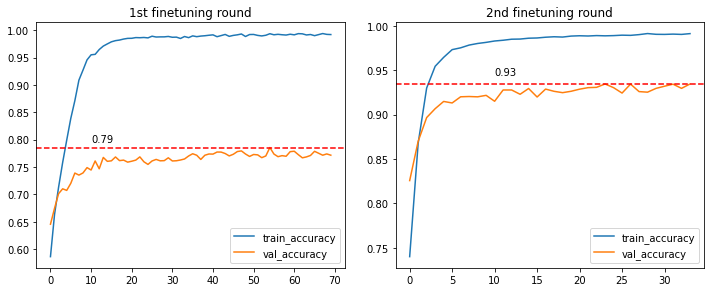

In [40]:
%pylab inline

def show_train_result(train_result=None, ax=None, title=None):
    df = pd.DataFrame({
        'train_loss': train_result['train.score']['loss'],
        'val_loss': train_result['val.score']['loss'],
        'train_accuracy': train_result['train.score']['accuracy'],
        'val_accuracy': train_result['val.score']['accuracy']
    })

    ax = df.loc[:, ['train_accuracy', 'val_accuracy']].plot(ax=ax, title=title, label='best:0.999')
    bs = train_result['best_score']
    ax.axhline(y=bs, ls='--', c='red')
#     ax.annotate('%0.2f' % bs, (10, bs+0.01))
    print('##############################')
    print('n_epochs: %s' % train_result['n_epochs'])
    print('stopped_epoch: %s' % train_result['stopped_epoch'])
    print('best_epoch: %s' % train_result['best_epoch'])
    print('best_score: %s' % train_result['best_score'])
    print('best_chk: %s' % train_result['best_chk'])


fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(4)
plt.tight_layout(h_pad=2, w_pad=2)

show_train_result(train_result=experiment.get_train_result(0), 
                  ax=axes[0], 
                  title='1st finetuning round')
show_train_result(train_result=experiment.get_train_result(1), 
                  ax=axes[1], 
                  title='2nd finetuning round')



## Loading final fine-tuned model

In [29]:
model = experiment.load_eval_model()
display(model)

# Eval result recoder
eval_recoder = PredResultRecoder(output_attentions=True)
model.add_pred_listener(eval_recoder)

2021-09-28 00:26:21 [INFO]: Create TAPE model using config: ../config/bert-base/
2021-09-28 00:26:23 [INFO]: Loading the eval model from ../output/exp1/train.1.model_23.chk


BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): ProteinBertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm()
              (dropout): Dropout(p=0.1)
            )
     

## 모델 평가와 결과분석

### Shomuradova et al

- Performance evaluation for the dataset containing COVID-19 S-protein269-277(YLQPRTFLL) epitope with the 352 epitope-specific TCRβs from {Shomuradova:2020}
- TCR3b sequence motifs와 attention weights와의 상관관계는?

In [45]:
from torch.utils.data import DataLoader
from tcrbert.dataset import TCREpitopeSentenceDataset

epitope = 'YLQPRTFLL'
metrics = ['accuracy', 'f1', 'roc_auc']

eval_ds = TCREpitopeSentenceDataset.from_key('shomuradova')
eval_data_loader = DataLoader(eval_ds, batch_size=len(eval_ds), shuffle=False, num_workers=2)

model.predict(data_loader=eval_data_loader, metrics=metrics)

2021-09-28 02:04:48 [INFO]: ======================
2021-09-28 02:04:48 [INFO]: Begin predict...
2021-09-28 02:04:48 [INFO]: use_cuda, device: False, cpu
2021-09-28 02:04:48 [INFO]: model: BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): ProteinBe

2021-09-28 02:04:48 [INFO]: n_data: 610
2021-09-28 02:04:48 [INFO]: batch_size: 610
2021-09-28 02:04:48 [INFO]: Begin 0/1 prediction batch
2021-09-28 02:04:58 [INFO]: End 0/1 prediction batch
2021-09-28 02:04:58 [INFO]: Done to predict...
2021-09-28 02:04:58 [INFO]: ======================


### ROC performance curve

Populating the interactive namespace from numpy and matplotlib
score_map: OrderedDict([('accuracy', 0.9573770491803278), ('f1', 0.9568106312292358), ('roc_auc', 0.9826390755173341)])


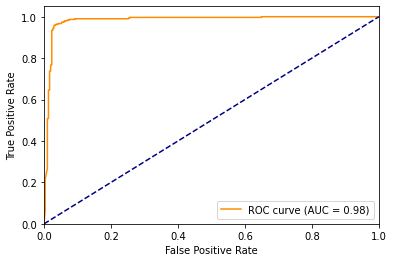

In [52]:
%pylab inline

from sklearn.metrics import roc_curve, auc

input_labels  = np.array(eval_recoder.result_map['input_labels'])
output_labels = np.array(eval_recoder.result_map['output_labels'])
output_probs  = np.array(eval_recoder.result_map['output_probs'])

fpr, tpr, _ = roc_curve(input_labels, output_probs)
score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

print('score_map: %s' % eval_recoder.result_map['score_map'])

### Length distributions of CDR3beta sequences

- Model에 의해 Positive/Negative로 분류된 CDR3beta 서열의 길이 분포를 알아본다

Populating the interactive namespace from numpy and matplotlib
Write fasta for pos_cdr3b seqs.
Write fasta for neg_cdr3b seqs.


Text(0.5, 24.0, 'Length')

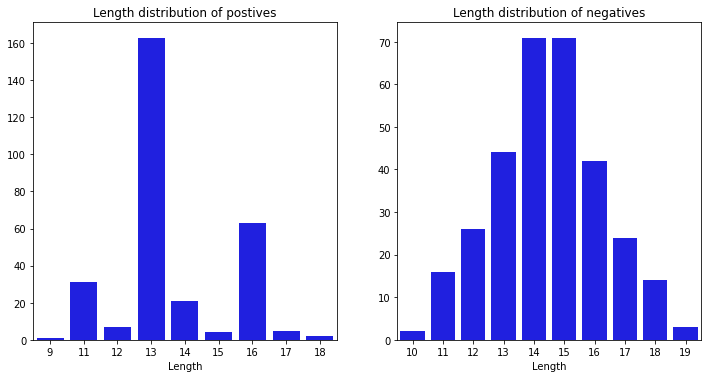

In [57]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.image as image

import seaborn as sns
from collections import Counter

import numpy as np
from tcrbert.dataset import CN
from tcrbert.bioseq import write_fa

eval_df = eval_ds.df_enc

pos_indices = np.where(output_labels == 1)[0]
neg_indices = np.where(output_labels == 0)[0]

# print('pos_indices: %s(%s)' % (pos_indices, str(pos_indices.shape)))
# print('neg_indices: %s(%s)' % (neg_indices, str(neg_indices.shape)))

pos_cdr3b = eval_df[CN.cdr3b].values[pos_indices]
neg_cdr3b = eval_df[CN.cdr3b].values[neg_indices]

write_fa('../output/shomuradova.pos_cdr3b.fa', pos_cdr3b)
print('Write fasta for pos_cdr3b seqs.')

write_fa('../output/shomuradova.neg_cdr3b.fa', neg_cdr3b)
print('Write fasta for neg_cdr3b seqs.')

##########################################
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(5)
plt.tight_layout(h_pad=1, w_pad=3)

lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), pos_cdr3b)).items()))
ax = sns.barplot(x=list(lens), y=list(cnts), ax=axes[0], color='blue')
ax.set_title('Length distribution of postives')
ax.set_xlabel('Length')

lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), neg_cdr3b)).items()))
ax = sns.barplot(x=list(lens), y=list(cnts), ax=axes[1], color='blue')
ax.set_title('Length distribution of negatives')
ax.set_xlabel('Length')

# pos_slogo = image.imread('../output/shomuradova.pos_cdr3b_seqlogo.jpeg')
# axes[1][0].set_title('SeqLogo for positive MSA')
# axes[1][0].set_axis_off()
# axes[1][0].imshow(pos_slogo, aspect='equal')

# neg_slogo = image.imread('../output/shomuradova.neg_cdr3b_seqlogo.jpeg')
# axes[1][1].set_title('SeqLogo for negative MSA')
# axes[1][1].set_axis_off()
# axes[1][1].imshow(neg_slogo, aspect='equal')

- Length distribution
    - Positive의 경우, 대부분의 서열 길이는 13이고 뒤를 이어 16, 11에 몰려 있다
    - Negative의 경우, 11-18 길이로 골고루 분포되어 있으며, 14, 15에 가장 많이 있다.  

<strike>
- MSA
    - Positive의 경우, 1-3번 위치에 C, A, <b>8번 위치에 P</b>, 16-20번 위치에 E, F가 모티프
    - Negative의 경우, 1-3번 위치에 C, A, 4, 5번 위치에 S, 18-21번 위치에 각각 E, Q, F, 22-25번에 P, Q, H, F가 모티프

- Positive/negative MSA 간의 모티프 차이점
    - 앞단 위치의 모티프 구성: pos=>CCA, neg=>CCASS
    - Positive MSA의 8번 위치의 P
    - 말단 위치에서의 positive의 경우 E, F로 모티프가 구성되는 반면, negative의 경우 E, Q, F로 구성되는 점
    - Positive MSA에서는 나타나지 않은 negative의 최말단에 P, Q, H, F로 구성되는 모티프가 있음
</strike>

### Investigation of attention weights in YLQPRTFLL-CDR3b sequences 
- Epitope-specific TCR 상호작용에서의 위치 특이적 모티프들을 알아내기 위해 보통 TCR 서열들의 MSA 상에서 highly-conserved 위치들을 모티프로 본다. 

- YLQPRTFLL 에피토프와 TCR 상호작용에서의 위치특이적 아미노산 기여도를 알아내기 위해서 positive 데이터셋의 epitope-CDR3beta 서열 상에서 우리의 모델에 의해 캡쳐되는 attention weight를 조사하였다.
- BERTology는 TAPE, ProtAlbert 등과 같은 protein Transformer 모델의 output attention을 분석을 통하여 단백질 접힘 구조와 단백질 목표 결합 사이트 등을 효과적으로 캡쳐할 수 있음을 보였다{Vig, J:2020}
- Epitope-specific TCR 인지에서의 기존의 서열 기반의 모티프 분석 방법들은 TCR 서열들만을 대상으로 highly conserved 위치들을 대상으로 하기 때문에 epitope 펩타이드 서열 상의 모티프를 식별하는 것은 어려웠다. 
- 그러나, 여기서 제시하고 있는 방법은 epitope 펩타이드 서열과 TCR 서열 모두 동시에 고려하기 때문에 더욱 유용하다. 

Transformer architectures have proven to learn useful representations for protein classification and generation tasks. However, these representations present challenges in interpretability. In this work, we demonstrate a set of methods for analyzing protein Transformer models through the lens of attention. We show that attention: (1) captures the folding structure of proteins, connecting amino acids that are far apart in the underlying sequence, but spatially close in the three-dimensional structure, (2) targets binding sites, a key functional component of proteins, and (3) focuses on progressively more complex biophysical properties with increasing layer depth. We find this behavior to be consistent across three Transformer architectures (BERT, ALBERT, XLNet) and two distinct protein datasets. We also present a three-dimensional visualization of the interaction between attention and protein structure. Code for visualization and analysis is available at this https URL.

Populating the interactive namespace from numpy and matplotlib
attentions.shape: (12, 610, 12, 40, 40)
pos_attns.shape: (12, 297, 12, 40, 40), neg_attns.shape: (12, 313, 12, 40, 40)
sub_pos_attns.shape: (6, 28), sub_neg_attns.shape: (6, 29)


<AxesSubplot:xlabel='Position', ylabel='Layer'>

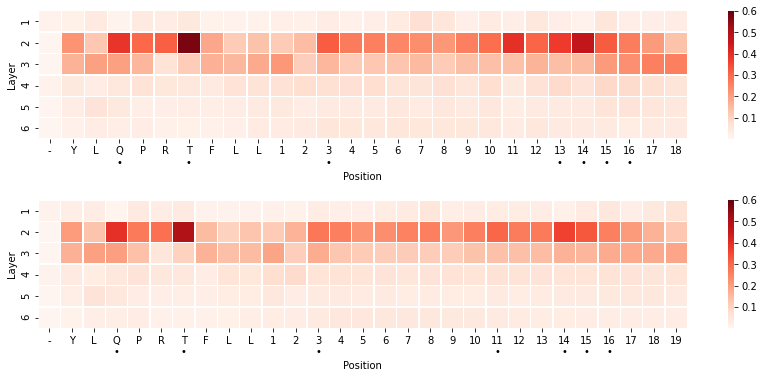

In [73]:
%pylab inline

import numpy as np
from tcrbert.dataset import CN
from tcrbert.bioseq import write_fa

def show_attentions(attns=None, ax=None, mark_top_rank=None):
    g = sns.heatmap(attns, ax=ax, linewidths=.4, cmap='Reds', vmax=0.6, cbar=True)
    g.set_xlabel('Position')
    xt_labels = ['-'] + list(epitope) + \
                list(range(1, attns.shape[1] - len(epitope)))
    
    if mark_top_rank:
        for rank, pos in enumerate(np.argsort(attns.mean(axis=0))[::-1]):
            if rank < mark_top_rank:
                xt_labels[pos] = '%s\n•' % (xt_labels[pos])
            
    g.set_xticklabels(xt_labels)    
    g.set_ylabel('Layer')
    g.set_yticklabels(range(1, attns.shape[0] + 1))
    return g

n_layers = model.config.num_hidden_layers
n_data = len(eval_ds)
n_heads = model.config.num_attention_heads
max_len = eval_ds.max_len

attentions = eval_recoder.result_map['attentions']
# attentions.shape: (n_layers, n_data, n_heads, max_len, max_len)
print('attentions.shape: %s' % str(attentions.shape))

pos_attns = attentions[:, pos_indices]
neg_attns = attentions[:, neg_indices]
print('pos_attns.shape: %s, neg_attns.shape: %s' % (str(pos_attns.shape), str(neg_attns.shape)))

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(12)
fig.set_figheight(5)
plt.tight_layout(h_pad=4)

max_pos = 1 + len(epitope) + max(map(lambda x: len(x), pos_cdr3b))
sub_pos_attns = np.median(pos_attns[-6:, :, :, :max_pos,  0], axis=(1, 2))
max_pos = 1 + len(epitope) + max(map(lambda x: len(x), neg_cdr3b))
sub_neg_attns = np.median(neg_attns[-6:, :, :, :max_pos,  0], axis=(1, 2))

print('sub_pos_attns.shape: %s, sub_neg_attns.shape: %s' % (str(sub_pos_attns.shape), str(sub_neg_attns.shape)))
show_attentions(attns=sub_pos_attns, ax=axes[0], mark_top_rank=7)
show_attentions(attns=sub_neg_attns, ax=axes[1], mark_top_rank=7)


#### Results
- YLQPRTFLL 에피토프의 4번 위치의 P에 매우 높은 attention 가중치가 나왔다. 이는 TCR-epitope 상호작용에 있어 4번 위치의 P가 매우 중요한 역할을 한다는 것을 보여 준다.
- 2021.6월에 medRxiv preprint로 공개된 {Garry Dolton:2021}에 따르면 spike protein에서의 P272L 변이는 영국의 2차 대유행과 연관이 있음이 밝혀졌다. P272L 변이는 완치된 환자의 T-Cell 대응을 무력화 시키고, 따라서 기존 COVID-19 백신으로 T-Cell 면역이 활성화된 대조군에서 P272L 변이 펩타이드를 인지하지 못하는 것으로 밝혀졌다(https://www.news-medical.net/news/20210629/Widespread-SARS-CoV-2-mutation-escapes-vaccine-and-infection-induced-CD8-T-cell-responses.aspx).
- 자 그럼, P4와 높은 상호작용을 하는 TCR 서열의 잔기 위치는 어디일까? 이는 TCR 서열 위치에서의 attention 가중치가 높은 위치일 것이다. 
- TCR 서열에서 Attention weight가 상대적으로 높은 곳은 1, 8, 14, 15, 17, 18번이다. 이는 MSA seqlogo에서 보는 바와 같이 Gap을 고려하지 않는다면 대부분 highly conserved된 모티프 부위와 거의 일치한다.
- 특히, negative MSA와 극명하게 차이나는 모티프인 8번 위치는 높은 attention weight를 보이는 것으로 나타났다.


## ImmuneCODE

-  The dataset contained 415 COVID-19 S-protein269-277-specific TCRs from the ImmuneRACE study launched by Adaptive Biotechnologies and Microsoft (https://immunerace.adaptivebiotech.com, June 10, 2020 dataset, from hereon referred to as ImmuneCODE dataset
- TCR3b sequence motifs와 attention weights와의 상관관계는?

In [74]:
from torch.utils.data import DataLoader
from tcrbert.dataset import TCREpitopeSentenceDataset

eval_ds = TCREpitopeSentenceDataset.from_key('immunecode')
eval_data_loader = DataLoader(eval_ds, batch_size=len(eval_ds), shuffle=False, num_workers=2)

model.predict(data_loader=eval_data_loader, metrics=metrics)

2021-09-28 03:41:01 [INFO]: ======================
2021-09-28 03:41:01 [INFO]: Begin predict...
2021-09-28 03:41:01 [INFO]: use_cuda, device: False, cpu
2021-09-28 03:41:01 [INFO]: model: BertTCREpitopeModel(
  (bert): ProteinBertModel(
    (embeddings): ProteinBertEmbeddings(
      (word_embeddings): Embedding(30, 768, padding_idx=0)
      (position_embeddings): Embedding(8192, 768)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): ProteinBertEncoder(
      (layer): ModuleList(
        (0): ProteinBertLayer(
          (attention): ProteinBertAttention(
            (self): ProteinBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): ProteinBe

2021-09-28 03:41:01 [INFO]: n_data: 765
2021-09-28 03:41:01 [INFO]: batch_size: 765
2021-09-28 03:41:01 [INFO]: Begin 0/1 prediction batch
2021-09-28 03:41:32 [INFO]: End 0/1 prediction batch
2021-09-28 03:41:33 [INFO]: Done to predict...
2021-09-28 03:41:33 [INFO]: ======================


### ROC performance curve

Populating the interactive namespace from numpy and matplotlib
score_map: OrderedDict([('accuracy', 0.9633986928104575), ('f1', 0.9622641509433962), ('roc_auc', 0.9859417808219179)])


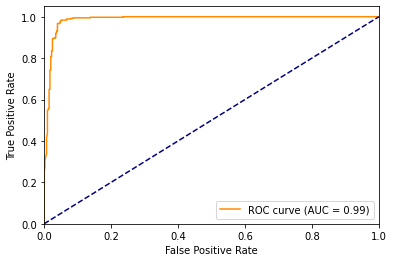

In [75]:
%pylab inline

from sklearn.metrics import roc_curve, auc

input_labels  = np.array(eval_recoder.result_map['input_labels'])
output_labels = np.array(eval_recoder.result_map['output_labels'])
output_probs  = np.array(eval_recoder.result_map['output_probs'])

fpr, tpr, _ = roc_curve(input_labels, output_probs)
score = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % score)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

print('score_map: %s' % eval_recoder.result_map['score_map'])

### Length distributions of TCR CDR3b sequences

Populating the interactive namespace from numpy and matplotlib
Write fasta for pos_cdr3b seqs.
Write fasta for neg_cdr3b seqs.


Text(0.5, 24.0, 'Length')

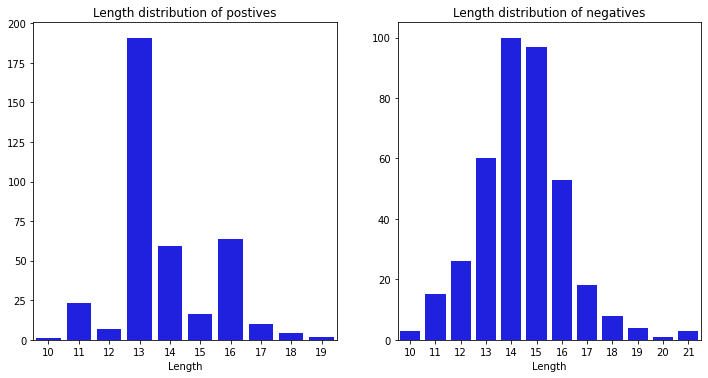

In [76]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.image as image

import seaborn as sns
from collections import Counter

import numpy as np
from tcrbert.dataset import CN
from tcrbert.bioseq import write_fa

eval_df = eval_ds.df_enc

pos_indices = np.where(output_labels == 1)[0]
neg_indices = np.where(output_labels == 0)[0]

# print('pos_indices: %s(%s)' % (pos_indices, str(pos_indices.shape)))
# print('neg_indices: %s(%s)' % (neg_indices, str(neg_indices.shape)))

pos_cdr3b = eval_df[CN.cdr3b].values[pos_indices]
neg_cdr3b = eval_df[CN.cdr3b].values[neg_indices]

write_fa('../output/immunecode.pos_cdr3b.fa', pos_cdr3b)
print('Write fasta for pos_cdr3b seqs.')

write_fa('../output/immunecode.neg_cdr3b.fa', neg_cdr3b)
print('Write fasta for neg_cdr3b seqs.')

##########################################
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(10)
fig.set_figheight(5)
plt.tight_layout(h_pad=1, w_pad=3)

lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), pos_cdr3b)).items()))
ax = sns.barplot(x=list(lens), y=list(cnts), ax=axes[0], color='blue')
ax.set_title('Length distribution of postives')
ax.set_xlabel('Length')

lens, cnts = zip(*sorted(Counter(map(lambda x: len(x), neg_cdr3b)).items()))
ax = sns.barplot(x=list(lens), y=list(cnts), ax=axes[1], color='blue')
ax.set_title('Length distribution of negatives')
ax.set_xlabel('Length')

### Investigation of attention weights

Populating the interactive namespace from numpy and matplotlib
attentions.shape: (12, 765, 12, 40, 40)
pos_attns.shape: (12, 377, 12, 40, 40), neg_attns.shape: (12, 388, 12, 40, 40)
sub_pos_attns.shape: (6, 29), sub_neg_attns.shape: (6, 31)


<AxesSubplot:xlabel='Position', ylabel='Layer'>

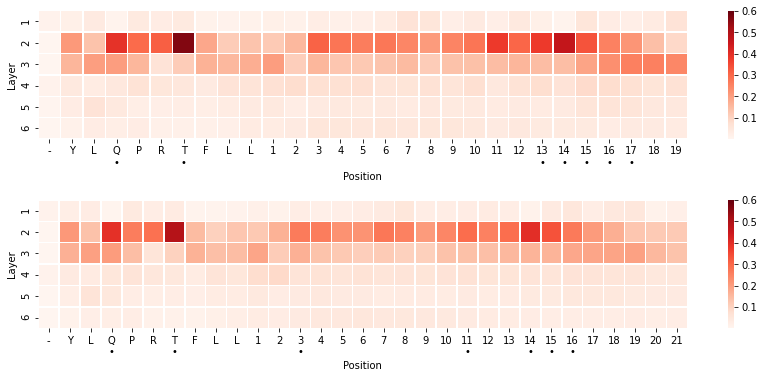

In [87]:
%pylab inline

import numpy as np
from tcrbert.dataset import CN
from tcrbert.bioseq import write_fa

n_layers = model.config.num_hidden_layers
n_data = len(eval_ds)
n_heads = model.config.num_attention_heads
max_len = eval_ds.max_len

attentions = eval_recoder.result_map['attentions']
# attentions.shape: (n_layers, n_data, n_heads, max_len, max_len)
print('attentions.shape: %s' % str(attentions.shape))

pos_attns = attentions[:, pos_indices]
neg_attns = attentions[:, neg_indices]


print('pos_attns.shape: %s, neg_attns.shape: %s' % (str(pos_attns.shape), str(neg_attns.shape)))
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figwidth(12)
fig.set_figheight(5)
plt.tight_layout(h_pad=4)

max_pos = 1 + len(epitope) + max(map(lambda x: len(x), pos_cdr3b))
sub_pos_attns = np.median(pos_attns[-6:, :, :, :max_pos,  0], axis=(1, 2))
max_pos = 1 + len(epitope) + max(map(lambda x: len(x), neg_cdr3b))
sub_neg_attns = np.median(neg_attns[-6:, :, :, :max_pos,  0], axis=(1, 2))

print('sub_pos_attns.shape: %s, sub_neg_attns.shape: %s' % (str(sub_pos_attns.shape), str(sub_neg_attns.shape)))


show_attentions(attns=sub_pos_attns, ax=axes[0], mark_top_rank=7)
show_attentions(attns=sub_neg_attns, ax=axes[1], mark_top_rank=7)


- Shomuradova 데이터셋의 결과와 마찬가지로, YLQPRTFLL 에피토프의 4번 위치의 P에 매우 높은 attention 가중치가 나왔다. 이는 TCR 분자가 에피토프를 인지하여 T-Cell 면역 대응을 유도하는 데 있어 에피토프의 4번 위치의 P가 매우 중요한 역할을 한다는 것을 보여 준다.
- 몇달전에 {Garry Dolton:2021} 연구에서 보고된 바에 따르면 spike protein에서의 P272L 변이는 영국의 2차 대유행과 연관이 있음이 밝혀졌다. P272L 변이는 완치된 환자의 T-Cell 대응을 무력화 시키고 백신에 대한 면역 회피를 야기하는 것으로 알려졌다.
- 자 그럼, 에피토와와 높은 상호작용을 하는 TCR 서열의 잔기 위치는 어디일까? 이는 TCR 서열 위치에서의 attention 가중치가 높은 위치일 것이다. 
- TCR 서열에서 Attention weight가 상대적으로 높은 곳은 Shomuradova 데이터셋의 결과와 마찬가지로 1, 8, 14, 15, 17, 18번이다. 이는 MSA seqlogo에서 보는 바와 같이 Gap을 고려하지 않는다면 대부분 highly conserved된 모티프 부위와 어느 정도 일치하지만 Shomuradova 데이터셋만큼은 아니다. 
- 이것으로 볼때, 에피토프와 높은 상호작용을 하는 TCR 서열 잔기 위치를 파악하는 데 있어 MSA 기반으로 conserved 모티프로부터 추론하는 방법도 전통적으로 유용하지만 attention weight로부터 유추하는 것이 더욱 심플하고 효과적일 수 있다는 것을 알 수 있다.